In [1]:
# shearlets library
import numpy as np
from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab
import scipy.misc
import cv2
import imageio
# the rest of the library
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.signal import medfilt
from scipy import arange
import sys
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import scipy as sc
from scipy.ndimage import gaussian_filter
from numpy import vstack
from numpy import hstack
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pywt
from sklearn import preprocessing
from scipy.fftpack import fft, ifft
from scipy import fftpack
from scipy.stats import norm
import scipy as sc
import statistics
from scipy import signal
from scipy import stats
from PIL import Image
from scipy.ndimage import gaussian_filter
import cv2
from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab
import scipy.misc
import cv2
import imageio
from sklearn.cluster import MeanShift, estimate_bandwidth
plt.style.use('dark_background')
# 

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dir1 = '/volumes/MYUSB/Thesis//HippoRat.brw'
dir2 = '/volumes/MYUSB/Thesis/HippoRatShearlets.brw'

In [3]:
# def loadData(directory):
# #     'HippoRat.brw'
#      with h5py.File(directory, 'r') as hdf:

#         chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
#         numChs = len(chsList)
#         frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])
#         data = np.array(hdf.get('3BData/Raw'))
#         return data, numChs, frames

In [4]:
def loadData(directory):
#     'HippoRat.brw'
     with h5py.File(directory, 'r') as hdf:

        chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
        numChs = len(chsList)
        frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])

#         channelIdx = index
#         ids = np.arange(channelIdx, frames * numChs, numChs)
        data = np.array(hdf.get('3BData/Raw'))

        # extract info relating to signal conversion 
        signalInversion = np.array(hdf.get('/3BRecInfo/3BRecVars/SignalInversion')[0])
        maxUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MaxVolt')[0]))
        minUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MinVolt')[0]))
        bitDepth = (np.array(hdf.get('/3BRecInfo/3BRecVars/BitDepth')[0]))
        sampmlingFrequency = (np.array(hdf.get('3BRecInfo/3BRecVars/SamplingRate')[0]))

        qLevel = 2**bitDepth 
        fromQLevelToUVolt = (maxUVolt - minUVolt) / qLevel
        singleElectrodeUV = data * signalInversion;
        singleElectrodeUV = singleElectrodeUV - (qLevel / 2);
        singleElectrodeUV = singleElectrodeUV * fromQLevelToUVolt
        return singleElectrodeUV, numChs, frames,sampmlingFrequency

In [5]:
def loadChannel(channel, directory):
    xstr = (channel[0],channel[1])
    # good signal (53,20)
    # signals embedded into the noise [34,23] 
    # no signals only basal noise [35,12]
    # positive and negative spikes [16,4]
    # noisy electrode - [22,7]
    # 'Culture_Accura_Hippo_Rat_11DIV_6.5sec_Spontaneous.brw'

    # Load data
    with h5py.File(directory, 'r') as hdf:
        chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
        numChs = len(chsList)
        frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])
        selectedChannel = (chsList['Row'] == int(xstr[0])) * (chsList['Col'] == int(xstr[1]))
        channelIdx = np.where(selectedChannel == True)[0][0]
        ids = np.arange(channelIdx, frames * numChs, numChs)

#         print('frames: ', frames)
        data = np.array(hdf.get('3BData/Raw'))[ids]
        # extract info relating to signal conversion 
        signalInversion = np.array(hdf.get('/3BRecInfo/3BRecVars/SignalInversion')[0])
        maxUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MaxVolt')[0]))
        minUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MinVolt')[0]))
        bitDepth = (np.array(hdf.get('/3BRecInfo/3BRecVars/BitDepth')[0]))
        sampmlingFrequency = (np.array(hdf.get('3BRecInfo/3BRecVars/SamplingRate')[0]))

    qLevel = 2**bitDepth 
    fromQLevelToUVolt = (maxUVolt - minUVolt) / qLevel
    singleElectrodeUV = data * signalInversion;
    singleElectrodeUV = singleElectrodeUV - (qLevel / 2);
    singleElectrodeUV = singleElectrodeUV * fromQLevelToUVolt
    return  singleElectrodeUV, sampmlingFrequency

In [6]:
def Clustering2(coeffs):
    
    v = np.vstack(coeffs)
    pca = PCA(n_components = 2)
    pca.fit(v)
    Z = pca.transform(v)

    # from sklearn.datasets import make_blobs
    bandwidth = estimate_bandwidth(Z, quantile=0.3, n_samples=150)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(Z)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print("number of estimated clusters : %d" % n_clusters_)

    l = labels
    l_sorted = Counter(l).most_common()
    l_sorted

    clusterToLookAt = 0
    mask = map(lambda x : 1 if (x == clusterToLookAt) else 0, labels )
    mask = list(mask)
    
    m = np.array(v)
    c = np.array(mask)
    
    V = m * c[:, np.newaxis]
    V = np.array(V).reshape(64,64,17)
    return V
    

In [7]:
def shearlets(matrix):
    sigma = 10
    scales = 2
    thresholdingFactor = 20
    # load data
#     X = imageio.imread('barbara.jpg')[::4, ::4]
    matrix = matrix.astype(float)
    X = matrix 
    # add noise
#     Xnoisy = X + sigma*np.random.randn(X.shape[0], X.shape[1])
    ## create shearlets
    shearletSystem = pyshearlab.SLgetShearletSystem2D(0,X.shape[0], X.shape[1], scales)
    # decomposition
    coeffs = pyshearlab.SLsheardec2D(X, shearletSystem)
    # thresholding
    oldCoeffs = coeffs.copy()
    weights = np.ones(coeffs.shape)

    for j in range(len(shearletSystem["RMS"])):
        weights[:,:,j] = shearletSystem["RMS"][j]*np.ones((X.shape[0], X.shape[1]))

    coeffs = np.real(coeffs)
    zero_indices = np.abs(coeffs) / (thresholdingFactor * weights * sigma) < 1
    coeffs[zero_indices] = 0
    
#      filteredCoeffs = Clustering2(coeffs)

    # reconstruction
    Xrec = pyshearlab.SLshearrec2D(coeffs, shearletSystem)
#     Xrec = pyshearlab.SLshearrec2D(filteredCoeffs, shearletSystem)

    PSNR = pyshearlab.SLcomputePSNR(X,Xrec)
#     print("PSNR: " + str(PSNR))
    return Xrec



In [8]:
def shearletsTwo(matrix):
    sigma = 1
    scales = 2
    thresholdingFactor = 1
    # load data
#     X = imageio.imread('barbara.jpg')[::4, ::4]
    matrix = matrix.astype(float)
    X = matrix 
    # add noise
#     Xnoisy = X + sigma*np.random.randn(X.shape[0], X.shape[1])
    ## create shearlets
    shearletSystem = pyshearlab.SLgetShearletSystem2D(0,X.shape[0], X.shape[1],scales)
    # decomposition
    coeffs = pyshearlab.SLsheardec2D(X, shearletSystem)
    # thresholding
    oldCoeffs = coeffs.copy()
    weights = np.ones(coeffs.shape)

    for j in range(len(shearletSystem["RMS"])):
        weights[:,:,j] = shearletSystem["RMS"][j]*np.ones((X.shape[0], X.shape[1]))

    coeffs = np.real(coeffs)
    zero_indices = np.abs(coeffs) / (thresholdingFactor * weights * sigma) < 1
    coeffs[zero_indices] = 0
    
#     print("coeffs shape:",coeffs.shape)
    
    #   ////////////////// my func ////////////////////////////////////////////////
    v = np.vstack(coeffs)
    pca = PCA(n_components = 1)
    pca.fit(v)
    Z = pca.transform(v)
    
    kmeans = KMeans(n_clusters=1).fit(Z)
    centroids = kmeans.cluster_centers_
    Distance = cdist(Z, centroids)
    Distance
    
    satandardDiv = np.std(Z)
    threshold = 3 * satandardDiv
    
    mask = map(lambda x : 1 if (x > threshold) else 0, Distance)
    mask = list(mask)
    
    m = np.array(v)
    c = np.array(mask)
    
    V = m * c[:, np.newaxis]
    V = np.array(V).reshape(64,64,17)
    
#  ///////////////////////////////////////////////////////////////////////////////

    # reconstruction
    Xrec = pyshearlab.SLshearrec2D(V, shearletSystem)

    PSNR = pyshearlab.SLcomputePSNR(X,Xrec)
#     print("PSNR: " + str(PSNR))
    return Xrec

In [9]:
rawData, numChs, frames, sampmlingFrequency =  loadData(dir1)
print("frames: ",frames)

frames:  21022


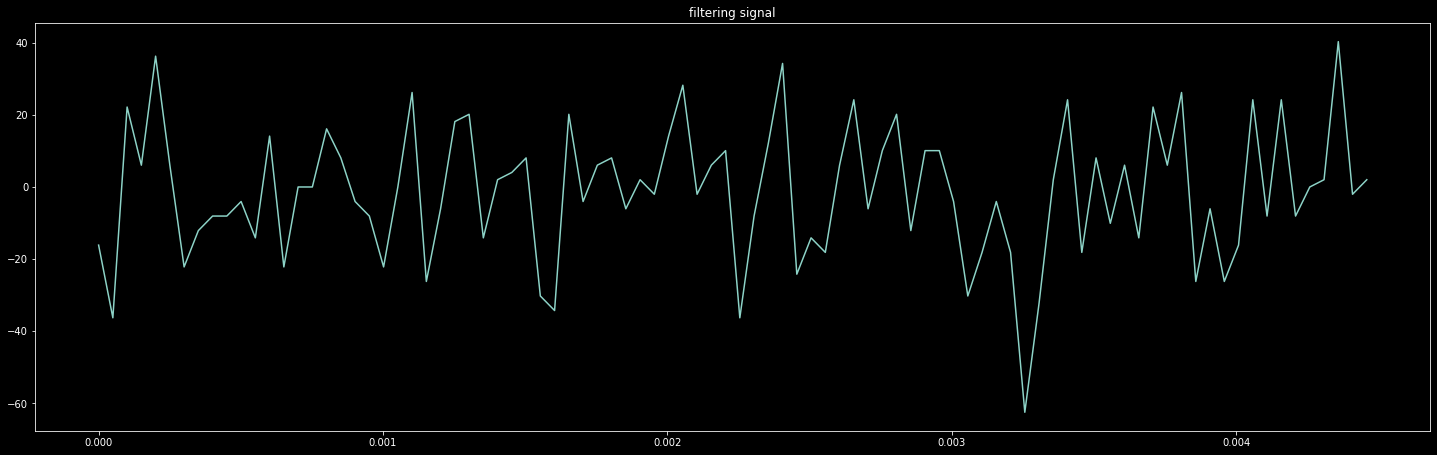

In [10]:
start = 10
end = 100
plt.figure(figsize=(25,7.5))
plt.plot(range(len(rawData[start:end]))/sampmlingFrequency, rawData[start:end]) 
plt.title('filtering signal')
plt.show()

In [11]:
OutData = []
windowSize = 5
# bellow was range(frames - windowSize)

for pos in range(frames - windowSize):
    if(pos%1000 == 0):
        print("pos: ",pos)
    storeArr = []
    start = pos
    
    for i in range(start,start + windowSize):
        frame = i
        data = rawData[numChs * frame :numChs * (frame + 1)]
        storeArr.append(data) 
#     print("len storeArr",len(storeArr))
    storeArr = np.array(storeArr)
    meanWindow = storeArr.mean(axis=0)
    OutData.append(meanWindow)



pos:  0
pos:  1000
pos:  2000
pos:  3000
pos:  4000
pos:  5000
pos:  6000
pos:  7000
pos:  8000
pos:  9000
pos:  10000
pos:  11000
pos:  12000
pos:  13000
pos:  14000
pos:  15000
pos:  16000
pos:  17000
pos:  18000
pos:  19000
pos:  20000
pos:  21000


In [12]:
print(len(OutData))

21017


In [13]:
shearletMatrix = []
# len(OutData)
for s in range(0,len(OutData)):
    I = OutData[s].reshape(64,64)
    # I.shape
    # print(I)
    # M = np.random.rand(64,64)
#     Xrec = shearlets(matrix = I)
    Xrec = shearletsTwo(matrix = I)
  

    # plt.figure(figsize=(25,7.5))
    # plt.gray()
    # plt.imshow(Xrec)
    # plt.colorbar()
    # plt.show()

    XrecArr =  Xrec.flatten()
#     print(XrecArr.shape)
    # print(XrecArr)
    shearletMatrix.append(XrecArr)
    
    
    print("s: ",s)
    
   

s:  0
s:  1
s:  2
s:  3
s:  4
s:  5
s:  6
s:  7
s:  8
s:  9
s:  10
s:  11
s:  12
s:  13
s:  14
s:  15
s:  16
s:  17
s:  18
s:  19
s:  20
s:  21
s:  22
s:  23
s:  24
s:  25
s:  26
s:  27
s:  28
s:  29
s:  30
s:  31
s:  32
s:  33
s:  34
s:  35
s:  36
s:  37
s:  38
s:  39
s:  40
s:  41
s:  42
s:  43
s:  44
s:  45
s:  46
s:  47
s:  48
s:  49


s:  50
s:  51
s:  52
s:  53
s:  54
s:  55
s:  56
s:  57
s:  58
s:  59
s:  60
s:  61
s:  62
s:  63
s:  64
s:  65
s:  66
s:  67
s:  68
s:  69
s:  70
s:  71
s:  72
s:  73
s:  74
s:  75
s:  76
s:  77
s:  78
s:  79
s:  80
s:  81
s:  82
s:  83
s:  84
s:  85
s:  86
s:  87
s:  88
s:  89
s:  90
s:  91
s:  92
s:  93
s:  94
s:  95
s:  96
s:  97
s:  98
s:  99
s:  100


s:  101
s:  102
s:  103
s:  104
s:  105
s:  106
s:  107
s:  108
s:  109
s:  110
s:  111
s:  112
s:  113
s:  114
s:  115
s:  116
s:  117
s:  118
s:  119
s:  120
s:  121
s:  122
s:  123
s:  124
s:  125
s:  126
s:  127
s:  128
s:  129
s:  130
s:  131
s:  132
s:  133
s:  134
s:  135
s:  136
s:  137
s:  138
s:  139
s:  140
s:  141
s:  142
s:  143
s:  144
s:  145
s:  146
s:  147
s:  148
s:  149
s:  150
s:  151


s:  152
s:  153
s:  154
s:  155
s:  156
s:  157
s:  158
s:  159
s:  160
s:  161
s:  162
s:  163
s:  164
s:  165
s:  166
s:  167
s:  168
s:  169
s:  170
s:  171
s:  172
s:  173
s:  174
s:  175
s:  176
s:  177
s:  178
s:  179
s:  180
s:  181
s:  182
s:  183
s:  184
s:  185
s:  186
s:  187
s:  188
s:  189
s:  190
s:  191
s:  192
s:  193
s:  194
s:  195
s:  196
s:  197
s:  198
s:  199
s:  200
s:  201


s:  202
s:  203
s:  204
s:  205
s:  206
s:  207
s:  208
s:  209
s:  210
s:  211
s:  212
s:  213
s:  214
s:  215
s:  216
s:  217
s:  218
s:  219
s:  220
s:  221
s:  222
s:  223
s:  224
s:  225
s:  226
s:  227
s:  228
s:  229
s:  230
s:  231
s:  232
s:  233
s:  234
s:  235
s:  236
s:  237
s:  238
s:  239
s:  240
s:  241
s:  242
s:  243
s:  244
s:  245
s:  246
s:  247
s:  248
s:  249
s:  250
s:  251
s:  252


s:  253
s:  254
s:  255
s:  256
s:  257
s:  258
s:  259
s:  260
s:  261
s:  262
s:  263
s:  264
s:  265
s:  266
s:  267
s:  268
s:  269
s:  270
s:  271
s:  272
s:  273
s:  274
s:  275
s:  276
s:  277
s:  278
s:  279
s:  280
s:  281
s:  282
s:  283
s:  284
s:  285
s:  286
s:  287
s:  288
s:  289
s:  290
s:  291
s:  292
s:  293
s:  294
s:  295
s:  296
s:  297
s:  298
s:  299
s:  300
s:  301
s:  302
s:  303


s:  304
s:  305
s:  306
s:  307
s:  308
s:  309
s:  310
s:  311
s:  312
s:  313
s:  314
s:  315
s:  316
s:  317
s:  318
s:  319
s:  320
s:  321
s:  322
s:  323
s:  324
s:  325
s:  326
s:  327
s:  328
s:  329
s:  330
s:  331
s:  332
s:  333
s:  334
s:  335
s:  336
s:  337
s:  338
s:  339
s:  340
s:  341
s:  342
s:  343
s:  344
s:  345
s:  346
s:  347
s:  348
s:  349
s:  350
s:  351
s:  352
s:  353
s:  354


s:  355
s:  356
s:  357
s:  358
s:  359
s:  360
s:  361
s:  362
s:  363
s:  364
s:  365
s:  366
s:  367
s:  368
s:  369
s:  370
s:  371
s:  372
s:  373
s:  374
s:  375
s:  376
s:  377
s:  378
s:  379
s:  380
s:  381
s:  382
s:  383
s:  384
s:  385
s:  386
s:  387
s:  388
s:  389
s:  390
s:  391
s:  392
s:  393
s:  394
s:  395
s:  396
s:  397
s:  398
s:  399
s:  400
s:  401
s:  402
s:  403
s:  404


s:  405
s:  406
s:  407
s:  408
s:  409
s:  410
s:  411
s:  412
s:  413
s:  414
s:  415
s:  416
s:  417
s:  418
s:  419
s:  420
s:  421
s:  422
s:  423
s:  424
s:  425
s:  426
s:  427
s:  428
s:  429
s:  430
s:  431
s:  432
s:  433
s:  434
s:  435
s:  436
s:  437
s:  438
s:  439
s:  440
s:  441
s:  442
s:  443
s:  444
s:  445
s:  446
s:  447
s:  448
s:  449
s:  450
s:  451
s:  452
s:  453
s:  454


s:  455
s:  456
s:  457
s:  458
s:  459
s:  460
s:  461
s:  462
s:  463
s:  464
s:  465
s:  466
s:  467
s:  468
s:  469
s:  470
s:  471
s:  472
s:  473
s:  474
s:  475
s:  476
s:  477
s:  478
s:  479
s:  480
s:  481
s:  482
s:  483
s:  484
s:  485
s:  486
s:  487
s:  488
s:  489
s:  490
s:  491
s:  492
s:  493
s:  494
s:  495
s:  496
s:  497
s:  498
s:  499
s:  500
s:  501
s:  502
s:  503
s:  504


s:  505
s:  506
s:  507
s:  508
s:  509
s:  510
s:  511
s:  512
s:  513
s:  514
s:  515
s:  516
s:  517
s:  518
s:  519
s:  520
s:  521
s:  522
s:  523
s:  524
s:  525
s:  526
s:  527
s:  528
s:  529
s:  530
s:  531
s:  532
s:  533
s:  534
s:  535
s:  536
s:  537
s:  538
s:  539
s:  540
s:  541
s:  542
s:  543
s:  544
s:  545
s:  546
s:  547
s:  548
s:  549
s:  550
s:  551
s:  552
s:  553
s:  554


s:  555
s:  556
s:  557
s:  558
s:  559
s:  560
s:  561
s:  562
s:  563
s:  564
s:  565
s:  566
s:  567
s:  568
s:  569
s:  570
s:  571
s:  572
s:  573
s:  574
s:  575
s:  576
s:  577
s:  578
s:  579
s:  580
s:  581
s:  582
s:  583
s:  584
s:  585
s:  586
s:  587
s:  588
s:  589
s:  590
s:  591
s:  592
s:  593
s:  594
s:  595
s:  596
s:  597
s:  598
s:  599
s:  600
s:  601
s:  602
s:  603
s:  604


s:  605
s:  606
s:  607
s:  608
s:  609
s:  610
s:  611
s:  612
s:  613
s:  614
s:  615
s:  616
s:  617
s:  618
s:  619
s:  620
s:  621
s:  622
s:  623
s:  624
s:  625
s:  626
s:  627
s:  628
s:  629
s:  630
s:  631
s:  632
s:  633
s:  634
s:  635
s:  636
s:  637
s:  638
s:  639
s:  640
s:  641
s:  642
s:  643
s:  644
s:  645
s:  646
s:  647
s:  648
s:  649
s:  650
s:  651
s:  652
s:  653
s:  654


s:  655
s:  656
s:  657
s:  658
s:  659
s:  660
s:  661
s:  662
s:  663
s:  664
s:  665
s:  666
s:  667
s:  668
s:  669
s:  670
s:  671
s:  672
s:  673
s:  674
s:  675
s:  676
s:  677
s:  678
s:  679
s:  680
s:  681
s:  682
s:  683
s:  684
s:  685
s:  686
s:  687
s:  688
s:  689
s:  690
s:  691
s:  692
s:  693
s:  694
s:  695
s:  696
s:  697
s:  698
s:  699
s:  700
s:  701
s:  702
s:  703
s:  704


s:  705
s:  706
s:  707
s:  708
s:  709
s:  710
s:  711
s:  712
s:  713
s:  714
s:  715
s:  716
s:  717
s:  718
s:  719
s:  720
s:  721
s:  722
s:  723
s:  724
s:  725
s:  726
s:  727
s:  728
s:  729
s:  730
s:  731
s:  732
s:  733
s:  734
s:  735
s:  736
s:  737
s:  738
s:  739
s:  740
s:  741
s:  742
s:  743
s:  744
s:  745
s:  746
s:  747
s:  748
s:  749
s:  750
s:  751
s:  752
s:  753
s:  754


s:  755
s:  756
s:  757
s:  758
s:  759
s:  760
s:  761
s:  762
s:  763
s:  764
s:  765
s:  766
s:  767
s:  768
s:  769
s:  770
s:  771
s:  772
s:  773
s:  774
s:  775
s:  776
s:  777
s:  778
s:  779
s:  780
s:  781
s:  782
s:  783
s:  784
s:  785
s:  786
s:  787
s:  788
s:  789
s:  790
s:  791
s:  792
s:  793
s:  794
s:  795
s:  796
s:  797
s:  798
s:  799
s:  800
s:  801
s:  802
s:  803
s:  804


s:  805
s:  806
s:  807
s:  808
s:  809
s:  810
s:  811
s:  812
s:  813
s:  814
s:  815
s:  816
s:  817
s:  818
s:  819
s:  820
s:  821
s:  822
s:  823
s:  824
s:  825
s:  826
s:  827
s:  828
s:  829
s:  830
s:  831
s:  832
s:  833
s:  834
s:  835
s:  836
s:  837
s:  838
s:  839
s:  840
s:  841
s:  842
s:  843
s:  844
s:  845
s:  846
s:  847
s:  848
s:  849
s:  850
s:  851
s:  852
s:  853
s:  854
s:  855


s:  856
s:  857
s:  858
s:  859
s:  860
s:  861
s:  862
s:  863
s:  864
s:  865
s:  866
s:  867
s:  868
s:  869
s:  870
s:  871
s:  872
s:  873
s:  874
s:  875
s:  876
s:  877
s:  878
s:  879
s:  880
s:  881
s:  882
s:  883
s:  884
s:  885
s:  886
s:  887
s:  888
s:  889
s:  890
s:  891
s:  892
s:  893
s:  894
s:  895
s:  896
s:  897
s:  898
s:  899
s:  900
s:  901
s:  902
s:  903
s:  904
s:  905
s:  906


s:  907
s:  908
s:  909
s:  910
s:  911
s:  912
s:  913
s:  914
s:  915
s:  916
s:  917
s:  918
s:  919
s:  920
s:  921
s:  922
s:  923
s:  924
s:  925
s:  926
s:  927
s:  928
s:  929
s:  930
s:  931
s:  932
s:  933
s:  934
s:  935
s:  936
s:  937
s:  938
s:  939
s:  940
s:  941
s:  942
s:  943
s:  944
s:  945
s:  946
s:  947
s:  948
s:  949
s:  950
s:  951
s:  952
s:  953
s:  954
s:  955
s:  956
s:  957


s:  958
s:  959
s:  960
s:  961
s:  962
s:  963
s:  964
s:  965
s:  966
s:  967
s:  968
s:  969
s:  970
s:  971
s:  972
s:  973
s:  974
s:  975
s:  976
s:  977
s:  978
s:  979
s:  980
s:  981
s:  982
s:  983
s:  984
s:  985
s:  986
s:  987
s:  988
s:  989
s:  990
s:  991
s:  992
s:  993
s:  994
s:  995
s:  996
s:  997
s:  998
s:  999
s:  1000
s:  1001
s:  1002
s:  1003
s:  1004
s:  1005
s:  1006
s:  1007
s:  1008


s:  1009
s:  1010
s:  1011
s:  1012
s:  1013
s:  1014
s:  1015
s:  1016
s:  1017
s:  1018
s:  1019
s:  1020
s:  1021
s:  1022
s:  1023
s:  1024
s:  1025
s:  1026
s:  1027
s:  1028
s:  1029
s:  1030
s:  1031
s:  1032
s:  1033
s:  1034
s:  1035
s:  1036
s:  1037
s:  1038
s:  1039
s:  1040
s:  1041
s:  1042
s:  1043
s:  1044
s:  1045
s:  1046
s:  1047
s:  1048
s:  1049
s:  1050
s:  1051
s:  1052
s:  1053
s:  1054
s:  1055
s:  1056
s:  1057
s:  1058


s:  1059
s:  1060
s:  1061
s:  1062
s:  1063
s:  1064
s:  1065
s:  1066
s:  1067
s:  1068
s:  1069
s:  1070
s:  1071
s:  1072
s:  1073
s:  1074
s:  1075
s:  1076
s:  1077
s:  1078
s:  1079
s:  1080
s:  1081
s:  1082
s:  1083
s:  1084
s:  1085
s:  1086
s:  1087
s:  1088
s:  1089
s:  1090
s:  1091
s:  1092
s:  1093
s:  1094
s:  1095
s:  1096
s:  1097
s:  1098
s:  1099
s:  1100
s:  1101
s:  1102
s:  1103
s:  1104
s:  1105
s:  1106
s:  1107
s:  1108


s:  1109
s:  1110
s:  1111
s:  1112
s:  1113
s:  1114
s:  1115
s:  1116
s:  1117
s:  1118
s:  1119
s:  1120
s:  1121
s:  1122
s:  1123
s:  1124
s:  1125
s:  1126
s:  1127
s:  1128
s:  1129
s:  1130
s:  1131
s:  1132
s:  1133
s:  1134
s:  1135
s:  1136
s:  1137
s:  1138
s:  1139
s:  1140
s:  1141
s:  1142
s:  1143
s:  1144
s:  1145
s:  1146
s:  1147
s:  1148
s:  1149
s:  1150
s:  1151
s:  1152
s:  1153
s:  1154
s:  1155
s:  1156
s:  1157
s:  1158


s:  1159
s:  1160
s:  1161
s:  1162
s:  1163
s:  1164
s:  1165
s:  1166
s:  1167
s:  1168
s:  1169
s:  1170
s:  1171
s:  1172
s:  1173
s:  1174
s:  1175
s:  1176
s:  1177
s:  1178
s:  1179
s:  1180
s:  1181
s:  1182
s:  1183
s:  1184
s:  1185
s:  1186
s:  1187
s:  1188
s:  1189
s:  1190
s:  1191
s:  1192
s:  1193
s:  1194
s:  1195
s:  1196
s:  1197
s:  1198
s:  1199
s:  1200
s:  1201
s:  1202
s:  1203
s:  1204
s:  1205
s:  1206
s:  1207
s:  1208


s:  1209
s:  1210
s:  1211
s:  1212
s:  1213
s:  1214
s:  1215
s:  1216
s:  1217
s:  1218
s:  1219
s:  1220
s:  1221
s:  1222
s:  1223
s:  1224
s:  1225
s:  1226
s:  1227
s:  1228
s:  1229
s:  1230
s:  1231
s:  1232
s:  1233
s:  1234
s:  1235
s:  1236
s:  1237
s:  1238
s:  1239
s:  1240
s:  1241
s:  1242
s:  1243
s:  1244
s:  1245
s:  1246
s:  1247
s:  1248
s:  1249
s:  1250
s:  1251
s:  1252
s:  1253
s:  1254
s:  1255
s:  1256
s:  1257
s:  1258


s:  1259
s:  1260
s:  1261
s:  1262
s:  1263
s:  1264
s:  1265
s:  1266
s:  1267
s:  1268
s:  1269
s:  1270
s:  1271
s:  1272
s:  1273
s:  1274
s:  1275
s:  1276
s:  1277
s:  1278
s:  1279
s:  1280
s:  1281
s:  1282
s:  1283
s:  1284
s:  1285
s:  1286
s:  1287
s:  1288
s:  1289
s:  1290
s:  1291
s:  1292
s:  1293
s:  1294
s:  1295
s:  1296
s:  1297
s:  1298
s:  1299
s:  1300
s:  1301
s:  1302
s:  1303
s:  1304
s:  1305
s:  1306
s:  1307
s:  1308


s:  1309
s:  1310
s:  1311
s:  1312
s:  1313
s:  1314
s:  1315
s:  1316
s:  1317
s:  1318
s:  1319
s:  1320
s:  1321
s:  1322
s:  1323
s:  1324
s:  1325
s:  1326
s:  1327
s:  1328
s:  1329
s:  1330
s:  1331
s:  1332
s:  1333
s:  1334
s:  1335
s:  1336
s:  1337
s:  1338
s:  1339
s:  1340
s:  1341
s:  1342
s:  1343
s:  1344
s:  1345
s:  1346
s:  1347
s:  1348
s:  1349
s:  1350
s:  1351
s:  1352
s:  1353
s:  1354
s:  1355
s:  1356
s:  1357
s:  1358


s:  1359
s:  1360
s:  1361
s:  1362
s:  1363
s:  1364
s:  1365
s:  1366
s:  1367
s:  1368
s:  1369
s:  1370
s:  1371
s:  1372
s:  1373
s:  1374
s:  1375
s:  1376
s:  1377
s:  1378
s:  1379
s:  1380
s:  1381
s:  1382
s:  1383
s:  1384
s:  1385
s:  1386
s:  1387
s:  1388
s:  1389
s:  1390
s:  1391
s:  1392
s:  1393
s:  1394
s:  1395
s:  1396
s:  1397
s:  1398
s:  1399
s:  1400
s:  1401
s:  1402
s:  1403
s:  1404
s:  1405
s:  1406
s:  1407
s:  1408


s:  1409
s:  1410
s:  1411
s:  1412
s:  1413
s:  1414
s:  1415
s:  1416
s:  1417
s:  1418
s:  1419
s:  1420
s:  1421
s:  1422
s:  1423
s:  1424
s:  1425
s:  1426
s:  1427
s:  1428
s:  1429
s:  1430
s:  1431
s:  1432
s:  1433
s:  1434
s:  1435
s:  1436
s:  1437
s:  1438
s:  1439
s:  1440
s:  1441
s:  1442
s:  1443
s:  1444
s:  1445
s:  1446
s:  1447
s:  1448
s:  1449
s:  1450
s:  1451
s:  1452
s:  1453
s:  1454
s:  1455
s:  1456
s:  1457
s:  1458


s:  1459
s:  1460
s:  1461
s:  1462
s:  1463
s:  1464
s:  1465
s:  1466
s:  1467
s:  1468
s:  1469
s:  1470
s:  1471
s:  1472
s:  1473
s:  1474
s:  1475
s:  1476
s:  1477
s:  1478
s:  1479
s:  1480
s:  1481
s:  1482
s:  1483
s:  1484
s:  1485
s:  1486
s:  1487
s:  1488
s:  1489
s:  1490
s:  1491
s:  1492
s:  1493
s:  1494
s:  1495
s:  1496
s:  1497
s:  1498
s:  1499
s:  1500
s:  1501
s:  1502
s:  1503
s:  1504
s:  1505
s:  1506
s:  1507
s:  1508


s:  1509
s:  1510
s:  1511
s:  1512
s:  1513
s:  1514
s:  1515
s:  1516
s:  1517
s:  1518
s:  1519
s:  1520
s:  1521
s:  1522
s:  1523
s:  1524
s:  1525
s:  1526
s:  1527
s:  1528
s:  1529
s:  1530
s:  1531
s:  1532
s:  1533
s:  1534
s:  1535
s:  1536
s:  1537
s:  1538
s:  1539
s:  1540
s:  1541
s:  1542
s:  1543
s:  1544
s:  1545
s:  1546
s:  1547
s:  1548
s:  1549
s:  1550
s:  1551
s:  1552
s:  1553
s:  1554
s:  1555
s:  1556
s:  1557
s:  1558


s:  1559
s:  1560
s:  1561
s:  1562
s:  1563
s:  1564
s:  1565
s:  1566
s:  1567
s:  1568
s:  1569
s:  1570
s:  1571
s:  1572
s:  1573
s:  1574
s:  1575
s:  1576
s:  1577
s:  1578
s:  1579
s:  1580
s:  1581
s:  1582
s:  1583
s:  1584
s:  1585
s:  1586
s:  1587
s:  1588
s:  1589
s:  1590
s:  1591
s:  1592
s:  1593
s:  1594
s:  1595
s:  1596
s:  1597
s:  1598
s:  1599
s:  1600
s:  1601
s:  1602
s:  1603
s:  1604
s:  1605
s:  1606
s:  1607
s:  1608


s:  1609
s:  1610
s:  1611
s:  1612
s:  1613
s:  1614
s:  1615
s:  1616
s:  1617
s:  1618
s:  1619
s:  1620
s:  1621
s:  1622
s:  1623
s:  1624
s:  1625
s:  1626
s:  1627
s:  1628
s:  1629
s:  1630
s:  1631
s:  1632
s:  1633
s:  1634
s:  1635
s:  1636
s:  1637
s:  1638
s:  1639
s:  1640
s:  1641
s:  1642
s:  1643
s:  1644
s:  1645
s:  1646
s:  1647
s:  1648
s:  1649
s:  1650
s:  1651
s:  1652
s:  1653
s:  1654
s:  1655
s:  1656
s:  1657
s:  1658


s:  1659
s:  1660
s:  1661
s:  1662
s:  1663
s:  1664
s:  1665
s:  1666
s:  1667
s:  1668
s:  1669
s:  1670
s:  1671
s:  1672
s:  1673
s:  1674
s:  1675
s:  1676
s:  1677
s:  1678
s:  1679
s:  1680
s:  1681
s:  1682
s:  1683
s:  1684
s:  1685
s:  1686
s:  1687
s:  1688
s:  1689
s:  1690
s:  1691
s:  1692
s:  1693
s:  1694
s:  1695
s:  1696
s:  1697
s:  1698
s:  1699
s:  1700
s:  1701
s:  1702
s:  1703
s:  1704
s:  1705
s:  1706
s:  1707
s:  1708


s:  1709
s:  1710
s:  1711
s:  1712
s:  1713
s:  1714
s:  1715
s:  1716
s:  1717
s:  1718
s:  1719
s:  1720
s:  1721
s:  1722
s:  1723
s:  1724
s:  1725
s:  1726
s:  1727
s:  1728
s:  1729
s:  1730
s:  1731
s:  1732
s:  1733
s:  1734
s:  1735
s:  1736
s:  1737
s:  1738
s:  1739
s:  1740
s:  1741
s:  1742
s:  1743
s:  1744
s:  1745
s:  1746
s:  1747
s:  1748
s:  1749
s:  1750
s:  1751
s:  1752
s:  1753
s:  1754
s:  1755
s:  1756
s:  1757
s:  1758


s:  1759
s:  1760
s:  1761
s:  1762
s:  1763
s:  1764
s:  1765
s:  1766
s:  1767
s:  1768
s:  1769
s:  1770
s:  1771
s:  1772
s:  1773
s:  1774
s:  1775
s:  1776
s:  1777
s:  1778
s:  1779
s:  1780
s:  1781
s:  1782
s:  1783
s:  1784
s:  1785
s:  1786
s:  1787
s:  1788
s:  1789
s:  1790
s:  1791
s:  1792
s:  1793
s:  1794
s:  1795
s:  1796
s:  1797
s:  1798
s:  1799
s:  1800
s:  1801
s:  1802
s:  1803
s:  1804
s:  1805
s:  1806
s:  1807
s:  1808


s:  1809
s:  1810
s:  1811
s:  1812
s:  1813
s:  1814
s:  1815
s:  1816
s:  1817
s:  1818
s:  1819
s:  1820
s:  1821
s:  1822
s:  1823
s:  1824
s:  1825
s:  1826
s:  1827
s:  1828
s:  1829
s:  1830
s:  1831
s:  1832
s:  1833
s:  1834
s:  1835
s:  1836
s:  1837
s:  1838
s:  1839
s:  1840
s:  1841
s:  1842
s:  1843
s:  1844
s:  1845
s:  1846
s:  1847
s:  1848
s:  1849
s:  1850
s:  1851
s:  1852
s:  1853
s:  1854
s:  1855
s:  1856
s:  1857
s:  1858


s:  1859
s:  1860
s:  1861
s:  1862
s:  1863
s:  1864
s:  1865
s:  1866
s:  1867
s:  1868
s:  1869
s:  1870
s:  1871
s:  1872
s:  1873
s:  1874
s:  1875
s:  1876
s:  1877
s:  1878
s:  1879
s:  1880
s:  1881
s:  1882
s:  1883
s:  1884
s:  1885
s:  1886
s:  1887
s:  1888
s:  1889
s:  1890
s:  1891
s:  1892
s:  1893
s:  1894
s:  1895
s:  1896
s:  1897
s:  1898
s:  1899
s:  1900
s:  1901
s:  1902
s:  1903
s:  1904
s:  1905
s:  1906
s:  1907
s:  1908


s:  1909
s:  1910
s:  1911
s:  1912
s:  1913
s:  1914
s:  1915
s:  1916
s:  1917
s:  1918
s:  1919
s:  1920
s:  1921
s:  1922
s:  1923
s:  1924
s:  1925
s:  1926
s:  1927
s:  1928
s:  1929
s:  1930
s:  1931
s:  1932
s:  1933
s:  1934
s:  1935
s:  1936
s:  1937
s:  1938
s:  1939
s:  1940
s:  1941
s:  1942
s:  1943
s:  1944
s:  1945
s:  1946
s:  1947
s:  1948
s:  1949
s:  1950
s:  1951
s:  1952
s:  1953
s:  1954
s:  1955
s:  1956
s:  1957
s:  1958


s:  1959
s:  1960
s:  1961
s:  1962
s:  1963
s:  1964
s:  1965
s:  1966
s:  1967
s:  1968
s:  1969
s:  1970
s:  1971
s:  1972
s:  1973
s:  1974
s:  1975
s:  1976
s:  1977
s:  1978
s:  1979
s:  1980
s:  1981
s:  1982
s:  1983
s:  1984
s:  1985
s:  1986
s:  1987
s:  1988
s:  1989
s:  1990
s:  1991
s:  1992
s:  1993
s:  1994
s:  1995
s:  1996
s:  1997
s:  1998
s:  1999
s:  2000
s:  2001
s:  2002
s:  2003
s:  2004
s:  2005
s:  2006
s:  2007
s:  2008


s:  2009
s:  2010
s:  2011
s:  2012
s:  2013
s:  2014
s:  2015
s:  2016
s:  2017
s:  2018
s:  2019
s:  2020
s:  2021
s:  2022
s:  2023
s:  2024
s:  2025
s:  2026
s:  2027
s:  2028
s:  2029
s:  2030
s:  2031
s:  2032
s:  2033
s:  2034
s:  2035
s:  2036
s:  2037
s:  2038
s:  2039
s:  2040
s:  2041
s:  2042
s:  2043
s:  2044
s:  2045
s:  2046
s:  2047
s:  2048
s:  2049
s:  2050
s:  2051
s:  2052
s:  2053
s:  2054
s:  2055
s:  2056
s:  2057
s:  2058


s:  2059
s:  2060
s:  2061
s:  2062
s:  2063
s:  2064
s:  2065
s:  2066
s:  2067
s:  2068
s:  2069
s:  2070
s:  2071
s:  2072
s:  2073
s:  2074
s:  2075
s:  2076
s:  2077
s:  2078
s:  2079
s:  2080
s:  2081
s:  2082
s:  2083
s:  2084
s:  2085
s:  2086
s:  2087
s:  2088
s:  2089
s:  2090
s:  2091
s:  2092
s:  2093
s:  2094
s:  2095
s:  2096
s:  2097
s:  2098
s:  2099
s:  2100
s:  2101
s:  2102
s:  2103
s:  2104
s:  2105
s:  2106
s:  2107
s:  2108


s:  2109
s:  2110
s:  2111
s:  2112
s:  2113
s:  2114
s:  2115
s:  2116
s:  2117
s:  2118
s:  2119
s:  2120
s:  2121
s:  2122
s:  2123
s:  2124
s:  2125
s:  2126
s:  2127
s:  2128
s:  2129
s:  2130
s:  2131
s:  2132
s:  2133
s:  2134
s:  2135
s:  2136
s:  2137
s:  2138
s:  2139
s:  2140
s:  2141
s:  2142
s:  2143
s:  2144
s:  2145
s:  2146
s:  2147
s:  2148
s:  2149
s:  2150
s:  2151
s:  2152
s:  2153
s:  2154
s:  2155
s:  2156
s:  2157
s:  2158


s:  2159
s:  2160
s:  2161
s:  2162
s:  2163
s:  2164
s:  2165
s:  2166
s:  2167
s:  2168
s:  2169
s:  2170
s:  2171
s:  2172
s:  2173
s:  2174
s:  2175
s:  2176
s:  2177
s:  2178
s:  2179
s:  2180
s:  2181
s:  2182
s:  2183
s:  2184
s:  2185
s:  2186
s:  2187
s:  2188
s:  2189
s:  2190
s:  2191
s:  2192
s:  2193
s:  2194
s:  2195
s:  2196
s:  2197
s:  2198
s:  2199
s:  2200
s:  2201
s:  2202
s:  2203
s:  2204
s:  2205
s:  2206
s:  2207
s:  2208


s:  2209
s:  2210
s:  2211
s:  2212
s:  2213
s:  2214
s:  2215
s:  2216
s:  2217
s:  2218
s:  2219
s:  2220
s:  2221
s:  2222
s:  2223
s:  2224
s:  2225
s:  2226
s:  2227
s:  2228
s:  2229
s:  2230
s:  2231
s:  2232
s:  2233
s:  2234
s:  2235
s:  2236
s:  2237
s:  2238
s:  2239
s:  2240
s:  2241
s:  2242
s:  2243
s:  2244
s:  2245
s:  2246
s:  2247
s:  2248
s:  2249
s:  2250
s:  2251
s:  2252
s:  2253
s:  2254
s:  2255
s:  2256
s:  2257
s:  2258


s:  2259
s:  2260
s:  2261
s:  2262
s:  2263
s:  2264
s:  2265
s:  2266
s:  2267
s:  2268
s:  2269
s:  2270
s:  2271
s:  2272
s:  2273
s:  2274
s:  2275
s:  2276
s:  2277
s:  2278
s:  2279
s:  2280
s:  2281
s:  2282
s:  2283
s:  2284
s:  2285
s:  2286
s:  2287
s:  2288
s:  2289
s:  2290
s:  2291
s:  2292
s:  2293
s:  2294
s:  2295
s:  2296
s:  2297
s:  2298
s:  2299
s:  2300
s:  2301
s:  2302
s:  2303
s:  2304
s:  2305
s:  2306
s:  2307
s:  2308


s:  2309
s:  2310
s:  2311
s:  2312
s:  2313
s:  2314
s:  2315
s:  2316
s:  2317
s:  2318
s:  2319
s:  2320
s:  2321
s:  2322
s:  2323
s:  2324
s:  2325
s:  2326
s:  2327
s:  2328
s:  2329
s:  2330
s:  2331
s:  2332
s:  2333
s:  2334
s:  2335
s:  2336
s:  2337
s:  2338
s:  2339
s:  2340
s:  2341
s:  2342
s:  2343
s:  2344
s:  2345
s:  2346
s:  2347
s:  2348
s:  2349
s:  2350
s:  2351
s:  2352
s:  2353
s:  2354
s:  2355
s:  2356
s:  2357
s:  2358


s:  2359
s:  2360
s:  2361
s:  2362
s:  2363
s:  2364
s:  2365
s:  2366
s:  2367
s:  2368
s:  2369
s:  2370
s:  2371
s:  2372
s:  2373
s:  2374
s:  2375
s:  2376
s:  2377
s:  2378
s:  2379
s:  2380
s:  2381
s:  2382
s:  2383
s:  2384
s:  2385
s:  2386
s:  2387
s:  2388
s:  2389
s:  2390
s:  2391
s:  2392
s:  2393
s:  2394
s:  2395
s:  2396
s:  2397
s:  2398
s:  2399
s:  2400
s:  2401
s:  2402
s:  2403
s:  2404
s:  2405
s:  2406
s:  2407
s:  2408


s:  2409
s:  2410
s:  2411
s:  2412
s:  2413
s:  2414
s:  2415
s:  2416
s:  2417
s:  2418
s:  2419
s:  2420
s:  2421
s:  2422
s:  2423
s:  2424
s:  2425
s:  2426
s:  2427
s:  2428
s:  2429
s:  2430
s:  2431
s:  2432
s:  2433
s:  2434
s:  2435
s:  2436
s:  2437
s:  2438
s:  2439
s:  2440
s:  2441
s:  2442
s:  2443
s:  2444
s:  2445
s:  2446
s:  2447
s:  2448
s:  2449
s:  2450
s:  2451
s:  2452
s:  2453
s:  2454
s:  2455
s:  2456
s:  2457
s:  2458


s:  2459
s:  2460
s:  2461
s:  2462
s:  2463
s:  2464
s:  2465
s:  2466
s:  2467
s:  2468
s:  2469
s:  2470
s:  2471
s:  2472
s:  2473
s:  2474
s:  2475
s:  2476
s:  2477
s:  2478
s:  2479
s:  2480
s:  2481
s:  2482
s:  2483
s:  2484
s:  2485
s:  2486
s:  2487
s:  2488
s:  2489
s:  2490
s:  2491
s:  2492
s:  2493
s:  2494
s:  2495
s:  2496
s:  2497
s:  2498
s:  2499
s:  2500
s:  2501
s:  2502
s:  2503
s:  2504
s:  2505
s:  2506
s:  2507
s:  2508


s:  2509
s:  2510
s:  2511
s:  2512
s:  2513
s:  2514
s:  2515
s:  2516
s:  2517
s:  2518
s:  2519
s:  2520
s:  2521
s:  2522
s:  2523
s:  2524
s:  2525
s:  2526
s:  2527
s:  2528
s:  2529
s:  2530
s:  2531
s:  2532
s:  2533
s:  2534
s:  2535
s:  2536
s:  2537
s:  2538
s:  2539
s:  2540
s:  2541
s:  2542
s:  2543
s:  2544
s:  2545
s:  2546
s:  2547
s:  2548
s:  2549
s:  2550
s:  2551
s:  2552
s:  2553
s:  2554
s:  2555
s:  2556
s:  2557
s:  2558


s:  2559
s:  2560
s:  2561
s:  2562
s:  2563
s:  2564
s:  2565
s:  2566
s:  2567
s:  2568
s:  2569
s:  2570
s:  2571
s:  2572
s:  2573
s:  2574
s:  2575
s:  2576
s:  2577
s:  2578
s:  2579
s:  2580
s:  2581
s:  2582
s:  2583
s:  2584
s:  2585
s:  2586
s:  2587
s:  2588
s:  2589
s:  2590
s:  2591
s:  2592
s:  2593
s:  2594
s:  2595
s:  2596
s:  2597
s:  2598
s:  2599
s:  2600
s:  2601
s:  2602
s:  2603
s:  2604
s:  2605
s:  2606
s:  2607
s:  2608


s:  2609
s:  2610
s:  2611
s:  2612
s:  2613
s:  2614
s:  2615
s:  2616
s:  2617
s:  2618
s:  2619
s:  2620
s:  2621
s:  2622
s:  2623
s:  2624
s:  2625
s:  2626
s:  2627
s:  2628
s:  2629
s:  2630
s:  2631
s:  2632
s:  2633
s:  2634
s:  2635
s:  2636
s:  2637
s:  2638
s:  2639
s:  2640
s:  2641
s:  2642
s:  2643
s:  2644
s:  2645
s:  2646
s:  2647
s:  2648
s:  2649
s:  2650
s:  2651
s:  2652
s:  2653
s:  2654
s:  2655
s:  2656
s:  2657
s:  2658


s:  2659
s:  2660
s:  2661
s:  2662
s:  2663
s:  2664
s:  2665
s:  2666
s:  2667
s:  2668
s:  2669
s:  2670
s:  2671
s:  2672
s:  2673
s:  2674
s:  2675
s:  2676
s:  2677
s:  2678
s:  2679
s:  2680
s:  2681
s:  2682
s:  2683
s:  2684
s:  2685
s:  2686
s:  2687
s:  2688
s:  2689
s:  2690
s:  2691
s:  2692
s:  2693
s:  2694
s:  2695
s:  2696
s:  2697
s:  2698
s:  2699
s:  2700
s:  2701
s:  2702
s:  2703
s:  2704
s:  2705
s:  2706
s:  2707
s:  2708


s:  2709
s:  2710
s:  2711
s:  2712
s:  2713
s:  2714
s:  2715
s:  2716
s:  2717
s:  2718
s:  2719
s:  2720
s:  2721
s:  2722
s:  2723
s:  2724
s:  2725
s:  2726
s:  2727
s:  2728
s:  2729
s:  2730
s:  2731
s:  2732
s:  2733
s:  2734
s:  2735
s:  2736
s:  2737
s:  2738
s:  2739
s:  2740
s:  2741
s:  2742
s:  2743
s:  2744
s:  2745
s:  2746
s:  2747
s:  2748
s:  2749
s:  2750
s:  2751
s:  2752
s:  2753
s:  2754
s:  2755
s:  2756
s:  2757
s:  2758


s:  2759
s:  2760
s:  2761
s:  2762
s:  2763
s:  2764
s:  2765
s:  2766
s:  2767
s:  2768
s:  2769
s:  2770
s:  2771
s:  2772
s:  2773
s:  2774
s:  2775
s:  2776
s:  2777
s:  2778
s:  2779
s:  2780
s:  2781
s:  2782
s:  2783
s:  2784
s:  2785
s:  2786
s:  2787
s:  2788
s:  2789
s:  2790
s:  2791
s:  2792
s:  2793
s:  2794
s:  2795
s:  2796
s:  2797
s:  2798
s:  2799
s:  2800
s:  2801
s:  2802
s:  2803
s:  2804
s:  2805
s:  2806
s:  2807
s:  2808


s:  2809
s:  2810
s:  2811
s:  2812
s:  2813
s:  2814
s:  2815
s:  2816
s:  2817
s:  2818
s:  2819
s:  2820
s:  2821
s:  2822
s:  2823
s:  2824
s:  2825
s:  2826
s:  2827
s:  2828
s:  2829
s:  2830
s:  2831
s:  2832
s:  2833
s:  2834
s:  2835
s:  2836
s:  2837
s:  2838
s:  2839
s:  2840
s:  2841
s:  2842
s:  2843
s:  2844
s:  2845
s:  2846
s:  2847
s:  2848
s:  2849
s:  2850
s:  2851
s:  2852
s:  2853
s:  2854
s:  2855
s:  2856
s:  2857
s:  2858


s:  2859
s:  2860
s:  2861
s:  2862
s:  2863
s:  2864
s:  2865
s:  2866
s:  2867
s:  2868
s:  2869
s:  2870
s:  2871
s:  2872
s:  2873
s:  2874
s:  2875
s:  2876
s:  2877
s:  2878
s:  2879
s:  2880
s:  2881
s:  2882
s:  2883
s:  2884
s:  2885
s:  2886
s:  2887
s:  2888
s:  2889
s:  2890
s:  2891
s:  2892
s:  2893
s:  2894
s:  2895
s:  2896
s:  2897
s:  2898
s:  2899
s:  2900
s:  2901
s:  2902
s:  2903
s:  2904
s:  2905
s:  2906
s:  2907
s:  2908


s:  2909
s:  2910
s:  2911
s:  2912
s:  2913
s:  2914
s:  2915
s:  2916
s:  2917
s:  2918
s:  2919
s:  2920
s:  2921
s:  2922
s:  2923
s:  2924
s:  2925
s:  2926
s:  2927
s:  2928
s:  2929
s:  2930
s:  2931
s:  2932
s:  2933
s:  2934
s:  2935
s:  2936
s:  2937
s:  2938
s:  2939
s:  2940
s:  2941
s:  2942
s:  2943
s:  2944
s:  2945
s:  2946
s:  2947
s:  2948
s:  2949
s:  2950
s:  2951
s:  2952
s:  2953
s:  2954
s:  2955
s:  2956
s:  2957
s:  2958


s:  2959
s:  2960
s:  2961
s:  2962
s:  2963
s:  2964
s:  2965
s:  2966
s:  2967
s:  2968
s:  2969
s:  2970
s:  2971
s:  2972
s:  2973
s:  2974
s:  2975
s:  2976
s:  2977
s:  2978
s:  2979
s:  2980
s:  2981
s:  2982
s:  2983
s:  2984
s:  2985
s:  2986
s:  2987
s:  2988
s:  2989
s:  2990
s:  2991
s:  2992
s:  2993
s:  2994
s:  2995
s:  2996
s:  2997
s:  2998
s:  2999
s:  3000
s:  3001
s:  3002
s:  3003
s:  3004
s:  3005
s:  3006
s:  3007
s:  3008


s:  3009
s:  3010
s:  3011
s:  3012
s:  3013
s:  3014
s:  3015
s:  3016
s:  3017
s:  3018
s:  3019
s:  3020
s:  3021
s:  3022
s:  3023
s:  3024
s:  3025
s:  3026
s:  3027
s:  3028
s:  3029
s:  3030
s:  3031
s:  3032
s:  3033
s:  3034
s:  3035
s:  3036
s:  3037
s:  3038
s:  3039
s:  3040
s:  3041
s:  3042
s:  3043
s:  3044
s:  3045
s:  3046
s:  3047
s:  3048
s:  3049
s:  3050
s:  3051
s:  3052
s:  3053
s:  3054
s:  3055
s:  3056
s:  3057
s:  3058


s:  3059
s:  3060
s:  3061
s:  3062
s:  3063
s:  3064
s:  3065
s:  3066
s:  3067
s:  3068
s:  3069
s:  3070
s:  3071
s:  3072
s:  3073
s:  3074
s:  3075
s:  3076
s:  3077
s:  3078
s:  3079
s:  3080
s:  3081
s:  3082
s:  3083
s:  3084
s:  3085
s:  3086
s:  3087
s:  3088
s:  3089
s:  3090
s:  3091
s:  3092
s:  3093
s:  3094
s:  3095
s:  3096
s:  3097
s:  3098
s:  3099
s:  3100
s:  3101
s:  3102
s:  3103
s:  3104
s:  3105
s:  3106
s:  3107
s:  3108


s:  3109
s:  3110
s:  3111
s:  3112
s:  3113
s:  3114
s:  3115
s:  3116
s:  3117
s:  3118
s:  3119
s:  3120
s:  3121
s:  3122
s:  3123
s:  3124
s:  3125
s:  3126
s:  3127
s:  3128
s:  3129
s:  3130
s:  3131
s:  3132
s:  3133
s:  3134
s:  3135
s:  3136
s:  3137
s:  3138
s:  3139
s:  3140
s:  3141
s:  3142
s:  3143
s:  3144
s:  3145
s:  3146
s:  3147
s:  3148
s:  3149
s:  3150
s:  3151
s:  3152
s:  3153
s:  3154
s:  3155
s:  3156
s:  3157
s:  3158


s:  3159
s:  3160
s:  3161
s:  3162
s:  3163
s:  3164
s:  3165
s:  3166
s:  3167
s:  3168
s:  3169
s:  3170
s:  3171
s:  3172
s:  3173
s:  3174
s:  3175
s:  3176
s:  3177
s:  3178
s:  3179
s:  3180
s:  3181
s:  3182
s:  3183
s:  3184
s:  3185
s:  3186
s:  3187
s:  3188
s:  3189
s:  3190
s:  3191
s:  3192
s:  3193
s:  3194
s:  3195
s:  3196
s:  3197
s:  3198
s:  3199
s:  3200
s:  3201
s:  3202
s:  3203
s:  3204
s:  3205
s:  3206
s:  3207
s:  3208


s:  3209
s:  3210
s:  3211
s:  3212
s:  3213
s:  3214
s:  3215
s:  3216
s:  3217
s:  3218
s:  3219
s:  3220
s:  3221
s:  3222
s:  3223
s:  3224
s:  3225
s:  3226
s:  3227
s:  3228
s:  3229
s:  3230
s:  3231
s:  3232
s:  3233
s:  3234
s:  3235
s:  3236
s:  3237
s:  3238
s:  3239
s:  3240
s:  3241
s:  3242
s:  3243
s:  3244
s:  3245
s:  3246
s:  3247
s:  3248
s:  3249
s:  3250
s:  3251
s:  3252
s:  3253
s:  3254
s:  3255
s:  3256
s:  3257
s:  3258


s:  3259
s:  3260
s:  3261
s:  3262
s:  3263
s:  3264
s:  3265
s:  3266
s:  3267
s:  3268
s:  3269
s:  3270
s:  3271
s:  3272
s:  3273
s:  3274
s:  3275
s:  3276
s:  3277
s:  3278
s:  3279
s:  3280
s:  3281
s:  3282
s:  3283
s:  3284
s:  3285
s:  3286
s:  3287
s:  3288
s:  3289
s:  3290
s:  3291
s:  3292
s:  3293
s:  3294
s:  3295
s:  3296
s:  3297
s:  3298
s:  3299
s:  3300
s:  3301
s:  3302
s:  3303
s:  3304
s:  3305
s:  3306
s:  3307
s:  3308


s:  3309
s:  3310
s:  3311
s:  3312
s:  3313
s:  3314
s:  3315
s:  3316
s:  3317
s:  3318
s:  3319
s:  3320
s:  3321
s:  3322
s:  3323
s:  3324
s:  3325
s:  3326
s:  3327
s:  3328
s:  3329
s:  3330
s:  3331
s:  3332
s:  3333
s:  3334
s:  3335
s:  3336
s:  3337
s:  3338
s:  3339
s:  3340
s:  3341
s:  3342
s:  3343
s:  3344
s:  3345
s:  3346
s:  3347
s:  3348
s:  3349
s:  3350
s:  3351
s:  3352
s:  3353
s:  3354
s:  3355
s:  3356
s:  3357
s:  3358


s:  3359
s:  3360
s:  3361
s:  3362
s:  3363
s:  3364
s:  3365
s:  3366
s:  3367
s:  3368
s:  3369
s:  3370
s:  3371
s:  3372
s:  3373
s:  3374
s:  3375
s:  3376
s:  3377
s:  3378
s:  3379
s:  3380
s:  3381
s:  3382
s:  3383
s:  3384
s:  3385
s:  3386
s:  3387
s:  3388
s:  3389
s:  3390
s:  3391
s:  3392
s:  3393
s:  3394
s:  3395
s:  3396
s:  3397
s:  3398
s:  3399
s:  3400
s:  3401
s:  3402
s:  3403
s:  3404
s:  3405
s:  3406
s:  3407
s:  3408


s:  3409
s:  3410
s:  3411
s:  3412
s:  3413
s:  3414
s:  3415
s:  3416
s:  3417
s:  3418
s:  3419
s:  3420
s:  3421
s:  3422
s:  3423
s:  3424
s:  3425
s:  3426
s:  3427
s:  3428
s:  3429
s:  3430
s:  3431
s:  3432
s:  3433
s:  3434
s:  3435
s:  3436
s:  3437
s:  3438
s:  3439
s:  3440
s:  3441
s:  3442
s:  3443
s:  3444
s:  3445
s:  3446
s:  3447
s:  3448
s:  3449
s:  3450
s:  3451
s:  3452
s:  3453
s:  3454
s:  3455
s:  3456
s:  3457
s:  3458


s:  3459
s:  3460
s:  3461
s:  3462
s:  3463
s:  3464
s:  3465
s:  3466
s:  3467
s:  3468
s:  3469
s:  3470
s:  3471
s:  3472
s:  3473
s:  3474
s:  3475
s:  3476
s:  3477
s:  3478
s:  3479
s:  3480
s:  3481
s:  3482
s:  3483
s:  3484
s:  3485
s:  3486
s:  3487
s:  3488
s:  3489
s:  3490
s:  3491
s:  3492
s:  3493
s:  3494
s:  3495
s:  3496
s:  3497
s:  3498
s:  3499
s:  3500
s:  3501
s:  3502
s:  3503
s:  3504
s:  3505
s:  3506
s:  3507
s:  3508


s:  3509
s:  3510
s:  3511
s:  3512
s:  3513
s:  3514
s:  3515
s:  3516
s:  3517
s:  3518
s:  3519
s:  3520
s:  3521
s:  3522
s:  3523
s:  3524
s:  3525
s:  3526
s:  3527
s:  3528
s:  3529
s:  3530
s:  3531
s:  3532
s:  3533
s:  3534
s:  3535
s:  3536
s:  3537
s:  3538
s:  3539
s:  3540
s:  3541
s:  3542
s:  3543
s:  3544
s:  3545
s:  3546
s:  3547
s:  3548
s:  3549
s:  3550
s:  3551
s:  3552
s:  3553
s:  3554
s:  3555
s:  3556
s:  3557
s:  3558


s:  3559
s:  3560
s:  3561
s:  3562
s:  3563
s:  3564
s:  3565
s:  3566
s:  3567
s:  3568
s:  3569
s:  3570
s:  3571
s:  3572
s:  3573
s:  3574
s:  3575
s:  3576
s:  3577
s:  3578
s:  3579
s:  3580
s:  3581
s:  3582
s:  3583
s:  3584
s:  3585
s:  3586
s:  3587
s:  3588
s:  3589
s:  3590
s:  3591
s:  3592
s:  3593
s:  3594
s:  3595
s:  3596
s:  3597
s:  3598
s:  3599
s:  3600
s:  3601
s:  3602
s:  3603
s:  3604
s:  3605
s:  3606
s:  3607
s:  3608


s:  3609
s:  3610
s:  3611
s:  3612
s:  3613
s:  3614
s:  3615
s:  3616
s:  3617
s:  3618
s:  3619
s:  3620
s:  3621
s:  3622
s:  3623
s:  3624
s:  3625
s:  3626
s:  3627
s:  3628
s:  3629
s:  3630
s:  3631
s:  3632
s:  3633
s:  3634
s:  3635
s:  3636
s:  3637
s:  3638
s:  3639
s:  3640
s:  3641
s:  3642
s:  3643
s:  3644
s:  3645
s:  3646
s:  3647
s:  3648
s:  3649
s:  3650
s:  3651
s:  3652
s:  3653
s:  3654
s:  3655
s:  3656
s:  3657
s:  3658


s:  3659
s:  3660
s:  3661
s:  3662
s:  3663
s:  3664
s:  3665
s:  3666
s:  3667
s:  3668
s:  3669
s:  3670
s:  3671
s:  3672
s:  3673
s:  3674
s:  3675
s:  3676
s:  3677
s:  3678
s:  3679
s:  3680
s:  3681
s:  3682
s:  3683
s:  3684
s:  3685
s:  3686
s:  3687
s:  3688
s:  3689
s:  3690
s:  3691
s:  3692
s:  3693
s:  3694
s:  3695
s:  3696
s:  3697
s:  3698
s:  3699
s:  3700
s:  3701
s:  3702
s:  3703
s:  3704
s:  3705
s:  3706
s:  3707
s:  3708


s:  3709
s:  3710
s:  3711
s:  3712
s:  3713
s:  3714
s:  3715
s:  3716
s:  3717
s:  3718
s:  3719
s:  3720
s:  3721
s:  3722
s:  3723
s:  3724
s:  3725
s:  3726
s:  3727
s:  3728
s:  3729
s:  3730
s:  3731
s:  3732
s:  3733
s:  3734
s:  3735
s:  3736
s:  3737
s:  3738
s:  3739
s:  3740
s:  3741
s:  3742
s:  3743
s:  3744
s:  3745
s:  3746
s:  3747
s:  3748
s:  3749
s:  3750
s:  3751
s:  3752
s:  3753
s:  3754
s:  3755
s:  3756
s:  3757
s:  3758


s:  3759
s:  3760
s:  3761
s:  3762
s:  3763
s:  3764
s:  3765
s:  3766
s:  3767
s:  3768
s:  3769
s:  3770
s:  3771
s:  3772
s:  3773
s:  3774
s:  3775
s:  3776
s:  3777
s:  3778
s:  3779
s:  3780
s:  3781
s:  3782
s:  3783
s:  3784
s:  3785
s:  3786
s:  3787
s:  3788
s:  3789
s:  3790
s:  3791
s:  3792
s:  3793
s:  3794
s:  3795
s:  3796
s:  3797
s:  3798
s:  3799
s:  3800
s:  3801
s:  3802
s:  3803
s:  3804
s:  3805
s:  3806
s:  3807
s:  3808


s:  3809
s:  3810
s:  3811
s:  3812
s:  3813
s:  3814
s:  3815
s:  3816
s:  3817
s:  3818
s:  3819
s:  3820
s:  3821
s:  3822
s:  3823
s:  3824
s:  3825
s:  3826
s:  3827
s:  3828
s:  3829
s:  3830
s:  3831
s:  3832
s:  3833
s:  3834
s:  3835
s:  3836
s:  3837
s:  3838
s:  3839
s:  3840
s:  3841
s:  3842
s:  3843
s:  3844
s:  3845
s:  3846
s:  3847
s:  3848
s:  3849
s:  3850
s:  3851
s:  3852
s:  3853
s:  3854
s:  3855
s:  3856
s:  3857
s:  3858


s:  3859
s:  3860
s:  3861
s:  3862
s:  3863
s:  3864
s:  3865
s:  3866
s:  3867
s:  3868
s:  3869
s:  3870
s:  3871
s:  3872
s:  3873
s:  3874
s:  3875
s:  3876
s:  3877
s:  3878
s:  3879
s:  3880
s:  3881
s:  3882
s:  3883
s:  3884
s:  3885
s:  3886
s:  3887
s:  3888
s:  3889
s:  3890
s:  3891
s:  3892
s:  3893
s:  3894
s:  3895
s:  3896
s:  3897
s:  3898
s:  3899
s:  3900
s:  3901
s:  3902
s:  3903
s:  3904
s:  3905
s:  3906
s:  3907
s:  3908


s:  3909
s:  3910
s:  3911
s:  3912
s:  3913
s:  3914
s:  3915
s:  3916
s:  3917
s:  3918
s:  3919
s:  3920
s:  3921
s:  3922
s:  3923
s:  3924
s:  3925
s:  3926
s:  3927
s:  3928
s:  3929
s:  3930
s:  3931
s:  3932
s:  3933
s:  3934
s:  3935
s:  3936
s:  3937
s:  3938
s:  3939
s:  3940
s:  3941
s:  3942
s:  3943
s:  3944
s:  3945
s:  3946
s:  3947
s:  3948
s:  3949
s:  3950
s:  3951
s:  3952
s:  3953
s:  3954
s:  3955
s:  3956
s:  3957
s:  3958


s:  3959
s:  3960
s:  3961
s:  3962
s:  3963
s:  3964
s:  3965
s:  3966
s:  3967
s:  3968
s:  3969
s:  3970
s:  3971
s:  3972
s:  3973
s:  3974
s:  3975
s:  3976
s:  3977
s:  3978
s:  3979
s:  3980
s:  3981
s:  3982
s:  3983
s:  3984
s:  3985
s:  3986
s:  3987
s:  3988
s:  3989
s:  3990
s:  3991
s:  3992
s:  3993
s:  3994
s:  3995
s:  3996
s:  3997
s:  3998
s:  3999
s:  4000
s:  4001
s:  4002
s:  4003
s:  4004
s:  4005
s:  4006
s:  4007
s:  4008


s:  4009
s:  4010
s:  4011
s:  4012
s:  4013
s:  4014
s:  4015
s:  4016
s:  4017
s:  4018
s:  4019
s:  4020
s:  4021
s:  4022
s:  4023
s:  4024
s:  4025
s:  4026
s:  4027
s:  4028
s:  4029
s:  4030
s:  4031
s:  4032
s:  4033
s:  4034
s:  4035
s:  4036
s:  4037
s:  4038
s:  4039
s:  4040
s:  4041
s:  4042
s:  4043
s:  4044
s:  4045
s:  4046
s:  4047
s:  4048
s:  4049
s:  4050
s:  4051
s:  4052
s:  4053
s:  4054
s:  4055
s:  4056
s:  4057
s:  4058


s:  4059
s:  4060
s:  4061
s:  4062
s:  4063
s:  4064
s:  4065
s:  4066
s:  4067
s:  4068
s:  4069
s:  4070
s:  4071
s:  4072
s:  4073
s:  4074
s:  4075
s:  4076
s:  4077
s:  4078
s:  4079
s:  4080
s:  4081
s:  4082
s:  4083
s:  4084
s:  4085
s:  4086
s:  4087
s:  4088
s:  4089
s:  4090
s:  4091
s:  4092
s:  4093
s:  4094
s:  4095
s:  4096
s:  4097
s:  4098
s:  4099
s:  4100
s:  4101
s:  4102
s:  4103
s:  4104
s:  4105
s:  4106
s:  4107
s:  4108


s:  4109
s:  4110
s:  4111
s:  4112
s:  4113
s:  4114
s:  4115
s:  4116
s:  4117
s:  4118
s:  4119
s:  4120
s:  4121
s:  4122
s:  4123
s:  4124
s:  4125
s:  4126
s:  4127
s:  4128
s:  4129
s:  4130
s:  4131
s:  4132
s:  4133
s:  4134
s:  4135
s:  4136
s:  4137
s:  4138
s:  4139
s:  4140
s:  4141
s:  4142
s:  4143
s:  4144
s:  4145
s:  4146
s:  4147
s:  4148
s:  4149
s:  4150
s:  4151
s:  4152
s:  4153
s:  4154
s:  4155
s:  4156
s:  4157
s:  4158
s:  4159


s:  4160
s:  4161
s:  4162
s:  4163
s:  4164
s:  4165
s:  4166
s:  4167
s:  4168
s:  4169
s:  4170
s:  4171
s:  4172
s:  4173
s:  4174
s:  4175
s:  4176
s:  4177
s:  4178
s:  4179
s:  4180
s:  4181
s:  4182
s:  4183
s:  4184
s:  4185
s:  4186
s:  4187
s:  4188
s:  4189
s:  4190
s:  4191
s:  4192
s:  4193
s:  4194
s:  4195
s:  4196
s:  4197
s:  4198
s:  4199
s:  4200
s:  4201
s:  4202
s:  4203
s:  4204
s:  4205
s:  4206
s:  4207
s:  4208
s:  4209


s:  4210
s:  4211
s:  4212
s:  4213
s:  4214
s:  4215
s:  4216
s:  4217
s:  4218
s:  4219
s:  4220
s:  4221
s:  4222
s:  4223
s:  4224
s:  4225
s:  4226
s:  4227
s:  4228
s:  4229
s:  4230
s:  4231
s:  4232
s:  4233
s:  4234
s:  4235
s:  4236
s:  4237
s:  4238
s:  4239
s:  4240
s:  4241
s:  4242
s:  4243
s:  4244
s:  4245
s:  4246
s:  4247
s:  4248
s:  4249
s:  4250
s:  4251
s:  4252
s:  4253
s:  4254
s:  4255
s:  4256
s:  4257
s:  4258
s:  4259


s:  4260
s:  4261
s:  4262
s:  4263
s:  4264
s:  4265
s:  4266
s:  4267
s:  4268
s:  4269
s:  4270
s:  4271
s:  4272
s:  4273
s:  4274
s:  4275
s:  4276
s:  4277
s:  4278
s:  4279
s:  4280
s:  4281
s:  4282
s:  4283
s:  4284
s:  4285
s:  4286
s:  4287
s:  4288
s:  4289
s:  4290
s:  4291
s:  4292
s:  4293
s:  4294
s:  4295
s:  4296
s:  4297
s:  4298
s:  4299
s:  4300
s:  4301
s:  4302
s:  4303
s:  4304
s:  4305
s:  4306
s:  4307
s:  4308
s:  4309


s:  4310
s:  4311
s:  4312
s:  4313
s:  4314
s:  4315
s:  4316
s:  4317
s:  4318
s:  4319
s:  4320
s:  4321
s:  4322
s:  4323
s:  4324
s:  4325
s:  4326
s:  4327
s:  4328
s:  4329
s:  4330
s:  4331
s:  4332
s:  4333
s:  4334
s:  4335
s:  4336
s:  4337
s:  4338
s:  4339
s:  4340
s:  4341
s:  4342
s:  4343
s:  4344
s:  4345
s:  4346
s:  4347
s:  4348
s:  4349
s:  4350
s:  4351
s:  4352
s:  4353
s:  4354
s:  4355
s:  4356
s:  4357
s:  4358
s:  4359


s:  4360
s:  4361
s:  4362
s:  4363
s:  4364
s:  4365
s:  4366
s:  4367
s:  4368
s:  4369
s:  4370
s:  4371
s:  4372
s:  4373
s:  4374
s:  4375
s:  4376
s:  4377
s:  4378
s:  4379
s:  4380
s:  4381
s:  4382
s:  4383
s:  4384
s:  4385
s:  4386
s:  4387
s:  4388
s:  4389
s:  4390
s:  4391
s:  4392
s:  4393
s:  4394
s:  4395
s:  4396
s:  4397
s:  4398
s:  4399
s:  4400
s:  4401
s:  4402
s:  4403
s:  4404
s:  4405
s:  4406
s:  4407
s:  4408
s:  4409


s:  4410
s:  4411
s:  4412
s:  4413
s:  4414
s:  4415
s:  4416
s:  4417
s:  4418
s:  4419
s:  4420
s:  4421
s:  4422
s:  4423
s:  4424
s:  4425
s:  4426
s:  4427
s:  4428
s:  4429
s:  4430
s:  4431
s:  4432
s:  4433
s:  4434
s:  4435
s:  4436
s:  4437
s:  4438
s:  4439
s:  4440
s:  4441
s:  4442
s:  4443
s:  4444
s:  4445
s:  4446
s:  4447
s:  4448
s:  4449
s:  4450
s:  4451
s:  4452
s:  4453
s:  4454
s:  4455
s:  4456
s:  4457
s:  4458
s:  4459


s:  4460
s:  4461
s:  4462
s:  4463
s:  4464
s:  4465
s:  4466
s:  4467
s:  4468
s:  4469
s:  4470
s:  4471
s:  4472
s:  4473
s:  4474
s:  4475
s:  4476
s:  4477
s:  4478
s:  4479
s:  4480
s:  4481
s:  4482
s:  4483
s:  4484
s:  4485
s:  4486
s:  4487
s:  4488
s:  4489
s:  4490
s:  4491
s:  4492
s:  4493
s:  4494
s:  4495
s:  4496
s:  4497
s:  4498
s:  4499
s:  4500
s:  4501
s:  4502
s:  4503
s:  4504
s:  4505
s:  4506
s:  4507
s:  4508
s:  4509


s:  4510
s:  4511
s:  4512
s:  4513
s:  4514
s:  4515
s:  4516
s:  4517
s:  4518
s:  4519
s:  4520
s:  4521
s:  4522
s:  4523
s:  4524
s:  4525
s:  4526
s:  4527
s:  4528
s:  4529
s:  4530
s:  4531
s:  4532
s:  4533
s:  4534
s:  4535
s:  4536
s:  4537
s:  4538
s:  4539
s:  4540
s:  4541
s:  4542
s:  4543
s:  4544
s:  4545
s:  4546
s:  4547
s:  4548
s:  4549
s:  4550
s:  4551
s:  4552
s:  4553
s:  4554
s:  4555
s:  4556
s:  4557
s:  4558
s:  4559


s:  4560
s:  4561
s:  4562
s:  4563
s:  4564
s:  4565
s:  4566
s:  4567
s:  4568
s:  4569
s:  4570
s:  4571
s:  4572
s:  4573
s:  4574
s:  4575
s:  4576
s:  4577
s:  4578
s:  4579
s:  4580
s:  4581
s:  4582
s:  4583
s:  4584
s:  4585
s:  4586
s:  4587
s:  4588
s:  4589
s:  4590
s:  4591
s:  4592
s:  4593
s:  4594
s:  4595
s:  4596
s:  4597
s:  4598
s:  4599
s:  4600
s:  4601
s:  4602
s:  4603
s:  4604
s:  4605
s:  4606
s:  4607
s:  4608
s:  4609


s:  4610
s:  4611
s:  4612
s:  4613
s:  4614
s:  4615
s:  4616
s:  4617
s:  4618
s:  4619
s:  4620
s:  4621
s:  4622
s:  4623
s:  4624
s:  4625
s:  4626
s:  4627
s:  4628
s:  4629
s:  4630
s:  4631
s:  4632
s:  4633
s:  4634
s:  4635
s:  4636
s:  4637
s:  4638
s:  4639
s:  4640
s:  4641
s:  4642
s:  4643
s:  4644
s:  4645
s:  4646
s:  4647
s:  4648
s:  4649
s:  4650
s:  4651
s:  4652
s:  4653
s:  4654
s:  4655
s:  4656
s:  4657
s:  4658
s:  4659


s:  4660
s:  4661
s:  4662
s:  4663
s:  4664
s:  4665
s:  4666
s:  4667
s:  4668
s:  4669
s:  4670
s:  4671
s:  4672
s:  4673
s:  4674
s:  4675
s:  4676
s:  4677
s:  4678
s:  4679
s:  4680
s:  4681
s:  4682
s:  4683
s:  4684
s:  4685
s:  4686
s:  4687
s:  4688
s:  4689
s:  4690
s:  4691
s:  4692
s:  4693
s:  4694
s:  4695
s:  4696
s:  4697
s:  4698
s:  4699
s:  4700
s:  4701
s:  4702
s:  4703
s:  4704
s:  4705
s:  4706
s:  4707
s:  4708
s:  4709


s:  4710
s:  4711
s:  4712
s:  4713
s:  4714
s:  4715
s:  4716
s:  4717
s:  4718
s:  4719
s:  4720
s:  4721
s:  4722
s:  4723
s:  4724
s:  4725
s:  4726
s:  4727
s:  4728
s:  4729
s:  4730
s:  4731
s:  4732
s:  4733
s:  4734
s:  4735
s:  4736
s:  4737
s:  4738
s:  4739
s:  4740
s:  4741
s:  4742
s:  4743
s:  4744
s:  4745
s:  4746
s:  4747
s:  4748
s:  4749
s:  4750
s:  4751
s:  4752
s:  4753
s:  4754
s:  4755
s:  4756
s:  4757
s:  4758
s:  4759


s:  4760
s:  4761
s:  4762
s:  4763
s:  4764
s:  4765
s:  4766
s:  4767
s:  4768
s:  4769
s:  4770
s:  4771
s:  4772
s:  4773
s:  4774
s:  4775
s:  4776
s:  4777
s:  4778
s:  4779
s:  4780
s:  4781
s:  4782
s:  4783
s:  4784
s:  4785
s:  4786
s:  4787
s:  4788
s:  4789
s:  4790
s:  4791
s:  4792
s:  4793
s:  4794
s:  4795
s:  4796
s:  4797
s:  4798
s:  4799
s:  4800
s:  4801
s:  4802
s:  4803
s:  4804
s:  4805
s:  4806
s:  4807
s:  4808
s:  4809


s:  4810
s:  4811
s:  4812
s:  4813
s:  4814
s:  4815
s:  4816
s:  4817
s:  4818
s:  4819
s:  4820
s:  4821
s:  4822
s:  4823
s:  4824
s:  4825
s:  4826
s:  4827
s:  4828
s:  4829
s:  4830
s:  4831
s:  4832
s:  4833
s:  4834
s:  4835
s:  4836
s:  4837
s:  4838
s:  4839
s:  4840
s:  4841
s:  4842
s:  4843
s:  4844
s:  4845
s:  4846
s:  4847
s:  4848
s:  4849
s:  4850
s:  4851
s:  4852
s:  4853
s:  4854
s:  4855
s:  4856
s:  4857
s:  4858
s:  4859


s:  4860
s:  4861
s:  4862
s:  4863
s:  4864
s:  4865
s:  4866
s:  4867
s:  4868
s:  4869
s:  4870
s:  4871
s:  4872
s:  4873
s:  4874
s:  4875
s:  4876
s:  4877
s:  4878
s:  4879
s:  4880
s:  4881
s:  4882
s:  4883
s:  4884
s:  4885
s:  4886
s:  4887
s:  4888
s:  4889
s:  4890
s:  4891
s:  4892
s:  4893
s:  4894
s:  4895
s:  4896
s:  4897
s:  4898
s:  4899
s:  4900
s:  4901
s:  4902
s:  4903
s:  4904
s:  4905
s:  4906
s:  4907
s:  4908
s:  4909


s:  4910
s:  4911
s:  4912
s:  4913
s:  4914
s:  4915
s:  4916
s:  4917
s:  4918
s:  4919
s:  4920
s:  4921
s:  4922
s:  4923
s:  4924
s:  4925
s:  4926
s:  4927
s:  4928
s:  4929
s:  4930
s:  4931
s:  4932
s:  4933
s:  4934
s:  4935
s:  4936
s:  4937
s:  4938
s:  4939
s:  4940
s:  4941
s:  4942
s:  4943
s:  4944
s:  4945
s:  4946
s:  4947
s:  4948
s:  4949
s:  4950
s:  4951
s:  4952
s:  4953
s:  4954
s:  4955
s:  4956
s:  4957
s:  4958
s:  4959


s:  4960
s:  4961
s:  4962
s:  4963
s:  4964
s:  4965
s:  4966
s:  4967
s:  4968
s:  4969
s:  4970
s:  4971
s:  4972
s:  4973
s:  4974
s:  4975
s:  4976
s:  4977
s:  4978
s:  4979
s:  4980
s:  4981
s:  4982
s:  4983
s:  4984
s:  4985
s:  4986
s:  4987
s:  4988
s:  4989
s:  4990
s:  4991
s:  4992
s:  4993
s:  4994
s:  4995
s:  4996
s:  4997
s:  4998
s:  4999
s:  5000
s:  5001
s:  5002
s:  5003
s:  5004
s:  5005
s:  5006
s:  5007
s:  5008
s:  5009


s:  5010
s:  5011
s:  5012
s:  5013
s:  5014
s:  5015
s:  5016
s:  5017
s:  5018
s:  5019
s:  5020
s:  5021
s:  5022
s:  5023
s:  5024
s:  5025
s:  5026
s:  5027
s:  5028
s:  5029
s:  5030
s:  5031
s:  5032
s:  5033
s:  5034
s:  5035
s:  5036
s:  5037
s:  5038
s:  5039
s:  5040
s:  5041
s:  5042
s:  5043
s:  5044
s:  5045
s:  5046
s:  5047
s:  5048
s:  5049
s:  5050
s:  5051
s:  5052
s:  5053
s:  5054
s:  5055
s:  5056
s:  5057
s:  5058
s:  5059


s:  5060
s:  5061
s:  5062
s:  5063
s:  5064
s:  5065
s:  5066
s:  5067
s:  5068
s:  5069
s:  5070
s:  5071
s:  5072
s:  5073
s:  5074
s:  5075
s:  5076
s:  5077
s:  5078
s:  5079
s:  5080
s:  5081
s:  5082
s:  5083
s:  5084
s:  5085
s:  5086
s:  5087
s:  5088
s:  5089
s:  5090
s:  5091
s:  5092
s:  5093
s:  5094
s:  5095
s:  5096
s:  5097
s:  5098
s:  5099
s:  5100
s:  5101
s:  5102
s:  5103
s:  5104
s:  5105
s:  5106
s:  5107
s:  5108
s:  5109


s:  5110
s:  5111
s:  5112
s:  5113
s:  5114
s:  5115
s:  5116
s:  5117
s:  5118
s:  5119
s:  5120
s:  5121
s:  5122
s:  5123
s:  5124
s:  5125
s:  5126
s:  5127
s:  5128
s:  5129
s:  5130
s:  5131
s:  5132
s:  5133
s:  5134
s:  5135
s:  5136
s:  5137
s:  5138
s:  5139
s:  5140
s:  5141
s:  5142
s:  5143
s:  5144
s:  5145
s:  5146
s:  5147
s:  5148
s:  5149
s:  5150
s:  5151
s:  5152
s:  5153
s:  5154
s:  5155
s:  5156
s:  5157
s:  5158
s:  5159


s:  5160
s:  5161
s:  5162
s:  5163
s:  5164
s:  5165
s:  5166
s:  5167
s:  5168
s:  5169
s:  5170
s:  5171
s:  5172
s:  5173
s:  5174
s:  5175
s:  5176
s:  5177
s:  5178
s:  5179
s:  5180
s:  5181
s:  5182
s:  5183
s:  5184
s:  5185
s:  5186
s:  5187
s:  5188
s:  5189
s:  5190
s:  5191
s:  5192
s:  5193
s:  5194
s:  5195
s:  5196
s:  5197
s:  5198
s:  5199
s:  5200
s:  5201
s:  5202
s:  5203
s:  5204
s:  5205
s:  5206
s:  5207
s:  5208
s:  5209


s:  5210
s:  5211
s:  5212
s:  5213
s:  5214
s:  5215
s:  5216
s:  5217
s:  5218
s:  5219
s:  5220
s:  5221
s:  5222
s:  5223
s:  5224
s:  5225
s:  5226
s:  5227
s:  5228
s:  5229
s:  5230
s:  5231
s:  5232
s:  5233
s:  5234
s:  5235
s:  5236
s:  5237
s:  5238
s:  5239
s:  5240
s:  5241
s:  5242
s:  5243
s:  5244
s:  5245
s:  5246
s:  5247
s:  5248
s:  5249
s:  5250
s:  5251
s:  5252
s:  5253
s:  5254
s:  5255
s:  5256
s:  5257
s:  5258
s:  5259


s:  5260
s:  5261
s:  5262
s:  5263
s:  5264
s:  5265
s:  5266
s:  5267
s:  5268
s:  5269
s:  5270
s:  5271
s:  5272
s:  5273
s:  5274
s:  5275
s:  5276
s:  5277
s:  5278
s:  5279
s:  5280
s:  5281
s:  5282
s:  5283
s:  5284
s:  5285
s:  5286
s:  5287
s:  5288
s:  5289
s:  5290
s:  5291
s:  5292
s:  5293
s:  5294
s:  5295
s:  5296
s:  5297
s:  5298
s:  5299
s:  5300
s:  5301
s:  5302
s:  5303
s:  5304
s:  5305
s:  5306
s:  5307
s:  5308
s:  5309


s:  5310
s:  5311
s:  5312
s:  5313
s:  5314
s:  5315
s:  5316
s:  5317
s:  5318
s:  5319
s:  5320
s:  5321
s:  5322
s:  5323
s:  5324
s:  5325
s:  5326
s:  5327
s:  5328
s:  5329
s:  5330
s:  5331
s:  5332
s:  5333
s:  5334
s:  5335
s:  5336
s:  5337
s:  5338
s:  5339
s:  5340
s:  5341
s:  5342
s:  5343
s:  5344
s:  5345
s:  5346
s:  5347
s:  5348
s:  5349
s:  5350
s:  5351
s:  5352
s:  5353
s:  5354
s:  5355
s:  5356
s:  5357
s:  5358
s:  5359


s:  5360
s:  5361
s:  5362
s:  5363
s:  5364
s:  5365
s:  5366
s:  5367
s:  5368
s:  5369
s:  5370
s:  5371
s:  5372
s:  5373
s:  5374
s:  5375
s:  5376
s:  5377
s:  5378
s:  5379
s:  5380
s:  5381
s:  5382
s:  5383
s:  5384
s:  5385
s:  5386
s:  5387
s:  5388
s:  5389
s:  5390
s:  5391
s:  5392
s:  5393
s:  5394
s:  5395
s:  5396
s:  5397
s:  5398
s:  5399
s:  5400
s:  5401
s:  5402
s:  5403
s:  5404
s:  5405
s:  5406
s:  5407
s:  5408
s:  5409


s:  5410
s:  5411
s:  5412
s:  5413
s:  5414
s:  5415
s:  5416
s:  5417
s:  5418
s:  5419
s:  5420
s:  5421
s:  5422
s:  5423
s:  5424
s:  5425
s:  5426
s:  5427
s:  5428
s:  5429
s:  5430
s:  5431
s:  5432
s:  5433
s:  5434
s:  5435
s:  5436
s:  5437
s:  5438
s:  5439
s:  5440
s:  5441
s:  5442
s:  5443
s:  5444
s:  5445
s:  5446
s:  5447
s:  5448
s:  5449
s:  5450
s:  5451
s:  5452
s:  5453
s:  5454
s:  5455
s:  5456
s:  5457
s:  5458
s:  5459


s:  5460
s:  5461
s:  5462
s:  5463
s:  5464
s:  5465
s:  5466
s:  5467
s:  5468
s:  5469
s:  5470
s:  5471
s:  5472
s:  5473
s:  5474
s:  5475
s:  5476
s:  5477
s:  5478
s:  5479
s:  5480
s:  5481
s:  5482
s:  5483
s:  5484
s:  5485
s:  5486
s:  5487
s:  5488
s:  5489
s:  5490
s:  5491
s:  5492
s:  5493
s:  5494
s:  5495
s:  5496
s:  5497
s:  5498
s:  5499
s:  5500
s:  5501
s:  5502
s:  5503
s:  5504
s:  5505
s:  5506
s:  5507
s:  5508
s:  5509


s:  5510
s:  5511
s:  5512
s:  5513
s:  5514
s:  5515
s:  5516
s:  5517
s:  5518
s:  5519
s:  5520
s:  5521
s:  5522
s:  5523
s:  5524
s:  5525
s:  5526
s:  5527
s:  5528
s:  5529
s:  5530
s:  5531
s:  5532
s:  5533
s:  5534
s:  5535
s:  5536
s:  5537
s:  5538
s:  5539
s:  5540
s:  5541
s:  5542
s:  5543
s:  5544
s:  5545
s:  5546
s:  5547
s:  5548
s:  5549
s:  5550
s:  5551
s:  5552
s:  5553
s:  5554
s:  5555
s:  5556
s:  5557
s:  5558
s:  5559


s:  5560
s:  5561
s:  5562
s:  5563
s:  5564
s:  5565
s:  5566
s:  5567
s:  5568
s:  5569
s:  5570
s:  5571
s:  5572
s:  5573
s:  5574
s:  5575
s:  5576
s:  5577
s:  5578
s:  5579
s:  5580
s:  5581
s:  5582
s:  5583
s:  5584
s:  5585
s:  5586
s:  5587
s:  5588
s:  5589
s:  5590
s:  5591
s:  5592
s:  5593
s:  5594
s:  5595
s:  5596
s:  5597
s:  5598
s:  5599
s:  5600
s:  5601
s:  5602
s:  5603
s:  5604
s:  5605
s:  5606
s:  5607
s:  5608
s:  5609


s:  5610
s:  5611
s:  5612
s:  5613
s:  5614
s:  5615
s:  5616
s:  5617
s:  5618
s:  5619
s:  5620
s:  5621
s:  5622
s:  5623
s:  5624
s:  5625
s:  5626
s:  5627
s:  5628
s:  5629
s:  5630
s:  5631
s:  5632
s:  5633
s:  5634
s:  5635
s:  5636
s:  5637
s:  5638
s:  5639
s:  5640
s:  5641
s:  5642
s:  5643
s:  5644
s:  5645
s:  5646
s:  5647
s:  5648
s:  5649
s:  5650
s:  5651
s:  5652
s:  5653
s:  5654
s:  5655
s:  5656
s:  5657
s:  5658
s:  5659


s:  5660
s:  5661
s:  5662
s:  5663
s:  5664
s:  5665
s:  5666
s:  5667
s:  5668
s:  5669
s:  5670
s:  5671
s:  5672
s:  5673
s:  5674
s:  5675
s:  5676
s:  5677
s:  5678
s:  5679
s:  5680
s:  5681
s:  5682
s:  5683
s:  5684
s:  5685
s:  5686
s:  5687
s:  5688
s:  5689
s:  5690
s:  5691
s:  5692
s:  5693
s:  5694
s:  5695
s:  5696
s:  5697
s:  5698
s:  5699
s:  5700
s:  5701
s:  5702
s:  5703
s:  5704
s:  5705
s:  5706
s:  5707
s:  5708
s:  5709


s:  5710
s:  5711
s:  5712
s:  5713
s:  5714
s:  5715
s:  5716
s:  5717
s:  5718
s:  5719
s:  5720
s:  5721
s:  5722
s:  5723
s:  5724
s:  5725
s:  5726
s:  5727
s:  5728
s:  5729
s:  5730
s:  5731
s:  5732
s:  5733
s:  5734
s:  5735
s:  5736
s:  5737
s:  5738
s:  5739
s:  5740
s:  5741
s:  5742
s:  5743
s:  5744
s:  5745
s:  5746
s:  5747
s:  5748
s:  5749
s:  5750
s:  5751
s:  5752
s:  5753
s:  5754
s:  5755
s:  5756
s:  5757
s:  5758
s:  5759


s:  5760
s:  5761
s:  5762
s:  5763
s:  5764
s:  5765
s:  5766
s:  5767
s:  5768
s:  5769
s:  5770
s:  5771
s:  5772
s:  5773
s:  5774
s:  5775
s:  5776
s:  5777
s:  5778
s:  5779
s:  5780
s:  5781
s:  5782
s:  5783
s:  5784
s:  5785
s:  5786
s:  5787
s:  5788
s:  5789
s:  5790
s:  5791
s:  5792
s:  5793
s:  5794
s:  5795
s:  5796
s:  5797
s:  5798
s:  5799
s:  5800
s:  5801
s:  5802
s:  5803
s:  5804
s:  5805
s:  5806
s:  5807
s:  5808
s:  5809


s:  5810
s:  5811
s:  5812
s:  5813
s:  5814
s:  5815
s:  5816
s:  5817
s:  5818
s:  5819
s:  5820
s:  5821
s:  5822
s:  5823
s:  5824
s:  5825
s:  5826
s:  5827
s:  5828
s:  5829
s:  5830
s:  5831
s:  5832
s:  5833
s:  5834
s:  5835
s:  5836
s:  5837
s:  5838
s:  5839
s:  5840
s:  5841
s:  5842
s:  5843
s:  5844
s:  5845
s:  5846
s:  5847
s:  5848
s:  5849
s:  5850
s:  5851
s:  5852
s:  5853
s:  5854
s:  5855
s:  5856
s:  5857
s:  5858
s:  5859


s:  5860
s:  5861
s:  5862
s:  5863
s:  5864
s:  5865
s:  5866
s:  5867
s:  5868
s:  5869
s:  5870
s:  5871
s:  5872
s:  5873
s:  5874
s:  5875
s:  5876
s:  5877
s:  5878
s:  5879
s:  5880
s:  5881
s:  5882
s:  5883
s:  5884
s:  5885
s:  5886
s:  5887
s:  5888
s:  5889
s:  5890
s:  5891
s:  5892
s:  5893
s:  5894
s:  5895
s:  5896
s:  5897
s:  5898
s:  5899
s:  5900
s:  5901
s:  5902
s:  5903
s:  5904
s:  5905
s:  5906
s:  5907
s:  5908
s:  5909


s:  5910
s:  5911
s:  5912
s:  5913
s:  5914
s:  5915
s:  5916
s:  5917
s:  5918
s:  5919
s:  5920
s:  5921
s:  5922
s:  5923
s:  5924
s:  5925
s:  5926
s:  5927
s:  5928
s:  5929
s:  5930
s:  5931
s:  5932
s:  5933
s:  5934
s:  5935
s:  5936
s:  5937
s:  5938
s:  5939
s:  5940
s:  5941
s:  5942
s:  5943
s:  5944
s:  5945
s:  5946
s:  5947
s:  5948
s:  5949
s:  5950
s:  5951
s:  5952
s:  5953
s:  5954
s:  5955
s:  5956
s:  5957
s:  5958
s:  5959


s:  5960
s:  5961
s:  5962
s:  5963
s:  5964
s:  5965
s:  5966
s:  5967
s:  5968
s:  5969
s:  5970
s:  5971
s:  5972
s:  5973
s:  5974
s:  5975
s:  5976
s:  5977
s:  5978
s:  5979
s:  5980
s:  5981
s:  5982
s:  5983
s:  5984
s:  5985
s:  5986
s:  5987
s:  5988
s:  5989
s:  5990
s:  5991
s:  5992
s:  5993
s:  5994
s:  5995
s:  5996
s:  5997
s:  5998
s:  5999
s:  6000
s:  6001
s:  6002
s:  6003
s:  6004
s:  6005
s:  6006
s:  6007
s:  6008
s:  6009


s:  6010
s:  6011
s:  6012
s:  6013
s:  6014
s:  6015
s:  6016
s:  6017
s:  6018
s:  6019
s:  6020
s:  6021
s:  6022
s:  6023
s:  6024
s:  6025
s:  6026
s:  6027
s:  6028
s:  6029
s:  6030
s:  6031
s:  6032
s:  6033
s:  6034
s:  6035
s:  6036
s:  6037
s:  6038
s:  6039
s:  6040
s:  6041
s:  6042
s:  6043
s:  6044
s:  6045
s:  6046
s:  6047
s:  6048
s:  6049
s:  6050
s:  6051
s:  6052
s:  6053
s:  6054
s:  6055
s:  6056
s:  6057
s:  6058
s:  6059


s:  6060
s:  6061
s:  6062
s:  6063
s:  6064
s:  6065
s:  6066
s:  6067
s:  6068
s:  6069
s:  6070
s:  6071
s:  6072
s:  6073
s:  6074
s:  6075
s:  6076
s:  6077
s:  6078
s:  6079
s:  6080
s:  6081
s:  6082
s:  6083
s:  6084
s:  6085
s:  6086
s:  6087
s:  6088
s:  6089
s:  6090
s:  6091
s:  6092
s:  6093
s:  6094
s:  6095
s:  6096
s:  6097
s:  6098
s:  6099
s:  6100
s:  6101
s:  6102
s:  6103
s:  6104
s:  6105
s:  6106
s:  6107
s:  6108
s:  6109


s:  6110
s:  6111
s:  6112
s:  6113
s:  6114
s:  6115
s:  6116
s:  6117
s:  6118
s:  6119
s:  6120
s:  6121
s:  6122
s:  6123
s:  6124
s:  6125
s:  6126
s:  6127
s:  6128
s:  6129
s:  6130
s:  6131
s:  6132
s:  6133
s:  6134
s:  6135
s:  6136
s:  6137
s:  6138
s:  6139
s:  6140
s:  6141
s:  6142
s:  6143
s:  6144
s:  6145
s:  6146
s:  6147
s:  6148
s:  6149
s:  6150
s:  6151
s:  6152
s:  6153
s:  6154
s:  6155
s:  6156
s:  6157
s:  6158
s:  6159


s:  6160
s:  6161
s:  6162
s:  6163
s:  6164
s:  6165
s:  6166
s:  6167
s:  6168
s:  6169
s:  6170
s:  6171
s:  6172
s:  6173
s:  6174
s:  6175
s:  6176
s:  6177
s:  6178
s:  6179
s:  6180
s:  6181
s:  6182
s:  6183
s:  6184
s:  6185
s:  6186
s:  6187
s:  6188
s:  6189
s:  6190
s:  6191
s:  6192
s:  6193
s:  6194
s:  6195
s:  6196
s:  6197
s:  6198
s:  6199
s:  6200
s:  6201
s:  6202
s:  6203
s:  6204
s:  6205
s:  6206
s:  6207
s:  6208
s:  6209


s:  6210
s:  6211
s:  6212
s:  6213
s:  6214
s:  6215
s:  6216
s:  6217
s:  6218
s:  6219
s:  6220
s:  6221
s:  6222
s:  6223
s:  6224
s:  6225
s:  6226
s:  6227
s:  6228
s:  6229
s:  6230
s:  6231
s:  6232
s:  6233
s:  6234
s:  6235
s:  6236
s:  6237
s:  6238
s:  6239
s:  6240
s:  6241
s:  6242
s:  6243
s:  6244
s:  6245
s:  6246
s:  6247
s:  6248
s:  6249
s:  6250
s:  6251
s:  6252
s:  6253
s:  6254
s:  6255
s:  6256
s:  6257
s:  6258
s:  6259


s:  6260
s:  6261
s:  6262
s:  6263
s:  6264
s:  6265
s:  6266
s:  6267
s:  6268
s:  6269
s:  6270
s:  6271
s:  6272
s:  6273
s:  6274
s:  6275
s:  6276
s:  6277
s:  6278
s:  6279
s:  6280
s:  6281
s:  6282
s:  6283
s:  6284
s:  6285
s:  6286
s:  6287
s:  6288
s:  6289
s:  6290
s:  6291
s:  6292
s:  6293
s:  6294
s:  6295
s:  6296
s:  6297
s:  6298
s:  6299
s:  6300
s:  6301
s:  6302
s:  6303
s:  6304
s:  6305
s:  6306
s:  6307
s:  6308
s:  6309


s:  6310
s:  6311
s:  6312
s:  6313
s:  6314
s:  6315
s:  6316
s:  6317
s:  6318
s:  6319
s:  6320
s:  6321
s:  6322
s:  6323
s:  6324
s:  6325
s:  6326
s:  6327
s:  6328
s:  6329
s:  6330
s:  6331
s:  6332
s:  6333
s:  6334
s:  6335
s:  6336
s:  6337
s:  6338
s:  6339
s:  6340
s:  6341
s:  6342
s:  6343
s:  6344
s:  6345
s:  6346
s:  6347
s:  6348
s:  6349
s:  6350
s:  6351
s:  6352
s:  6353
s:  6354
s:  6355
s:  6356
s:  6357
s:  6358
s:  6359


s:  6360
s:  6361
s:  6362
s:  6363
s:  6364
s:  6365
s:  6366
s:  6367
s:  6368
s:  6369
s:  6370
s:  6371
s:  6372
s:  6373
s:  6374
s:  6375
s:  6376
s:  6377
s:  6378
s:  6379
s:  6380
s:  6381
s:  6382
s:  6383
s:  6384
s:  6385
s:  6386
s:  6387
s:  6388
s:  6389
s:  6390
s:  6391
s:  6392
s:  6393
s:  6394
s:  6395
s:  6396
s:  6397
s:  6398
s:  6399
s:  6400
s:  6401
s:  6402
s:  6403
s:  6404
s:  6405
s:  6406
s:  6407
s:  6408
s:  6409


s:  6410
s:  6411
s:  6412
s:  6413
s:  6414
s:  6415
s:  6416
s:  6417
s:  6418
s:  6419
s:  6420
s:  6421
s:  6422
s:  6423
s:  6424
s:  6425
s:  6426
s:  6427
s:  6428
s:  6429
s:  6430
s:  6431
s:  6432
s:  6433
s:  6434
s:  6435
s:  6436
s:  6437
s:  6438
s:  6439
s:  6440
s:  6441
s:  6442
s:  6443
s:  6444
s:  6445
s:  6446
s:  6447
s:  6448
s:  6449
s:  6450
s:  6451
s:  6452
s:  6453
s:  6454
s:  6455
s:  6456
s:  6457
s:  6458
s:  6459


s:  6460
s:  6461
s:  6462
s:  6463
s:  6464
s:  6465
s:  6466
s:  6467
s:  6468
s:  6469
s:  6470
s:  6471
s:  6472
s:  6473
s:  6474
s:  6475
s:  6476
s:  6477
s:  6478
s:  6479
s:  6480
s:  6481
s:  6482
s:  6483
s:  6484
s:  6485
s:  6486
s:  6487
s:  6488
s:  6489
s:  6490
s:  6491
s:  6492
s:  6493
s:  6494
s:  6495
s:  6496
s:  6497
s:  6498
s:  6499
s:  6500
s:  6501
s:  6502
s:  6503
s:  6504
s:  6505
s:  6506
s:  6507
s:  6508
s:  6509


s:  6510
s:  6511
s:  6512
s:  6513
s:  6514
s:  6515
s:  6516
s:  6517
s:  6518
s:  6519
s:  6520
s:  6521
s:  6522
s:  6523
s:  6524
s:  6525
s:  6526
s:  6527
s:  6528
s:  6529
s:  6530
s:  6531
s:  6532
s:  6533
s:  6534
s:  6535
s:  6536
s:  6537
s:  6538
s:  6539
s:  6540
s:  6541
s:  6542
s:  6543
s:  6544
s:  6545
s:  6546
s:  6547
s:  6548
s:  6549
s:  6550
s:  6551
s:  6552
s:  6553
s:  6554
s:  6555
s:  6556
s:  6557
s:  6558
s:  6559


s:  6560
s:  6561
s:  6562
s:  6563
s:  6564
s:  6565
s:  6566
s:  6567
s:  6568
s:  6569
s:  6570
s:  6571
s:  6572
s:  6573
s:  6574
s:  6575
s:  6576
s:  6577
s:  6578
s:  6579
s:  6580
s:  6581
s:  6582
s:  6583
s:  6584
s:  6585
s:  6586
s:  6587
s:  6588
s:  6589
s:  6590
s:  6591
s:  6592
s:  6593
s:  6594
s:  6595
s:  6596
s:  6597
s:  6598
s:  6599
s:  6600
s:  6601
s:  6602
s:  6603
s:  6604
s:  6605
s:  6606
s:  6607
s:  6608
s:  6609


s:  6610
s:  6611
s:  6612
s:  6613
s:  6614
s:  6615
s:  6616
s:  6617
s:  6618
s:  6619
s:  6620
s:  6621
s:  6622
s:  6623
s:  6624
s:  6625
s:  6626
s:  6627
s:  6628
s:  6629
s:  6630
s:  6631
s:  6632
s:  6633
s:  6634
s:  6635
s:  6636
s:  6637
s:  6638
s:  6639
s:  6640
s:  6641
s:  6642
s:  6643
s:  6644
s:  6645
s:  6646
s:  6647
s:  6648
s:  6649
s:  6650
s:  6651
s:  6652
s:  6653
s:  6654
s:  6655
s:  6656
s:  6657
s:  6658
s:  6659


s:  6660
s:  6661
s:  6662
s:  6663
s:  6664
s:  6665
s:  6666
s:  6667
s:  6668
s:  6669
s:  6670
s:  6671
s:  6672
s:  6673
s:  6674
s:  6675
s:  6676
s:  6677
s:  6678
s:  6679
s:  6680
s:  6681
s:  6682
s:  6683
s:  6684
s:  6685
s:  6686
s:  6687
s:  6688
s:  6689
s:  6690
s:  6691
s:  6692
s:  6693
s:  6694
s:  6695
s:  6696
s:  6697
s:  6698
s:  6699
s:  6700
s:  6701
s:  6702
s:  6703
s:  6704
s:  6705
s:  6706
s:  6707
s:  6708
s:  6709


s:  6710
s:  6711
s:  6712
s:  6713
s:  6714
s:  6715
s:  6716
s:  6717
s:  6718
s:  6719
s:  6720
s:  6721
s:  6722
s:  6723
s:  6724
s:  6725
s:  6726
s:  6727
s:  6728
s:  6729
s:  6730
s:  6731
s:  6732
s:  6733
s:  6734
s:  6735
s:  6736
s:  6737
s:  6738
s:  6739
s:  6740
s:  6741
s:  6742
s:  6743
s:  6744
s:  6745
s:  6746
s:  6747
s:  6748
s:  6749
s:  6750
s:  6751
s:  6752
s:  6753
s:  6754
s:  6755
s:  6756
s:  6757
s:  6758
s:  6759


s:  6760
s:  6761
s:  6762
s:  6763
s:  6764
s:  6765
s:  6766
s:  6767
s:  6768
s:  6769
s:  6770
s:  6771
s:  6772
s:  6773
s:  6774
s:  6775
s:  6776
s:  6777
s:  6778
s:  6779
s:  6780
s:  6781
s:  6782
s:  6783
s:  6784
s:  6785
s:  6786
s:  6787
s:  6788
s:  6789
s:  6790
s:  6791
s:  6792
s:  6793
s:  6794
s:  6795
s:  6796
s:  6797
s:  6798
s:  6799
s:  6800
s:  6801
s:  6802
s:  6803
s:  6804
s:  6805
s:  6806
s:  6807
s:  6808
s:  6809


s:  6810
s:  6811
s:  6812
s:  6813
s:  6814
s:  6815
s:  6816
s:  6817
s:  6818
s:  6819
s:  6820
s:  6821
s:  6822
s:  6823
s:  6824
s:  6825
s:  6826
s:  6827
s:  6828
s:  6829
s:  6830
s:  6831
s:  6832
s:  6833
s:  6834
s:  6835
s:  6836
s:  6837
s:  6838
s:  6839
s:  6840
s:  6841
s:  6842
s:  6843
s:  6844
s:  6845
s:  6846
s:  6847
s:  6848
s:  6849
s:  6850
s:  6851
s:  6852
s:  6853
s:  6854
s:  6855
s:  6856
s:  6857
s:  6858
s:  6859


s:  6860
s:  6861
s:  6862
s:  6863
s:  6864
s:  6865
s:  6866
s:  6867
s:  6868
s:  6869
s:  6870
s:  6871
s:  6872
s:  6873
s:  6874
s:  6875
s:  6876
s:  6877
s:  6878
s:  6879
s:  6880
s:  6881
s:  6882
s:  6883
s:  6884
s:  6885
s:  6886
s:  6887
s:  6888
s:  6889
s:  6890
s:  6891
s:  6892
s:  6893
s:  6894
s:  6895
s:  6896
s:  6897
s:  6898
s:  6899
s:  6900
s:  6901
s:  6902
s:  6903
s:  6904
s:  6905
s:  6906
s:  6907
s:  6908
s:  6909


s:  6910
s:  6911
s:  6912
s:  6913
s:  6914
s:  6915
s:  6916
s:  6917
s:  6918
s:  6919
s:  6920
s:  6921
s:  6922
s:  6923
s:  6924
s:  6925
s:  6926
s:  6927
s:  6928
s:  6929
s:  6930
s:  6931
s:  6932
s:  6933
s:  6934
s:  6935
s:  6936
s:  6937
s:  6938
s:  6939
s:  6940
s:  6941
s:  6942
s:  6943
s:  6944
s:  6945
s:  6946
s:  6947
s:  6948
s:  6949
s:  6950
s:  6951
s:  6952
s:  6953
s:  6954
s:  6955
s:  6956
s:  6957
s:  6958
s:  6959


s:  6960
s:  6961
s:  6962
s:  6963
s:  6964
s:  6965
s:  6966
s:  6967
s:  6968
s:  6969
s:  6970
s:  6971
s:  6972
s:  6973
s:  6974
s:  6975
s:  6976
s:  6977
s:  6978
s:  6979
s:  6980
s:  6981
s:  6982
s:  6983
s:  6984
s:  6985
s:  6986
s:  6987
s:  6988
s:  6989
s:  6990
s:  6991
s:  6992
s:  6993
s:  6994
s:  6995
s:  6996
s:  6997
s:  6998
s:  6999
s:  7000
s:  7001
s:  7002
s:  7003
s:  7004
s:  7005
s:  7006
s:  7007
s:  7008
s:  7009


s:  7010
s:  7011
s:  7012
s:  7013
s:  7014
s:  7015
s:  7016
s:  7017
s:  7018
s:  7019
s:  7020
s:  7021
s:  7022
s:  7023
s:  7024
s:  7025
s:  7026
s:  7027
s:  7028
s:  7029
s:  7030
s:  7031
s:  7032
s:  7033
s:  7034
s:  7035
s:  7036
s:  7037
s:  7038
s:  7039
s:  7040
s:  7041
s:  7042
s:  7043
s:  7044
s:  7045
s:  7046
s:  7047
s:  7048
s:  7049
s:  7050
s:  7051
s:  7052
s:  7053
s:  7054
s:  7055
s:  7056
s:  7057
s:  7058
s:  7059


s:  7060
s:  7061
s:  7062
s:  7063
s:  7064
s:  7065
s:  7066
s:  7067
s:  7068
s:  7069
s:  7070
s:  7071
s:  7072
s:  7073
s:  7074
s:  7075
s:  7076
s:  7077
s:  7078
s:  7079
s:  7080
s:  7081
s:  7082
s:  7083
s:  7084
s:  7085
s:  7086
s:  7087
s:  7088
s:  7089
s:  7090
s:  7091
s:  7092
s:  7093
s:  7094
s:  7095
s:  7096
s:  7097
s:  7098
s:  7099
s:  7100
s:  7101
s:  7102
s:  7103
s:  7104
s:  7105
s:  7106
s:  7107
s:  7108
s:  7109


s:  7110
s:  7111
s:  7112
s:  7113
s:  7114
s:  7115
s:  7116
s:  7117
s:  7118
s:  7119
s:  7120
s:  7121
s:  7122
s:  7123
s:  7124
s:  7125
s:  7126
s:  7127
s:  7128
s:  7129
s:  7130
s:  7131
s:  7132
s:  7133
s:  7134
s:  7135
s:  7136
s:  7137
s:  7138
s:  7139
s:  7140
s:  7141
s:  7142
s:  7143
s:  7144
s:  7145
s:  7146
s:  7147
s:  7148
s:  7149
s:  7150
s:  7151
s:  7152
s:  7153
s:  7154
s:  7155
s:  7156
s:  7157
s:  7158
s:  7159


s:  7160
s:  7161
s:  7162
s:  7163
s:  7164
s:  7165
s:  7166
s:  7167
s:  7168
s:  7169
s:  7170
s:  7171
s:  7172
s:  7173
s:  7174
s:  7175
s:  7176
s:  7177
s:  7178
s:  7179
s:  7180
s:  7181
s:  7182
s:  7183
s:  7184
s:  7185
s:  7186
s:  7187
s:  7188
s:  7189
s:  7190
s:  7191
s:  7192
s:  7193
s:  7194
s:  7195
s:  7196
s:  7197
s:  7198
s:  7199
s:  7200
s:  7201
s:  7202
s:  7203
s:  7204
s:  7205
s:  7206
s:  7207
s:  7208
s:  7209


s:  7210
s:  7211
s:  7212
s:  7213
s:  7214
s:  7215
s:  7216
s:  7217
s:  7218
s:  7219
s:  7220
s:  7221
s:  7222
s:  7223
s:  7224
s:  7225
s:  7226
s:  7227
s:  7228
s:  7229
s:  7230
s:  7231
s:  7232
s:  7233
s:  7234
s:  7235
s:  7236
s:  7237
s:  7238
s:  7239
s:  7240
s:  7241
s:  7242
s:  7243
s:  7244
s:  7245
s:  7246
s:  7247
s:  7248
s:  7249
s:  7250
s:  7251
s:  7252
s:  7253
s:  7254
s:  7255
s:  7256
s:  7257
s:  7258
s:  7259


s:  7260
s:  7261
s:  7262
s:  7263
s:  7264
s:  7265
s:  7266
s:  7267
s:  7268
s:  7269
s:  7270
s:  7271
s:  7272
s:  7273
s:  7274
s:  7275
s:  7276
s:  7277
s:  7278
s:  7279
s:  7280
s:  7281
s:  7282
s:  7283
s:  7284
s:  7285
s:  7286
s:  7287
s:  7288
s:  7289
s:  7290
s:  7291
s:  7292
s:  7293
s:  7294
s:  7295
s:  7296
s:  7297
s:  7298
s:  7299
s:  7300
s:  7301
s:  7302
s:  7303
s:  7304
s:  7305
s:  7306
s:  7307
s:  7308
s:  7309


s:  7310
s:  7311
s:  7312
s:  7313
s:  7314
s:  7315
s:  7316
s:  7317
s:  7318
s:  7319
s:  7320
s:  7321
s:  7322
s:  7323
s:  7324
s:  7325
s:  7326
s:  7327
s:  7328
s:  7329
s:  7330
s:  7331
s:  7332
s:  7333
s:  7334
s:  7335
s:  7336
s:  7337
s:  7338
s:  7339
s:  7340
s:  7341
s:  7342
s:  7343
s:  7344
s:  7345
s:  7346
s:  7347
s:  7348
s:  7349
s:  7350
s:  7351
s:  7352
s:  7353
s:  7354
s:  7355
s:  7356
s:  7357
s:  7358
s:  7359


s:  7360
s:  7361
s:  7362
s:  7363
s:  7364
s:  7365
s:  7366
s:  7367
s:  7368
s:  7369
s:  7370
s:  7371
s:  7372
s:  7373
s:  7374
s:  7375
s:  7376
s:  7377
s:  7378
s:  7379
s:  7380
s:  7381
s:  7382
s:  7383
s:  7384
s:  7385
s:  7386
s:  7387
s:  7388
s:  7389
s:  7390
s:  7391
s:  7392
s:  7393
s:  7394
s:  7395
s:  7396
s:  7397
s:  7398
s:  7399
s:  7400
s:  7401
s:  7402
s:  7403
s:  7404
s:  7405
s:  7406
s:  7407
s:  7408
s:  7409


s:  7410
s:  7411
s:  7412
s:  7413
s:  7414
s:  7415
s:  7416
s:  7417
s:  7418
s:  7419
s:  7420
s:  7421
s:  7422
s:  7423
s:  7424
s:  7425
s:  7426
s:  7427
s:  7428
s:  7429
s:  7430
s:  7431
s:  7432
s:  7433
s:  7434
s:  7435
s:  7436
s:  7437
s:  7438
s:  7439
s:  7440
s:  7441
s:  7442
s:  7443
s:  7444
s:  7445
s:  7446
s:  7447
s:  7448
s:  7449
s:  7450
s:  7451
s:  7452
s:  7453
s:  7454
s:  7455
s:  7456
s:  7457
s:  7458
s:  7459


s:  7460
s:  7461
s:  7462
s:  7463
s:  7464
s:  7465
s:  7466
s:  7467
s:  7468
s:  7469
s:  7470
s:  7471
s:  7472
s:  7473
s:  7474
s:  7475
s:  7476
s:  7477
s:  7478
s:  7479
s:  7480
s:  7481
s:  7482
s:  7483
s:  7484
s:  7485
s:  7486
s:  7487
s:  7488
s:  7489
s:  7490
s:  7491
s:  7492
s:  7493
s:  7494
s:  7495
s:  7496
s:  7497
s:  7498
s:  7499
s:  7500
s:  7501
s:  7502
s:  7503
s:  7504
s:  7505
s:  7506
s:  7507
s:  7508
s:  7509


s:  7510
s:  7511
s:  7512
s:  7513
s:  7514
s:  7515
s:  7516
s:  7517
s:  7518
s:  7519
s:  7520
s:  7521
s:  7522
s:  7523
s:  7524
s:  7525
s:  7526
s:  7527
s:  7528
s:  7529
s:  7530
s:  7531
s:  7532
s:  7533
s:  7534
s:  7535
s:  7536
s:  7537
s:  7538
s:  7539
s:  7540
s:  7541
s:  7542
s:  7543
s:  7544
s:  7545
s:  7546
s:  7547
s:  7548
s:  7549
s:  7550
s:  7551
s:  7552
s:  7553
s:  7554
s:  7555
s:  7556
s:  7557
s:  7558
s:  7559


s:  7560
s:  7561
s:  7562
s:  7563
s:  7564
s:  7565
s:  7566
s:  7567
s:  7568
s:  7569
s:  7570
s:  7571
s:  7572
s:  7573
s:  7574
s:  7575
s:  7576
s:  7577
s:  7578
s:  7579
s:  7580
s:  7581
s:  7582
s:  7583
s:  7584
s:  7585
s:  7586
s:  7587
s:  7588
s:  7589
s:  7590
s:  7591
s:  7592
s:  7593
s:  7594
s:  7595
s:  7596
s:  7597
s:  7598
s:  7599
s:  7600
s:  7601
s:  7602
s:  7603
s:  7604
s:  7605
s:  7606
s:  7607
s:  7608
s:  7609


s:  7610
s:  7611
s:  7612
s:  7613
s:  7614
s:  7615
s:  7616
s:  7617
s:  7618
s:  7619
s:  7620
s:  7621
s:  7622
s:  7623
s:  7624
s:  7625
s:  7626
s:  7627
s:  7628
s:  7629
s:  7630
s:  7631
s:  7632
s:  7633
s:  7634
s:  7635
s:  7636
s:  7637
s:  7638
s:  7639
s:  7640
s:  7641
s:  7642
s:  7643
s:  7644
s:  7645
s:  7646
s:  7647
s:  7648
s:  7649
s:  7650
s:  7651
s:  7652
s:  7653
s:  7654
s:  7655
s:  7656
s:  7657
s:  7658
s:  7659


s:  7660
s:  7661
s:  7662
s:  7663
s:  7664
s:  7665
s:  7666
s:  7667
s:  7668
s:  7669
s:  7670
s:  7671
s:  7672
s:  7673
s:  7674
s:  7675
s:  7676
s:  7677
s:  7678
s:  7679
s:  7680
s:  7681
s:  7682
s:  7683
s:  7684
s:  7685
s:  7686
s:  7687
s:  7688
s:  7689
s:  7690
s:  7691
s:  7692
s:  7693
s:  7694
s:  7695
s:  7696
s:  7697
s:  7698
s:  7699
s:  7700
s:  7701
s:  7702
s:  7703
s:  7704
s:  7705
s:  7706
s:  7707
s:  7708
s:  7709


s:  7710
s:  7711
s:  7712
s:  7713
s:  7714
s:  7715
s:  7716
s:  7717
s:  7718
s:  7719
s:  7720
s:  7721
s:  7722
s:  7723
s:  7724
s:  7725
s:  7726
s:  7727
s:  7728
s:  7729
s:  7730
s:  7731
s:  7732
s:  7733
s:  7734
s:  7735
s:  7736
s:  7737
s:  7738
s:  7739
s:  7740
s:  7741
s:  7742
s:  7743
s:  7744
s:  7745
s:  7746
s:  7747
s:  7748
s:  7749
s:  7750
s:  7751
s:  7752
s:  7753
s:  7754
s:  7755
s:  7756
s:  7757
s:  7758
s:  7759


s:  7760
s:  7761
s:  7762
s:  7763
s:  7764
s:  7765
s:  7766
s:  7767
s:  7768
s:  7769
s:  7770
s:  7771
s:  7772
s:  7773
s:  7774
s:  7775
s:  7776
s:  7777
s:  7778
s:  7779
s:  7780
s:  7781
s:  7782
s:  7783
s:  7784
s:  7785
s:  7786
s:  7787
s:  7788
s:  7789
s:  7790
s:  7791
s:  7792
s:  7793
s:  7794
s:  7795
s:  7796
s:  7797
s:  7798
s:  7799
s:  7800
s:  7801
s:  7802
s:  7803
s:  7804
s:  7805
s:  7806
s:  7807
s:  7808
s:  7809


s:  7810
s:  7811
s:  7812
s:  7813
s:  7814
s:  7815
s:  7816
s:  7817
s:  7818
s:  7819
s:  7820
s:  7821
s:  7822
s:  7823
s:  7824
s:  7825
s:  7826
s:  7827
s:  7828
s:  7829
s:  7830
s:  7831
s:  7832
s:  7833
s:  7834
s:  7835
s:  7836
s:  7837
s:  7838
s:  7839
s:  7840
s:  7841
s:  7842
s:  7843
s:  7844
s:  7845
s:  7846
s:  7847
s:  7848
s:  7849
s:  7850
s:  7851
s:  7852
s:  7853
s:  7854
s:  7855
s:  7856
s:  7857
s:  7858
s:  7859


s:  7860
s:  7861
s:  7862
s:  7863
s:  7864
s:  7865
s:  7866
s:  7867
s:  7868
s:  7869
s:  7870
s:  7871
s:  7872
s:  7873
s:  7874
s:  7875
s:  7876
s:  7877
s:  7878
s:  7879
s:  7880
s:  7881
s:  7882
s:  7883
s:  7884
s:  7885
s:  7886
s:  7887
s:  7888
s:  7889
s:  7890
s:  7891
s:  7892
s:  7893
s:  7894
s:  7895
s:  7896
s:  7897
s:  7898
s:  7899
s:  7900
s:  7901
s:  7902
s:  7903
s:  7904
s:  7905
s:  7906
s:  7907
s:  7908
s:  7909


s:  7910
s:  7911
s:  7912
s:  7913
s:  7914
s:  7915
s:  7916
s:  7917
s:  7918
s:  7919
s:  7920
s:  7921
s:  7922
s:  7923
s:  7924
s:  7925
s:  7926
s:  7927
s:  7928
s:  7929
s:  7930
s:  7931
s:  7932
s:  7933
s:  7934
s:  7935
s:  7936
s:  7937
s:  7938
s:  7939
s:  7940
s:  7941
s:  7942
s:  7943
s:  7944
s:  7945
s:  7946
s:  7947
s:  7948
s:  7949
s:  7950
s:  7951
s:  7952
s:  7953
s:  7954
s:  7955
s:  7956
s:  7957
s:  7958
s:  7959


s:  7960
s:  7961
s:  7962
s:  7963
s:  7964
s:  7965
s:  7966
s:  7967
s:  7968
s:  7969
s:  7970
s:  7971
s:  7972
s:  7973
s:  7974
s:  7975
s:  7976
s:  7977
s:  7978
s:  7979
s:  7980
s:  7981
s:  7982
s:  7983
s:  7984
s:  7985
s:  7986
s:  7987
s:  7988
s:  7989
s:  7990
s:  7991
s:  7992
s:  7993
s:  7994
s:  7995
s:  7996
s:  7997
s:  7998
s:  7999
s:  8000
s:  8001
s:  8002
s:  8003
s:  8004
s:  8005
s:  8006
s:  8007
s:  8008
s:  8009


s:  8010
s:  8011
s:  8012
s:  8013
s:  8014
s:  8015
s:  8016
s:  8017
s:  8018
s:  8019
s:  8020
s:  8021
s:  8022
s:  8023
s:  8024
s:  8025
s:  8026
s:  8027
s:  8028
s:  8029
s:  8030
s:  8031
s:  8032
s:  8033
s:  8034
s:  8035
s:  8036
s:  8037
s:  8038
s:  8039
s:  8040
s:  8041
s:  8042
s:  8043
s:  8044
s:  8045
s:  8046
s:  8047
s:  8048
s:  8049
s:  8050
s:  8051
s:  8052
s:  8053
s:  8054
s:  8055
s:  8056
s:  8057
s:  8058
s:  8059


s:  8060
s:  8061
s:  8062
s:  8063
s:  8064
s:  8065
s:  8066
s:  8067
s:  8068
s:  8069
s:  8070
s:  8071
s:  8072
s:  8073
s:  8074
s:  8075
s:  8076
s:  8077
s:  8078
s:  8079
s:  8080
s:  8081
s:  8082
s:  8083
s:  8084
s:  8085
s:  8086
s:  8087
s:  8088
s:  8089
s:  8090
s:  8091
s:  8092
s:  8093
s:  8094
s:  8095
s:  8096
s:  8097
s:  8098
s:  8099
s:  8100
s:  8101
s:  8102
s:  8103
s:  8104
s:  8105
s:  8106
s:  8107
s:  8108
s:  8109


s:  8110
s:  8111
s:  8112
s:  8113
s:  8114
s:  8115
s:  8116
s:  8117
s:  8118
s:  8119
s:  8120
s:  8121
s:  8122
s:  8123
s:  8124
s:  8125
s:  8126
s:  8127
s:  8128
s:  8129
s:  8130
s:  8131
s:  8132
s:  8133
s:  8134
s:  8135
s:  8136
s:  8137
s:  8138
s:  8139
s:  8140
s:  8141
s:  8142
s:  8143
s:  8144
s:  8145
s:  8146
s:  8147
s:  8148
s:  8149
s:  8150
s:  8151
s:  8152
s:  8153
s:  8154
s:  8155
s:  8156
s:  8157
s:  8158
s:  8159


s:  8160
s:  8161
s:  8162
s:  8163
s:  8164
s:  8165
s:  8166
s:  8167
s:  8168
s:  8169
s:  8170
s:  8171
s:  8172
s:  8173
s:  8174
s:  8175
s:  8176
s:  8177
s:  8178
s:  8179
s:  8180
s:  8181
s:  8182
s:  8183
s:  8184
s:  8185
s:  8186
s:  8187
s:  8188
s:  8189
s:  8190
s:  8191
s:  8192
s:  8193
s:  8194
s:  8195
s:  8196
s:  8197
s:  8198
s:  8199
s:  8200
s:  8201
s:  8202
s:  8203
s:  8204
s:  8205
s:  8206
s:  8207
s:  8208
s:  8209


s:  8210
s:  8211
s:  8212
s:  8213
s:  8214
s:  8215
s:  8216
s:  8217
s:  8218
s:  8219
s:  8220
s:  8221
s:  8222
s:  8223
s:  8224
s:  8225
s:  8226
s:  8227
s:  8228
s:  8229
s:  8230
s:  8231
s:  8232
s:  8233
s:  8234
s:  8235
s:  8236
s:  8237
s:  8238
s:  8239
s:  8240
s:  8241
s:  8242
s:  8243
s:  8244
s:  8245
s:  8246
s:  8247
s:  8248
s:  8249
s:  8250
s:  8251
s:  8252
s:  8253
s:  8254
s:  8255
s:  8256
s:  8257
s:  8258
s:  8259


s:  8260
s:  8261
s:  8262
s:  8263
s:  8264
s:  8265
s:  8266
s:  8267
s:  8268
s:  8269
s:  8270
s:  8271
s:  8272
s:  8273
s:  8274
s:  8275
s:  8276
s:  8277
s:  8278
s:  8279
s:  8280
s:  8281
s:  8282
s:  8283
s:  8284
s:  8285
s:  8286
s:  8287
s:  8288
s:  8289
s:  8290
s:  8291
s:  8292
s:  8293
s:  8294
s:  8295
s:  8296
s:  8297
s:  8298
s:  8299
s:  8300
s:  8301
s:  8302
s:  8303
s:  8304
s:  8305
s:  8306
s:  8307
s:  8308
s:  8309


s:  8310
s:  8311
s:  8312
s:  8313
s:  8314
s:  8315
s:  8316
s:  8317
s:  8318
s:  8319
s:  8320
s:  8321
s:  8322
s:  8323
s:  8324
s:  8325
s:  8326
s:  8327
s:  8328
s:  8329
s:  8330
s:  8331
s:  8332
s:  8333
s:  8334
s:  8335
s:  8336
s:  8337
s:  8338
s:  8339
s:  8340
s:  8341
s:  8342
s:  8343
s:  8344
s:  8345
s:  8346
s:  8347
s:  8348
s:  8349
s:  8350
s:  8351
s:  8352
s:  8353
s:  8354
s:  8355
s:  8356
s:  8357
s:  8358
s:  8359


s:  8360
s:  8361
s:  8362
s:  8363
s:  8364
s:  8365
s:  8366
s:  8367
s:  8368
s:  8369
s:  8370
s:  8371
s:  8372
s:  8373
s:  8374
s:  8375
s:  8376
s:  8377
s:  8378
s:  8379
s:  8380
s:  8381
s:  8382
s:  8383
s:  8384
s:  8385
s:  8386
s:  8387
s:  8388
s:  8389
s:  8390
s:  8391
s:  8392
s:  8393
s:  8394
s:  8395
s:  8396
s:  8397
s:  8398
s:  8399
s:  8400
s:  8401
s:  8402
s:  8403
s:  8404
s:  8405
s:  8406
s:  8407
s:  8408
s:  8409


s:  8410
s:  8411
s:  8412
s:  8413
s:  8414
s:  8415
s:  8416
s:  8417
s:  8418
s:  8419
s:  8420
s:  8421
s:  8422
s:  8423
s:  8424
s:  8425
s:  8426
s:  8427
s:  8428
s:  8429
s:  8430
s:  8431
s:  8432
s:  8433
s:  8434
s:  8435
s:  8436
s:  8437
s:  8438
s:  8439
s:  8440
s:  8441
s:  8442
s:  8443
s:  8444
s:  8445
s:  8446
s:  8447
s:  8448
s:  8449
s:  8450
s:  8451
s:  8452
s:  8453
s:  8454
s:  8455
s:  8456
s:  8457
s:  8458
s:  8459


s:  8460
s:  8461
s:  8462
s:  8463
s:  8464
s:  8465
s:  8466
s:  8467
s:  8468
s:  8469
s:  8470
s:  8471
s:  8472
s:  8473
s:  8474
s:  8475
s:  8476
s:  8477
s:  8478
s:  8479
s:  8480
s:  8481
s:  8482
s:  8483
s:  8484
s:  8485
s:  8486
s:  8487
s:  8488
s:  8489
s:  8490
s:  8491
s:  8492
s:  8493
s:  8494
s:  8495
s:  8496
s:  8497
s:  8498
s:  8499
s:  8500
s:  8501
s:  8502
s:  8503
s:  8504
s:  8505
s:  8506
s:  8507
s:  8508
s:  8509


s:  8510
s:  8511
s:  8512
s:  8513
s:  8514
s:  8515
s:  8516
s:  8517
s:  8518
s:  8519
s:  8520
s:  8521
s:  8522
s:  8523
s:  8524
s:  8525
s:  8526
s:  8527
s:  8528
s:  8529
s:  8530
s:  8531
s:  8532
s:  8533
s:  8534
s:  8535
s:  8536
s:  8537
s:  8538
s:  8539
s:  8540
s:  8541
s:  8542
s:  8543
s:  8544
s:  8545
s:  8546
s:  8547
s:  8548
s:  8549
s:  8550
s:  8551
s:  8552
s:  8553
s:  8554
s:  8555
s:  8556
s:  8557
s:  8558
s:  8559


s:  8560
s:  8561
s:  8562
s:  8563
s:  8564
s:  8565
s:  8566
s:  8567
s:  8568
s:  8569
s:  8570
s:  8571
s:  8572
s:  8573
s:  8574
s:  8575
s:  8576
s:  8577
s:  8578
s:  8579
s:  8580
s:  8581
s:  8582
s:  8583
s:  8584
s:  8585
s:  8586
s:  8587
s:  8588
s:  8589
s:  8590
s:  8591
s:  8592
s:  8593
s:  8594
s:  8595
s:  8596
s:  8597
s:  8598
s:  8599
s:  8600
s:  8601
s:  8602
s:  8603
s:  8604
s:  8605
s:  8606
s:  8607
s:  8608
s:  8609


s:  8610
s:  8611
s:  8612
s:  8613
s:  8614
s:  8615
s:  8616
s:  8617
s:  8618
s:  8619
s:  8620
s:  8621
s:  8622
s:  8623
s:  8624
s:  8625
s:  8626
s:  8627
s:  8628
s:  8629
s:  8630
s:  8631
s:  8632
s:  8633
s:  8634
s:  8635
s:  8636
s:  8637
s:  8638
s:  8639
s:  8640
s:  8641
s:  8642
s:  8643
s:  8644
s:  8645
s:  8646
s:  8647
s:  8648
s:  8649
s:  8650
s:  8651
s:  8652
s:  8653
s:  8654
s:  8655
s:  8656
s:  8657
s:  8658
s:  8659


s:  8660
s:  8661
s:  8662
s:  8663
s:  8664
s:  8665
s:  8666
s:  8667
s:  8668
s:  8669
s:  8670
s:  8671
s:  8672
s:  8673
s:  8674
s:  8675
s:  8676
s:  8677
s:  8678
s:  8679
s:  8680
s:  8681
s:  8682
s:  8683
s:  8684
s:  8685
s:  8686
s:  8687
s:  8688
s:  8689
s:  8690
s:  8691
s:  8692
s:  8693
s:  8694
s:  8695
s:  8696
s:  8697
s:  8698
s:  8699
s:  8700
s:  8701
s:  8702
s:  8703
s:  8704
s:  8705
s:  8706
s:  8707
s:  8708
s:  8709


s:  8710
s:  8711
s:  8712
s:  8713
s:  8714
s:  8715
s:  8716
s:  8717
s:  8718
s:  8719
s:  8720
s:  8721
s:  8722
s:  8723
s:  8724
s:  8725
s:  8726
s:  8727
s:  8728
s:  8729
s:  8730
s:  8731
s:  8732
s:  8733
s:  8734
s:  8735
s:  8736
s:  8737
s:  8738
s:  8739
s:  8740
s:  8741
s:  8742
s:  8743
s:  8744
s:  8745
s:  8746
s:  8747
s:  8748
s:  8749
s:  8750
s:  8751
s:  8752
s:  8753
s:  8754
s:  8755
s:  8756
s:  8757
s:  8758
s:  8759


s:  8760
s:  8761
s:  8762
s:  8763
s:  8764
s:  8765
s:  8766
s:  8767
s:  8768
s:  8769
s:  8770
s:  8771
s:  8772
s:  8773
s:  8774
s:  8775
s:  8776
s:  8777
s:  8778
s:  8779
s:  8780
s:  8781
s:  8782
s:  8783
s:  8784
s:  8785
s:  8786
s:  8787
s:  8788
s:  8789
s:  8790
s:  8791
s:  8792
s:  8793
s:  8794
s:  8795
s:  8796
s:  8797
s:  8798
s:  8799
s:  8800
s:  8801
s:  8802
s:  8803
s:  8804
s:  8805
s:  8806
s:  8807
s:  8808
s:  8809


s:  8810
s:  8811
s:  8812
s:  8813
s:  8814
s:  8815
s:  8816
s:  8817
s:  8818
s:  8819
s:  8820
s:  8821
s:  8822
s:  8823
s:  8824
s:  8825
s:  8826
s:  8827
s:  8828
s:  8829
s:  8830
s:  8831
s:  8832
s:  8833
s:  8834
s:  8835
s:  8836
s:  8837
s:  8838
s:  8839
s:  8840
s:  8841
s:  8842
s:  8843
s:  8844
s:  8845
s:  8846
s:  8847
s:  8848
s:  8849
s:  8850
s:  8851
s:  8852
s:  8853
s:  8854
s:  8855
s:  8856
s:  8857
s:  8858
s:  8859


s:  8860
s:  8861
s:  8862
s:  8863
s:  8864
s:  8865
s:  8866
s:  8867
s:  8868
s:  8869
s:  8870
s:  8871
s:  8872
s:  8873
s:  8874
s:  8875
s:  8876
s:  8877
s:  8878
s:  8879
s:  8880
s:  8881
s:  8882
s:  8883
s:  8884
s:  8885
s:  8886
s:  8887
s:  8888
s:  8889
s:  8890
s:  8891
s:  8892
s:  8893
s:  8894
s:  8895
s:  8896
s:  8897
s:  8898
s:  8899
s:  8900
s:  8901
s:  8902
s:  8903
s:  8904
s:  8905
s:  8906
s:  8907
s:  8908
s:  8909


s:  8910
s:  8911
s:  8912
s:  8913
s:  8914
s:  8915
s:  8916
s:  8917
s:  8918
s:  8919
s:  8920
s:  8921
s:  8922
s:  8923
s:  8924
s:  8925
s:  8926
s:  8927
s:  8928
s:  8929
s:  8930
s:  8931
s:  8932
s:  8933
s:  8934
s:  8935
s:  8936
s:  8937
s:  8938
s:  8939
s:  8940
s:  8941
s:  8942
s:  8943
s:  8944
s:  8945
s:  8946
s:  8947
s:  8948
s:  8949
s:  8950
s:  8951
s:  8952
s:  8953
s:  8954
s:  8955
s:  8956
s:  8957
s:  8958
s:  8959


s:  8960
s:  8961
s:  8962
s:  8963
s:  8964
s:  8965
s:  8966
s:  8967
s:  8968
s:  8969
s:  8970
s:  8971
s:  8972
s:  8973
s:  8974
s:  8975
s:  8976
s:  8977
s:  8978
s:  8979
s:  8980
s:  8981
s:  8982
s:  8983
s:  8984
s:  8985
s:  8986
s:  8987
s:  8988
s:  8989
s:  8990
s:  8991
s:  8992
s:  8993
s:  8994
s:  8995
s:  8996
s:  8997
s:  8998
s:  8999
s:  9000
s:  9001
s:  9002
s:  9003
s:  9004
s:  9005
s:  9006
s:  9007
s:  9008
s:  9009


s:  9010
s:  9011
s:  9012
s:  9013
s:  9014
s:  9015
s:  9016
s:  9017
s:  9018
s:  9019
s:  9020
s:  9021
s:  9022
s:  9023
s:  9024
s:  9025
s:  9026
s:  9027
s:  9028
s:  9029
s:  9030
s:  9031
s:  9032
s:  9033
s:  9034
s:  9035
s:  9036
s:  9037
s:  9038
s:  9039
s:  9040
s:  9041
s:  9042
s:  9043
s:  9044
s:  9045
s:  9046
s:  9047
s:  9048
s:  9049
s:  9050
s:  9051
s:  9052
s:  9053
s:  9054
s:  9055
s:  9056
s:  9057
s:  9058
s:  9059


s:  9060
s:  9061
s:  9062
s:  9063
s:  9064
s:  9065
s:  9066
s:  9067
s:  9068
s:  9069
s:  9070
s:  9071
s:  9072
s:  9073
s:  9074
s:  9075
s:  9076
s:  9077
s:  9078
s:  9079
s:  9080
s:  9081
s:  9082
s:  9083
s:  9084
s:  9085
s:  9086
s:  9087
s:  9088
s:  9089
s:  9090
s:  9091
s:  9092
s:  9093
s:  9094
s:  9095
s:  9096
s:  9097
s:  9098
s:  9099
s:  9100
s:  9101
s:  9102
s:  9103
s:  9104
s:  9105
s:  9106
s:  9107
s:  9108
s:  9109


s:  9110
s:  9111
s:  9112
s:  9113
s:  9114
s:  9115
s:  9116
s:  9117
s:  9118
s:  9119
s:  9120
s:  9121
s:  9122
s:  9123
s:  9124
s:  9125
s:  9126
s:  9127
s:  9128
s:  9129
s:  9130
s:  9131
s:  9132
s:  9133
s:  9134
s:  9135
s:  9136
s:  9137
s:  9138
s:  9139
s:  9140
s:  9141
s:  9142
s:  9143
s:  9144
s:  9145
s:  9146
s:  9147
s:  9148
s:  9149
s:  9150
s:  9151
s:  9152
s:  9153
s:  9154
s:  9155
s:  9156
s:  9157
s:  9158
s:  9159


s:  9160
s:  9161
s:  9162
s:  9163
s:  9164
s:  9165
s:  9166
s:  9167
s:  9168
s:  9169
s:  9170
s:  9171
s:  9172
s:  9173
s:  9174
s:  9175
s:  9176
s:  9177
s:  9178
s:  9179
s:  9180
s:  9181
s:  9182
s:  9183
s:  9184
s:  9185
s:  9186
s:  9187
s:  9188
s:  9189
s:  9190
s:  9191
s:  9192
s:  9193
s:  9194
s:  9195
s:  9196
s:  9197
s:  9198
s:  9199
s:  9200
s:  9201
s:  9202
s:  9203
s:  9204
s:  9205
s:  9206
s:  9207
s:  9208
s:  9209


s:  9210
s:  9211
s:  9212
s:  9213
s:  9214
s:  9215
s:  9216
s:  9217
s:  9218
s:  9219
s:  9220
s:  9221
s:  9222
s:  9223
s:  9224
s:  9225
s:  9226
s:  9227
s:  9228
s:  9229
s:  9230
s:  9231
s:  9232
s:  9233
s:  9234
s:  9235
s:  9236
s:  9237
s:  9238
s:  9239
s:  9240
s:  9241
s:  9242
s:  9243
s:  9244
s:  9245
s:  9246
s:  9247
s:  9248
s:  9249
s:  9250
s:  9251
s:  9252
s:  9253
s:  9254
s:  9255
s:  9256
s:  9257
s:  9258
s:  9259


s:  9260
s:  9261
s:  9262
s:  9263
s:  9264
s:  9265
s:  9266
s:  9267
s:  9268
s:  9269
s:  9270
s:  9271
s:  9272
s:  9273
s:  9274
s:  9275
s:  9276
s:  9277
s:  9278
s:  9279
s:  9280
s:  9281
s:  9282
s:  9283
s:  9284
s:  9285
s:  9286
s:  9287
s:  9288
s:  9289
s:  9290
s:  9291
s:  9292
s:  9293
s:  9294
s:  9295
s:  9296
s:  9297
s:  9298
s:  9299
s:  9300
s:  9301
s:  9302
s:  9303
s:  9304
s:  9305
s:  9306
s:  9307
s:  9308
s:  9309


s:  9310
s:  9311
s:  9312
s:  9313
s:  9314
s:  9315
s:  9316
s:  9317
s:  9318
s:  9319
s:  9320
s:  9321
s:  9322
s:  9323
s:  9324
s:  9325
s:  9326
s:  9327
s:  9328
s:  9329
s:  9330
s:  9331
s:  9332
s:  9333
s:  9334
s:  9335
s:  9336
s:  9337
s:  9338
s:  9339
s:  9340
s:  9341
s:  9342
s:  9343
s:  9344
s:  9345
s:  9346
s:  9347
s:  9348
s:  9349
s:  9350
s:  9351
s:  9352
s:  9353
s:  9354
s:  9355
s:  9356
s:  9357
s:  9358
s:  9359
s:  9360


s:  9361
s:  9362
s:  9363
s:  9364
s:  9365
s:  9366
s:  9367
s:  9368
s:  9369
s:  9370
s:  9371
s:  9372
s:  9373
s:  9374
s:  9375
s:  9376
s:  9377
s:  9378
s:  9379
s:  9380
s:  9381
s:  9382
s:  9383
s:  9384
s:  9385
s:  9386
s:  9387
s:  9388
s:  9389
s:  9390
s:  9391
s:  9392
s:  9393
s:  9394
s:  9395
s:  9396
s:  9397
s:  9398
s:  9399
s:  9400
s:  9401
s:  9402
s:  9403
s:  9404
s:  9405
s:  9406
s:  9407
s:  9408
s:  9409
s:  9410
s:  9411


s:  9412
s:  9413
s:  9414
s:  9415
s:  9416
s:  9417
s:  9418
s:  9419
s:  9420
s:  9421
s:  9422
s:  9423
s:  9424
s:  9425
s:  9426
s:  9427
s:  9428
s:  9429
s:  9430
s:  9431
s:  9432
s:  9433
s:  9434
s:  9435
s:  9436
s:  9437
s:  9438
s:  9439
s:  9440
s:  9441
s:  9442
s:  9443
s:  9444
s:  9445
s:  9446
s:  9447
s:  9448
s:  9449
s:  9450
s:  9451
s:  9452
s:  9453
s:  9454
s:  9455
s:  9456
s:  9457
s:  9458
s:  9459
s:  9460
s:  9461


s:  9462
s:  9463
s:  9464
s:  9465
s:  9466
s:  9467
s:  9468
s:  9469
s:  9470
s:  9471
s:  9472
s:  9473
s:  9474
s:  9475
s:  9476
s:  9477
s:  9478
s:  9479
s:  9480
s:  9481
s:  9482
s:  9483
s:  9484
s:  9485
s:  9486
s:  9487
s:  9488
s:  9489
s:  9490
s:  9491
s:  9492
s:  9493
s:  9494
s:  9495
s:  9496
s:  9497
s:  9498
s:  9499
s:  9500
s:  9501
s:  9502
s:  9503
s:  9504
s:  9505
s:  9506
s:  9507
s:  9508
s:  9509
s:  9510
s:  9511
s:  9512


s:  9513
s:  9514
s:  9515
s:  9516
s:  9517
s:  9518
s:  9519
s:  9520
s:  9521
s:  9522
s:  9523
s:  9524
s:  9525
s:  9526
s:  9527
s:  9528
s:  9529
s:  9530
s:  9531
s:  9532
s:  9533
s:  9534
s:  9535
s:  9536
s:  9537
s:  9538
s:  9539
s:  9540
s:  9541
s:  9542
s:  9543
s:  9544
s:  9545
s:  9546
s:  9547
s:  9548
s:  9549
s:  9550
s:  9551
s:  9552
s:  9553
s:  9554
s:  9555
s:  9556
s:  9557
s:  9558
s:  9559
s:  9560
s:  9561
s:  9562


s:  9563
s:  9564
s:  9565
s:  9566
s:  9567
s:  9568
s:  9569
s:  9570
s:  9571
s:  9572
s:  9573
s:  9574
s:  9575
s:  9576
s:  9577
s:  9578
s:  9579
s:  9580
s:  9581
s:  9582
s:  9583
s:  9584
s:  9585
s:  9586
s:  9587
s:  9588
s:  9589
s:  9590
s:  9591
s:  9592
s:  9593
s:  9594
s:  9595
s:  9596
s:  9597
s:  9598
s:  9599
s:  9600
s:  9601
s:  9602
s:  9603
s:  9604
s:  9605
s:  9606
s:  9607
s:  9608
s:  9609
s:  9610
s:  9611
s:  9612


s:  9613
s:  9614
s:  9615
s:  9616
s:  9617
s:  9618
s:  9619
s:  9620
s:  9621
s:  9622
s:  9623
s:  9624
s:  9625
s:  9626
s:  9627
s:  9628
s:  9629
s:  9630
s:  9631
s:  9632
s:  9633
s:  9634
s:  9635
s:  9636
s:  9637
s:  9638
s:  9639
s:  9640
s:  9641
s:  9642
s:  9643
s:  9644
s:  9645
s:  9646
s:  9647
s:  9648
s:  9649
s:  9650
s:  9651
s:  9652
s:  9653
s:  9654
s:  9655
s:  9656
s:  9657
s:  9658
s:  9659
s:  9660
s:  9661
s:  9662


s:  9663
s:  9664
s:  9665
s:  9666
s:  9667
s:  9668
s:  9669
s:  9670
s:  9671
s:  9672
s:  9673
s:  9674
s:  9675
s:  9676
s:  9677
s:  9678
s:  9679
s:  9680
s:  9681
s:  9682
s:  9683
s:  9684
s:  9685
s:  9686
s:  9687
s:  9688
s:  9689
s:  9690
s:  9691
s:  9692
s:  9693
s:  9694
s:  9695
s:  9696
s:  9697
s:  9698
s:  9699
s:  9700
s:  9701
s:  9702
s:  9703
s:  9704
s:  9705
s:  9706
s:  9707
s:  9708
s:  9709
s:  9710
s:  9711
s:  9712


s:  9713
s:  9714
s:  9715
s:  9716
s:  9717
s:  9718
s:  9719
s:  9720
s:  9721
s:  9722
s:  9723
s:  9724
s:  9725
s:  9726
s:  9727
s:  9728
s:  9729
s:  9730
s:  9731
s:  9732
s:  9733
s:  9734
s:  9735
s:  9736
s:  9737
s:  9738
s:  9739
s:  9740
s:  9741
s:  9742
s:  9743
s:  9744
s:  9745
s:  9746
s:  9747
s:  9748
s:  9749
s:  9750
s:  9751
s:  9752
s:  9753
s:  9754
s:  9755
s:  9756
s:  9757
s:  9758
s:  9759
s:  9760
s:  9761
s:  9762


s:  9763
s:  9764
s:  9765
s:  9766
s:  9767
s:  9768
s:  9769
s:  9770
s:  9771
s:  9772
s:  9773
s:  9774
s:  9775
s:  9776
s:  9777
s:  9778
s:  9779
s:  9780
s:  9781
s:  9782
s:  9783
s:  9784
s:  9785
s:  9786
s:  9787
s:  9788
s:  9789
s:  9790
s:  9791
s:  9792
s:  9793
s:  9794
s:  9795
s:  9796
s:  9797
s:  9798
s:  9799
s:  9800
s:  9801
s:  9802
s:  9803
s:  9804
s:  9805
s:  9806
s:  9807
s:  9808
s:  9809
s:  9810
s:  9811
s:  9812


s:  9813
s:  9814
s:  9815
s:  9816
s:  9817
s:  9818
s:  9819
s:  9820
s:  9821
s:  9822
s:  9823
s:  9824
s:  9825
s:  9826
s:  9827
s:  9828
s:  9829
s:  9830
s:  9831
s:  9832
s:  9833
s:  9834
s:  9835
s:  9836
s:  9837
s:  9838
s:  9839
s:  9840
s:  9841
s:  9842
s:  9843
s:  9844
s:  9845
s:  9846
s:  9847
s:  9848
s:  9849
s:  9850
s:  9851
s:  9852
s:  9853
s:  9854
s:  9855
s:  9856
s:  9857
s:  9858
s:  9859
s:  9860
s:  9861
s:  9862


s:  9863
s:  9864
s:  9865
s:  9866
s:  9867
s:  9868
s:  9869
s:  9870
s:  9871
s:  9872
s:  9873
s:  9874
s:  9875
s:  9876
s:  9877
s:  9878
s:  9879
s:  9880
s:  9881
s:  9882
s:  9883
s:  9884
s:  9885
s:  9886
s:  9887
s:  9888
s:  9889
s:  9890
s:  9891
s:  9892
s:  9893
s:  9894
s:  9895
s:  9896
s:  9897
s:  9898
s:  9899
s:  9900
s:  9901
s:  9902
s:  9903
s:  9904
s:  9905
s:  9906
s:  9907
s:  9908
s:  9909
s:  9910
s:  9911
s:  9912


s:  9913
s:  9914
s:  9915
s:  9916
s:  9917
s:  9918
s:  9919
s:  9920
s:  9921
s:  9922
s:  9923
s:  9924
s:  9925
s:  9926
s:  9927
s:  9928
s:  9929
s:  9930
s:  9931
s:  9932
s:  9933
s:  9934
s:  9935
s:  9936
s:  9937
s:  9938
s:  9939
s:  9940
s:  9941
s:  9942
s:  9943
s:  9944
s:  9945
s:  9946
s:  9947
s:  9948
s:  9949
s:  9950
s:  9951
s:  9952
s:  9953
s:  9954
s:  9955
s:  9956
s:  9957
s:  9958
s:  9959
s:  9960
s:  9961
s:  9962


s:  9963
s:  9964
s:  9965
s:  9966
s:  9967
s:  9968
s:  9969
s:  9970
s:  9971
s:  9972
s:  9973
s:  9974
s:  9975
s:  9976
s:  9977
s:  9978
s:  9979
s:  9980
s:  9981
s:  9982
s:  9983
s:  9984
s:  9985
s:  9986
s:  9987
s:  9988
s:  9989
s:  9990
s:  9991
s:  9992
s:  9993
s:  9994
s:  9995
s:  9996
s:  9997
s:  9998
s:  9999
s:  10000
s:  10001
s:  10002
s:  10003
s:  10004
s:  10005
s:  10006
s:  10007
s:  10008
s:  10009
s:  10010
s:  10011
s:  10012


s:  10013
s:  10014
s:  10015
s:  10016
s:  10017
s:  10018
s:  10019
s:  10020
s:  10021
s:  10022
s:  10023
s:  10024
s:  10025
s:  10026
s:  10027
s:  10028
s:  10029
s:  10030
s:  10031
s:  10032
s:  10033
s:  10034
s:  10035
s:  10036
s:  10037
s:  10038
s:  10039
s:  10040
s:  10041
s:  10042
s:  10043
s:  10044
s:  10045
s:  10046
s:  10047
s:  10048
s:  10049
s:  10050
s:  10051
s:  10052
s:  10053
s:  10054
s:  10055
s:  10056
s:  10057
s:  10058
s:  10059
s:  10060
s:  10061
s:  10062


s:  10063
s:  10064
s:  10065
s:  10066
s:  10067
s:  10068
s:  10069
s:  10070
s:  10071
s:  10072
s:  10073
s:  10074
s:  10075
s:  10076
s:  10077
s:  10078
s:  10079
s:  10080
s:  10081
s:  10082
s:  10083
s:  10084
s:  10085
s:  10086
s:  10087
s:  10088
s:  10089
s:  10090
s:  10091
s:  10092
s:  10093
s:  10094
s:  10095
s:  10096
s:  10097
s:  10098
s:  10099
s:  10100
s:  10101
s:  10102
s:  10103
s:  10104
s:  10105
s:  10106
s:  10107
s:  10108
s:  10109
s:  10110
s:  10111
s:  10112


s:  10113
s:  10114
s:  10115
s:  10116
s:  10117
s:  10118
s:  10119
s:  10120
s:  10121
s:  10122
s:  10123
s:  10124
s:  10125
s:  10126
s:  10127
s:  10128
s:  10129
s:  10130
s:  10131
s:  10132
s:  10133
s:  10134
s:  10135
s:  10136
s:  10137
s:  10138
s:  10139
s:  10140
s:  10141
s:  10142
s:  10143
s:  10144
s:  10145
s:  10146
s:  10147
s:  10148
s:  10149
s:  10150
s:  10151
s:  10152
s:  10153
s:  10154
s:  10155
s:  10156
s:  10157
s:  10158
s:  10159
s:  10160
s:  10161
s:  10162


s:  10163
s:  10164
s:  10165
s:  10166
s:  10167
s:  10168
s:  10169
s:  10170
s:  10171
s:  10172
s:  10173
s:  10174
s:  10175
s:  10176
s:  10177
s:  10178
s:  10179
s:  10180
s:  10181
s:  10182
s:  10183
s:  10184
s:  10185
s:  10186
s:  10187
s:  10188
s:  10189
s:  10190
s:  10191
s:  10192
s:  10193
s:  10194
s:  10195
s:  10196
s:  10197
s:  10198
s:  10199
s:  10200
s:  10201
s:  10202
s:  10203
s:  10204
s:  10205
s:  10206
s:  10207
s:  10208
s:  10209
s:  10210
s:  10211
s:  10212


s:  10213
s:  10214
s:  10215
s:  10216
s:  10217
s:  10218
s:  10219
s:  10220
s:  10221
s:  10222
s:  10223
s:  10224
s:  10225
s:  10226
s:  10227
s:  10228
s:  10229
s:  10230
s:  10231
s:  10232
s:  10233
s:  10234
s:  10235
s:  10236
s:  10237
s:  10238
s:  10239
s:  10240
s:  10241
s:  10242
s:  10243
s:  10244
s:  10245
s:  10246
s:  10247
s:  10248
s:  10249
s:  10250
s:  10251
s:  10252
s:  10253
s:  10254
s:  10255
s:  10256
s:  10257
s:  10258
s:  10259
s:  10260
s:  10261
s:  10262


s:  10263
s:  10264
s:  10265
s:  10266
s:  10267
s:  10268
s:  10269
s:  10270
s:  10271
s:  10272
s:  10273
s:  10274
s:  10275
s:  10276
s:  10277
s:  10278
s:  10279
s:  10280
s:  10281
s:  10282
s:  10283
s:  10284
s:  10285
s:  10286
s:  10287
s:  10288
s:  10289
s:  10290
s:  10291
s:  10292
s:  10293
s:  10294
s:  10295
s:  10296
s:  10297
s:  10298
s:  10299
s:  10300
s:  10301
s:  10302
s:  10303
s:  10304
s:  10305
s:  10306
s:  10307
s:  10308
s:  10309
s:  10310
s:  10311
s:  10312


s:  10313
s:  10314
s:  10315
s:  10316
s:  10317
s:  10318
s:  10319
s:  10320
s:  10321
s:  10322
s:  10323
s:  10324
s:  10325
s:  10326
s:  10327
s:  10328
s:  10329
s:  10330
s:  10331
s:  10332
s:  10333
s:  10334
s:  10335
s:  10336
s:  10337
s:  10338
s:  10339
s:  10340
s:  10341
s:  10342
s:  10343
s:  10344
s:  10345
s:  10346
s:  10347
s:  10348
s:  10349
s:  10350
s:  10351
s:  10352
s:  10353
s:  10354
s:  10355
s:  10356
s:  10357
s:  10358
s:  10359
s:  10360
s:  10361
s:  10362


s:  10363
s:  10364
s:  10365
s:  10366
s:  10367
s:  10368
s:  10369
s:  10370
s:  10371
s:  10372
s:  10373
s:  10374
s:  10375
s:  10376
s:  10377
s:  10378
s:  10379
s:  10380
s:  10381
s:  10382
s:  10383
s:  10384
s:  10385
s:  10386
s:  10387
s:  10388
s:  10389
s:  10390
s:  10391
s:  10392
s:  10393
s:  10394
s:  10395
s:  10396
s:  10397
s:  10398
s:  10399
s:  10400
s:  10401
s:  10402
s:  10403
s:  10404
s:  10405
s:  10406
s:  10407
s:  10408
s:  10409
s:  10410
s:  10411
s:  10412
s:  10413


s:  10414
s:  10415
s:  10416
s:  10417
s:  10418
s:  10419
s:  10420
s:  10421
s:  10422
s:  10423
s:  10424
s:  10425
s:  10426
s:  10427
s:  10428
s:  10429
s:  10430
s:  10431
s:  10432
s:  10433
s:  10434
s:  10435
s:  10436
s:  10437
s:  10438
s:  10439
s:  10440
s:  10441
s:  10442
s:  10443
s:  10444
s:  10445
s:  10446
s:  10447
s:  10448
s:  10449
s:  10450
s:  10451
s:  10452
s:  10453
s:  10454
s:  10455
s:  10456
s:  10457
s:  10458
s:  10459
s:  10460
s:  10461
s:  10462
s:  10463
s:  10464


s:  10465
s:  10466
s:  10467
s:  10468
s:  10469
s:  10470
s:  10471
s:  10472
s:  10473
s:  10474
s:  10475
s:  10476
s:  10477
s:  10478
s:  10479
s:  10480
s:  10481
s:  10482
s:  10483
s:  10484
s:  10485
s:  10486
s:  10487
s:  10488
s:  10489
s:  10490
s:  10491
s:  10492
s:  10493
s:  10494
s:  10495
s:  10496
s:  10497
s:  10498
s:  10499
s:  10500
s:  10501
s:  10502
s:  10503
s:  10504
s:  10505
s:  10506
s:  10507
s:  10508
s:  10509
s:  10510
s:  10511
s:  10512
s:  10513
s:  10514


s:  10515
s:  10516
s:  10517
s:  10518
s:  10519
s:  10520
s:  10521
s:  10522
s:  10523
s:  10524
s:  10525
s:  10526
s:  10527
s:  10528
s:  10529
s:  10530
s:  10531
s:  10532
s:  10533
s:  10534
s:  10535
s:  10536
s:  10537
s:  10538
s:  10539
s:  10540
s:  10541
s:  10542
s:  10543
s:  10544
s:  10545
s:  10546
s:  10547
s:  10548
s:  10549
s:  10550
s:  10551
s:  10552
s:  10553
s:  10554
s:  10555
s:  10556
s:  10557
s:  10558
s:  10559
s:  10560
s:  10561
s:  10562
s:  10563
s:  10564


s:  10565
s:  10566
s:  10567
s:  10568
s:  10569
s:  10570
s:  10571
s:  10572
s:  10573
s:  10574
s:  10575
s:  10576
s:  10577
s:  10578
s:  10579
s:  10580
s:  10581
s:  10582
s:  10583
s:  10584
s:  10585
s:  10586
s:  10587
s:  10588
s:  10589
s:  10590
s:  10591
s:  10592
s:  10593
s:  10594
s:  10595
s:  10596
s:  10597
s:  10598
s:  10599
s:  10600
s:  10601
s:  10602
s:  10603
s:  10604
s:  10605
s:  10606
s:  10607
s:  10608
s:  10609
s:  10610
s:  10611
s:  10612
s:  10613
s:  10614


s:  10615
s:  10616
s:  10617
s:  10618
s:  10619
s:  10620
s:  10621
s:  10622
s:  10623
s:  10624
s:  10625
s:  10626
s:  10627
s:  10628
s:  10629
s:  10630
s:  10631
s:  10632
s:  10633
s:  10634
s:  10635
s:  10636
s:  10637
s:  10638
s:  10639
s:  10640
s:  10641
s:  10642
s:  10643
s:  10644
s:  10645
s:  10646
s:  10647
s:  10648
s:  10649
s:  10650
s:  10651
s:  10652
s:  10653
s:  10654
s:  10655
s:  10656
s:  10657
s:  10658
s:  10659
s:  10660
s:  10661
s:  10662
s:  10663
s:  10664


s:  10665
s:  10666
s:  10667
s:  10668
s:  10669
s:  10670
s:  10671
s:  10672
s:  10673
s:  10674
s:  10675
s:  10676
s:  10677
s:  10678
s:  10679
s:  10680
s:  10681
s:  10682
s:  10683
s:  10684
s:  10685
s:  10686
s:  10687
s:  10688
s:  10689
s:  10690
s:  10691
s:  10692
s:  10693
s:  10694
s:  10695
s:  10696
s:  10697
s:  10698
s:  10699
s:  10700
s:  10701
s:  10702
s:  10703
s:  10704
s:  10705
s:  10706
s:  10707
s:  10708
s:  10709
s:  10710
s:  10711
s:  10712
s:  10713
s:  10714


s:  10715
s:  10716
s:  10717
s:  10718
s:  10719
s:  10720
s:  10721
s:  10722
s:  10723
s:  10724
s:  10725
s:  10726
s:  10727
s:  10728
s:  10729
s:  10730
s:  10731
s:  10732
s:  10733
s:  10734
s:  10735
s:  10736
s:  10737
s:  10738
s:  10739
s:  10740
s:  10741
s:  10742
s:  10743
s:  10744
s:  10745
s:  10746
s:  10747
s:  10748
s:  10749
s:  10750
s:  10751
s:  10752
s:  10753
s:  10754
s:  10755
s:  10756
s:  10757
s:  10758
s:  10759
s:  10760
s:  10761
s:  10762
s:  10763
s:  10764


s:  10765
s:  10766
s:  10767
s:  10768
s:  10769
s:  10770
s:  10771
s:  10772
s:  10773
s:  10774
s:  10775
s:  10776
s:  10777
s:  10778
s:  10779
s:  10780
s:  10781
s:  10782
s:  10783
s:  10784
s:  10785
s:  10786
s:  10787
s:  10788
s:  10789
s:  10790
s:  10791
s:  10792
s:  10793
s:  10794
s:  10795
s:  10796
s:  10797
s:  10798
s:  10799
s:  10800
s:  10801
s:  10802
s:  10803
s:  10804
s:  10805
s:  10806
s:  10807
s:  10808
s:  10809
s:  10810
s:  10811
s:  10812
s:  10813
s:  10814


s:  10815
s:  10816
s:  10817
s:  10818
s:  10819
s:  10820
s:  10821
s:  10822
s:  10823
s:  10824
s:  10825
s:  10826
s:  10827
s:  10828
s:  10829
s:  10830
s:  10831
s:  10832
s:  10833
s:  10834
s:  10835
s:  10836
s:  10837
s:  10838
s:  10839
s:  10840
s:  10841
s:  10842
s:  10843
s:  10844
s:  10845
s:  10846
s:  10847
s:  10848
s:  10849
s:  10850
s:  10851
s:  10852
s:  10853
s:  10854
s:  10855
s:  10856
s:  10857
s:  10858
s:  10859
s:  10860
s:  10861
s:  10862
s:  10863
s:  10864


s:  10865
s:  10866
s:  10867
s:  10868
s:  10869
s:  10870
s:  10871
s:  10872
s:  10873
s:  10874
s:  10875
s:  10876
s:  10877
s:  10878
s:  10879
s:  10880
s:  10881
s:  10882
s:  10883
s:  10884
s:  10885
s:  10886
s:  10887
s:  10888
s:  10889
s:  10890
s:  10891
s:  10892
s:  10893
s:  10894
s:  10895
s:  10896
s:  10897
s:  10898
s:  10899
s:  10900
s:  10901
s:  10902
s:  10903
s:  10904
s:  10905
s:  10906
s:  10907
s:  10908
s:  10909
s:  10910
s:  10911
s:  10912
s:  10913
s:  10914


s:  10915
s:  10916
s:  10917
s:  10918
s:  10919
s:  10920
s:  10921
s:  10922
s:  10923
s:  10924
s:  10925
s:  10926
s:  10927
s:  10928
s:  10929
s:  10930
s:  10931
s:  10932
s:  10933
s:  10934
s:  10935
s:  10936
s:  10937
s:  10938
s:  10939
s:  10940
s:  10941
s:  10942
s:  10943
s:  10944
s:  10945
s:  10946
s:  10947
s:  10948
s:  10949
s:  10950
s:  10951
s:  10952
s:  10953
s:  10954
s:  10955
s:  10956
s:  10957
s:  10958
s:  10959
s:  10960
s:  10961
s:  10962
s:  10963
s:  10964


s:  10965
s:  10966
s:  10967
s:  10968
s:  10969
s:  10970
s:  10971
s:  10972
s:  10973
s:  10974
s:  10975
s:  10976
s:  10977
s:  10978
s:  10979
s:  10980
s:  10981
s:  10982
s:  10983
s:  10984
s:  10985
s:  10986
s:  10987
s:  10988
s:  10989
s:  10990
s:  10991
s:  10992
s:  10993
s:  10994
s:  10995
s:  10996
s:  10997
s:  10998
s:  10999
s:  11000
s:  11001
s:  11002
s:  11003
s:  11004
s:  11005
s:  11006
s:  11007
s:  11008
s:  11009
s:  11010
s:  11011
s:  11012
s:  11013
s:  11014


s:  11015
s:  11016
s:  11017
s:  11018
s:  11019
s:  11020
s:  11021
s:  11022
s:  11023
s:  11024
s:  11025
s:  11026
s:  11027
s:  11028
s:  11029
s:  11030
s:  11031
s:  11032
s:  11033
s:  11034
s:  11035
s:  11036
s:  11037
s:  11038
s:  11039
s:  11040
s:  11041
s:  11042
s:  11043
s:  11044
s:  11045
s:  11046
s:  11047
s:  11048
s:  11049
s:  11050
s:  11051
s:  11052
s:  11053
s:  11054
s:  11055
s:  11056
s:  11057
s:  11058
s:  11059
s:  11060
s:  11061
s:  11062
s:  11063
s:  11064


s:  11065
s:  11066
s:  11067
s:  11068
s:  11069
s:  11070
s:  11071
s:  11072
s:  11073
s:  11074
s:  11075
s:  11076
s:  11077
s:  11078
s:  11079
s:  11080
s:  11081
s:  11082
s:  11083
s:  11084
s:  11085
s:  11086
s:  11087
s:  11088
s:  11089
s:  11090
s:  11091
s:  11092
s:  11093
s:  11094
s:  11095
s:  11096
s:  11097
s:  11098
s:  11099
s:  11100
s:  11101
s:  11102
s:  11103
s:  11104
s:  11105
s:  11106
s:  11107
s:  11108
s:  11109
s:  11110
s:  11111
s:  11112
s:  11113
s:  11114


s:  11115
s:  11116
s:  11117
s:  11118
s:  11119
s:  11120
s:  11121
s:  11122
s:  11123
s:  11124
s:  11125
s:  11126
s:  11127
s:  11128
s:  11129
s:  11130
s:  11131
s:  11132
s:  11133
s:  11134
s:  11135
s:  11136
s:  11137
s:  11138
s:  11139
s:  11140
s:  11141
s:  11142
s:  11143
s:  11144
s:  11145
s:  11146
s:  11147
s:  11148
s:  11149
s:  11150
s:  11151
s:  11152
s:  11153
s:  11154
s:  11155
s:  11156
s:  11157
s:  11158
s:  11159
s:  11160
s:  11161
s:  11162
s:  11163
s:  11164


s:  11165
s:  11166
s:  11167
s:  11168
s:  11169
s:  11170
s:  11171
s:  11172
s:  11173
s:  11174
s:  11175
s:  11176
s:  11177
s:  11178
s:  11179
s:  11180
s:  11181
s:  11182
s:  11183
s:  11184
s:  11185
s:  11186
s:  11187
s:  11188
s:  11189
s:  11190
s:  11191
s:  11192
s:  11193
s:  11194
s:  11195
s:  11196
s:  11197
s:  11198
s:  11199
s:  11200
s:  11201
s:  11202
s:  11203
s:  11204
s:  11205
s:  11206
s:  11207
s:  11208
s:  11209
s:  11210
s:  11211
s:  11212
s:  11213
s:  11214


s:  11215
s:  11216
s:  11217
s:  11218
s:  11219
s:  11220
s:  11221
s:  11222
s:  11223
s:  11224
s:  11225
s:  11226
s:  11227
s:  11228
s:  11229
s:  11230
s:  11231
s:  11232
s:  11233
s:  11234
s:  11235
s:  11236
s:  11237
s:  11238
s:  11239
s:  11240
s:  11241
s:  11242
s:  11243
s:  11244
s:  11245
s:  11246
s:  11247
s:  11248
s:  11249
s:  11250
s:  11251
s:  11252
s:  11253
s:  11254
s:  11255
s:  11256
s:  11257
s:  11258
s:  11259
s:  11260
s:  11261
s:  11262
s:  11263
s:  11264


s:  11265
s:  11266
s:  11267
s:  11268
s:  11269
s:  11270
s:  11271
s:  11272
s:  11273
s:  11274
s:  11275
s:  11276
s:  11277
s:  11278
s:  11279
s:  11280
s:  11281
s:  11282
s:  11283
s:  11284
s:  11285
s:  11286
s:  11287
s:  11288
s:  11289
s:  11290
s:  11291
s:  11292
s:  11293
s:  11294
s:  11295
s:  11296
s:  11297
s:  11298
s:  11299
s:  11300
s:  11301
s:  11302
s:  11303
s:  11304
s:  11305
s:  11306
s:  11307
s:  11308
s:  11309
s:  11310
s:  11311
s:  11312
s:  11313
s:  11314
s:  11315


s:  11316
s:  11317
s:  11318
s:  11319
s:  11320
s:  11321
s:  11322
s:  11323
s:  11324
s:  11325
s:  11326
s:  11327
s:  11328
s:  11329
s:  11330
s:  11331
s:  11332
s:  11333
s:  11334
s:  11335
s:  11336
s:  11337
s:  11338
s:  11339
s:  11340
s:  11341
s:  11342
s:  11343
s:  11344
s:  11345
s:  11346
s:  11347
s:  11348
s:  11349
s:  11350
s:  11351
s:  11352
s:  11353
s:  11354
s:  11355
s:  11356
s:  11357
s:  11358
s:  11359
s:  11360
s:  11361
s:  11362
s:  11363
s:  11364
s:  11365


s:  11366
s:  11367
s:  11368
s:  11369
s:  11370
s:  11371
s:  11372
s:  11373
s:  11374
s:  11375
s:  11376
s:  11377
s:  11378
s:  11379
s:  11380
s:  11381
s:  11382
s:  11383
s:  11384
s:  11385
s:  11386
s:  11387
s:  11388
s:  11389
s:  11390
s:  11391
s:  11392
s:  11393
s:  11394
s:  11395
s:  11396
s:  11397
s:  11398
s:  11399
s:  11400
s:  11401
s:  11402
s:  11403
s:  11404
s:  11405
s:  11406
s:  11407
s:  11408
s:  11409
s:  11410
s:  11411
s:  11412
s:  11413
s:  11414
s:  11415


s:  11416
s:  11417
s:  11418
s:  11419
s:  11420
s:  11421
s:  11422
s:  11423
s:  11424
s:  11425
s:  11426
s:  11427
s:  11428
s:  11429
s:  11430
s:  11431
s:  11432
s:  11433
s:  11434
s:  11435
s:  11436
s:  11437
s:  11438
s:  11439
s:  11440
s:  11441
s:  11442
s:  11443
s:  11444
s:  11445
s:  11446
s:  11447
s:  11448
s:  11449
s:  11450
s:  11451
s:  11452
s:  11453
s:  11454
s:  11455
s:  11456
s:  11457
s:  11458
s:  11459
s:  11460
s:  11461
s:  11462
s:  11463
s:  11464
s:  11465
s:  11466


s:  11467
s:  11468
s:  11469
s:  11470
s:  11471
s:  11472
s:  11473
s:  11474
s:  11475
s:  11476
s:  11477
s:  11478
s:  11479
s:  11480
s:  11481
s:  11482
s:  11483
s:  11484
s:  11485
s:  11486
s:  11487
s:  11488
s:  11489
s:  11490
s:  11491
s:  11492
s:  11493
s:  11494
s:  11495
s:  11496
s:  11497
s:  11498
s:  11499
s:  11500
s:  11501
s:  11502
s:  11503
s:  11504
s:  11505
s:  11506
s:  11507
s:  11508
s:  11509
s:  11510
s:  11511
s:  11512
s:  11513
s:  11514
s:  11515
s:  11516


s:  11517
s:  11518
s:  11519
s:  11520
s:  11521
s:  11522
s:  11523
s:  11524
s:  11525
s:  11526
s:  11527
s:  11528
s:  11529
s:  11530
s:  11531
s:  11532
s:  11533
s:  11534
s:  11535
s:  11536
s:  11537
s:  11538
s:  11539
s:  11540
s:  11541
s:  11542
s:  11543
s:  11544
s:  11545
s:  11546
s:  11547
s:  11548
s:  11549
s:  11550
s:  11551
s:  11552
s:  11553
s:  11554
s:  11555
s:  11556
s:  11557
s:  11558
s:  11559
s:  11560
s:  11561
s:  11562
s:  11563
s:  11564
s:  11565
s:  11566


s:  11567
s:  11568
s:  11569
s:  11570
s:  11571
s:  11572
s:  11573
s:  11574
s:  11575
s:  11576
s:  11577
s:  11578
s:  11579
s:  11580
s:  11581
s:  11582
s:  11583
s:  11584
s:  11585
s:  11586
s:  11587
s:  11588
s:  11589
s:  11590
s:  11591
s:  11592
s:  11593
s:  11594
s:  11595
s:  11596
s:  11597
s:  11598
s:  11599
s:  11600
s:  11601
s:  11602
s:  11603
s:  11604
s:  11605
s:  11606
s:  11607
s:  11608
s:  11609
s:  11610
s:  11611
s:  11612
s:  11613
s:  11614
s:  11615
s:  11616
s:  11617


s:  11618
s:  11619
s:  11620
s:  11621
s:  11622
s:  11623
s:  11624
s:  11625
s:  11626
s:  11627
s:  11628
s:  11629
s:  11630
s:  11631
s:  11632
s:  11633
s:  11634
s:  11635
s:  11636
s:  11637
s:  11638
s:  11639
s:  11640
s:  11641
s:  11642
s:  11643
s:  11644
s:  11645
s:  11646
s:  11647
s:  11648
s:  11649
s:  11650
s:  11651
s:  11652
s:  11653
s:  11654
s:  11655
s:  11656
s:  11657
s:  11658
s:  11659
s:  11660
s:  11661
s:  11662
s:  11663
s:  11664
s:  11665
s:  11666
s:  11667


s:  11668
s:  11669
s:  11670
s:  11671
s:  11672
s:  11673
s:  11674
s:  11675
s:  11676
s:  11677
s:  11678
s:  11679
s:  11680
s:  11681
s:  11682
s:  11683
s:  11684
s:  11685
s:  11686
s:  11687
s:  11688
s:  11689
s:  11690
s:  11691
s:  11692
s:  11693
s:  11694
s:  11695
s:  11696
s:  11697
s:  11698
s:  11699
s:  11700
s:  11701
s:  11702
s:  11703
s:  11704
s:  11705
s:  11706
s:  11707
s:  11708
s:  11709
s:  11710
s:  11711
s:  11712
s:  11713
s:  11714
s:  11715
s:  11716
s:  11717


s:  11718
s:  11719
s:  11720
s:  11721
s:  11722
s:  11723
s:  11724
s:  11725
s:  11726
s:  11727
s:  11728
s:  11729
s:  11730
s:  11731
s:  11732
s:  11733
s:  11734
s:  11735
s:  11736
s:  11737
s:  11738
s:  11739
s:  11740
s:  11741
s:  11742
s:  11743
s:  11744
s:  11745
s:  11746
s:  11747
s:  11748
s:  11749
s:  11750
s:  11751
s:  11752
s:  11753
s:  11754
s:  11755
s:  11756
s:  11757
s:  11758
s:  11759
s:  11760
s:  11761
s:  11762
s:  11763
s:  11764
s:  11765
s:  11766
s:  11767


s:  11768
s:  11769
s:  11770
s:  11771
s:  11772
s:  11773
s:  11774
s:  11775
s:  11776
s:  11777
s:  11778
s:  11779
s:  11780
s:  11781
s:  11782
s:  11783
s:  11784
s:  11785
s:  11786
s:  11787
s:  11788
s:  11789
s:  11790
s:  11791
s:  11792
s:  11793
s:  11794
s:  11795
s:  11796
s:  11797
s:  11798
s:  11799
s:  11800
s:  11801
s:  11802
s:  11803
s:  11804
s:  11805
s:  11806
s:  11807
s:  11808
s:  11809
s:  11810
s:  11811
s:  11812
s:  11813
s:  11814
s:  11815
s:  11816
s:  11817


s:  11818
s:  11819
s:  11820
s:  11821
s:  11822
s:  11823
s:  11824
s:  11825
s:  11826
s:  11827
s:  11828
s:  11829
s:  11830
s:  11831
s:  11832
s:  11833
s:  11834
s:  11835
s:  11836
s:  11837
s:  11838
s:  11839
s:  11840
s:  11841
s:  11842
s:  11843
s:  11844
s:  11845
s:  11846
s:  11847
s:  11848
s:  11849
s:  11850
s:  11851
s:  11852
s:  11853
s:  11854
s:  11855
s:  11856
s:  11857
s:  11858
s:  11859
s:  11860
s:  11861
s:  11862
s:  11863
s:  11864
s:  11865
s:  11866
s:  11867


s:  11868
s:  11869
s:  11870
s:  11871
s:  11872
s:  11873
s:  11874
s:  11875
s:  11876
s:  11877
s:  11878
s:  11879
s:  11880
s:  11881
s:  11882
s:  11883
s:  11884
s:  11885
s:  11886
s:  11887
s:  11888
s:  11889
s:  11890
s:  11891
s:  11892
s:  11893
s:  11894
s:  11895
s:  11896
s:  11897
s:  11898
s:  11899
s:  11900
s:  11901
s:  11902
s:  11903
s:  11904
s:  11905
s:  11906
s:  11907
s:  11908
s:  11909
s:  11910
s:  11911
s:  11912
s:  11913
s:  11914
s:  11915
s:  11916
s:  11917


s:  11918
s:  11919
s:  11920
s:  11921
s:  11922
s:  11923
s:  11924
s:  11925
s:  11926
s:  11927
s:  11928
s:  11929
s:  11930
s:  11931
s:  11932
s:  11933
s:  11934
s:  11935
s:  11936
s:  11937
s:  11938
s:  11939
s:  11940
s:  11941
s:  11942
s:  11943
s:  11944
s:  11945
s:  11946
s:  11947
s:  11948
s:  11949
s:  11950
s:  11951
s:  11952
s:  11953
s:  11954
s:  11955
s:  11956
s:  11957
s:  11958
s:  11959
s:  11960
s:  11961
s:  11962
s:  11963
s:  11964
s:  11965
s:  11966
s:  11967


s:  11968
s:  11969
s:  11970
s:  11971
s:  11972
s:  11973
s:  11974
s:  11975
s:  11976
s:  11977
s:  11978
s:  11979
s:  11980
s:  11981
s:  11982
s:  11983
s:  11984
s:  11985
s:  11986
s:  11987
s:  11988
s:  11989
s:  11990
s:  11991
s:  11992
s:  11993
s:  11994
s:  11995
s:  11996
s:  11997
s:  11998
s:  11999
s:  12000
s:  12001
s:  12002
s:  12003
s:  12004
s:  12005
s:  12006
s:  12007
s:  12008
s:  12009
s:  12010
s:  12011
s:  12012
s:  12013
s:  12014
s:  12015
s:  12016
s:  12017


s:  12018
s:  12019
s:  12020
s:  12021
s:  12022
s:  12023
s:  12024
s:  12025
s:  12026
s:  12027
s:  12028
s:  12029
s:  12030
s:  12031
s:  12032
s:  12033
s:  12034
s:  12035
s:  12036
s:  12037
s:  12038
s:  12039
s:  12040
s:  12041
s:  12042
s:  12043
s:  12044
s:  12045
s:  12046
s:  12047
s:  12048
s:  12049
s:  12050
s:  12051
s:  12052
s:  12053
s:  12054
s:  12055
s:  12056
s:  12057
s:  12058
s:  12059
s:  12060
s:  12061
s:  12062
s:  12063
s:  12064
s:  12065
s:  12066
s:  12067


s:  12068
s:  12069
s:  12070
s:  12071
s:  12072
s:  12073
s:  12074
s:  12075
s:  12076
s:  12077
s:  12078
s:  12079
s:  12080
s:  12081
s:  12082
s:  12083
s:  12084
s:  12085
s:  12086
s:  12087
s:  12088
s:  12089
s:  12090
s:  12091
s:  12092
s:  12093
s:  12094
s:  12095
s:  12096
s:  12097
s:  12098
s:  12099
s:  12100
s:  12101
s:  12102
s:  12103
s:  12104
s:  12105
s:  12106
s:  12107
s:  12108
s:  12109
s:  12110
s:  12111
s:  12112
s:  12113
s:  12114
s:  12115
s:  12116
s:  12117
s:  12118


s:  12119
s:  12120
s:  12121
s:  12122
s:  12123
s:  12124
s:  12125
s:  12126
s:  12127
s:  12128
s:  12129
s:  12130
s:  12131
s:  12132
s:  12133
s:  12134
s:  12135
s:  12136
s:  12137
s:  12138
s:  12139
s:  12140
s:  12141
s:  12142
s:  12143
s:  12144
s:  12145
s:  12146
s:  12147
s:  12148
s:  12149
s:  12150
s:  12151
s:  12152
s:  12153
s:  12154
s:  12155
s:  12156
s:  12157
s:  12158
s:  12159
s:  12160
s:  12161
s:  12162
s:  12163
s:  12164
s:  12165
s:  12166
s:  12167
s:  12168
s:  12169


s:  12170
s:  12171
s:  12172
s:  12173
s:  12174
s:  12175
s:  12176
s:  12177
s:  12178
s:  12179
s:  12180
s:  12181
s:  12182
s:  12183
s:  12184
s:  12185
s:  12186
s:  12187
s:  12188
s:  12189
s:  12190
s:  12191
s:  12192
s:  12193
s:  12194
s:  12195
s:  12196
s:  12197
s:  12198
s:  12199
s:  12200
s:  12201
s:  12202
s:  12203
s:  12204
s:  12205
s:  12206
s:  12207
s:  12208
s:  12209
s:  12210
s:  12211
s:  12212
s:  12213
s:  12214
s:  12215
s:  12216
s:  12217
s:  12218
s:  12219


s:  12220
s:  12221
s:  12222
s:  12223
s:  12224
s:  12225
s:  12226
s:  12227
s:  12228
s:  12229
s:  12230
s:  12231
s:  12232
s:  12233
s:  12234
s:  12235
s:  12236
s:  12237
s:  12238
s:  12239
s:  12240
s:  12241
s:  12242
s:  12243
s:  12244
s:  12245
s:  12246
s:  12247
s:  12248
s:  12249
s:  12250
s:  12251
s:  12252
s:  12253
s:  12254
s:  12255
s:  12256
s:  12257
s:  12258
s:  12259
s:  12260
s:  12261
s:  12262
s:  12263
s:  12264
s:  12265
s:  12266
s:  12267
s:  12268
s:  12269
s:  12270


s:  12271
s:  12272
s:  12273
s:  12274
s:  12275
s:  12276
s:  12277
s:  12278
s:  12279
s:  12280
s:  12281
s:  12282
s:  12283
s:  12284
s:  12285
s:  12286
s:  12287
s:  12288
s:  12289
s:  12290
s:  12291
s:  12292
s:  12293
s:  12294
s:  12295
s:  12296
s:  12297
s:  12298
s:  12299
s:  12300
s:  12301
s:  12302
s:  12303
s:  12304
s:  12305
s:  12306
s:  12307
s:  12308
s:  12309
s:  12310
s:  12311
s:  12312
s:  12313
s:  12314
s:  12315
s:  12316
s:  12317
s:  12318
s:  12319
s:  12320
s:  12321


s:  12322
s:  12323
s:  12324
s:  12325
s:  12326
s:  12327
s:  12328
s:  12329
s:  12330
s:  12331
s:  12332
s:  12333
s:  12334
s:  12335
s:  12336
s:  12337
s:  12338
s:  12339
s:  12340
s:  12341
s:  12342
s:  12343
s:  12344
s:  12345
s:  12346
s:  12347
s:  12348
s:  12349
s:  12350
s:  12351
s:  12352
s:  12353
s:  12354
s:  12355
s:  12356
s:  12357
s:  12358
s:  12359
s:  12360
s:  12361
s:  12362
s:  12363
s:  12364
s:  12365
s:  12366
s:  12367
s:  12368
s:  12369
s:  12370
s:  12371
s:  12372


s:  12373
s:  12374
s:  12375
s:  12376
s:  12377
s:  12378
s:  12379
s:  12380
s:  12381
s:  12382
s:  12383
s:  12384
s:  12385
s:  12386
s:  12387
s:  12388
s:  12389
s:  12390
s:  12391
s:  12392
s:  12393
s:  12394
s:  12395
s:  12396
s:  12397
s:  12398
s:  12399
s:  12400
s:  12401
s:  12402
s:  12403
s:  12404
s:  12405
s:  12406
s:  12407
s:  12408
s:  12409
s:  12410
s:  12411
s:  12412
s:  12413
s:  12414
s:  12415
s:  12416
s:  12417
s:  12418
s:  12419
s:  12420
s:  12421
s:  12422


s:  12423
s:  12424
s:  12425
s:  12426
s:  12427
s:  12428
s:  12429
s:  12430
s:  12431
s:  12432
s:  12433
s:  12434
s:  12435
s:  12436
s:  12437
s:  12438
s:  12439
s:  12440
s:  12441
s:  12442
s:  12443
s:  12444
s:  12445
s:  12446
s:  12447
s:  12448
s:  12449
s:  12450
s:  12451
s:  12452
s:  12453
s:  12454
s:  12455
s:  12456
s:  12457
s:  12458
s:  12459
s:  12460
s:  12461
s:  12462
s:  12463
s:  12464
s:  12465
s:  12466
s:  12467
s:  12468
s:  12469
s:  12470
s:  12471
s:  12472


s:  12473
s:  12474
s:  12475
s:  12476
s:  12477
s:  12478
s:  12479
s:  12480
s:  12481
s:  12482
s:  12483
s:  12484
s:  12485
s:  12486
s:  12487
s:  12488
s:  12489
s:  12490
s:  12491
s:  12492
s:  12493
s:  12494
s:  12495
s:  12496
s:  12497
s:  12498
s:  12499
s:  12500
s:  12501
s:  12502
s:  12503
s:  12504
s:  12505
s:  12506
s:  12507
s:  12508
s:  12509
s:  12510
s:  12511
s:  12512
s:  12513
s:  12514
s:  12515
s:  12516
s:  12517
s:  12518
s:  12519
s:  12520
s:  12521
s:  12522
s:  12523


s:  12524
s:  12525
s:  12526
s:  12527
s:  12528
s:  12529
s:  12530
s:  12531
s:  12532
s:  12533
s:  12534
s:  12535
s:  12536
s:  12537
s:  12538
s:  12539
s:  12540
s:  12541
s:  12542
s:  12543
s:  12544
s:  12545
s:  12546
s:  12547
s:  12548
s:  12549
s:  12550
s:  12551
s:  12552
s:  12553
s:  12554
s:  12555
s:  12556
s:  12557
s:  12558
s:  12559
s:  12560
s:  12561
s:  12562
s:  12563
s:  12564
s:  12565
s:  12566
s:  12567
s:  12568
s:  12569
s:  12570
s:  12571
s:  12572
s:  12573
s:  12574


s:  12575
s:  12576
s:  12577
s:  12578
s:  12579
s:  12580
s:  12581
s:  12582
s:  12583
s:  12584
s:  12585
s:  12586
s:  12587
s:  12588
s:  12589
s:  12590
s:  12591
s:  12592
s:  12593
s:  12594
s:  12595
s:  12596
s:  12597
s:  12598
s:  12599
s:  12600
s:  12601
s:  12602
s:  12603
s:  12604
s:  12605
s:  12606
s:  12607
s:  12608
s:  12609
s:  12610
s:  12611
s:  12612
s:  12613
s:  12614
s:  12615
s:  12616
s:  12617
s:  12618
s:  12619
s:  12620
s:  12621
s:  12622
s:  12623
s:  12624


s:  12625
s:  12626
s:  12627
s:  12628
s:  12629
s:  12630
s:  12631
s:  12632
s:  12633
s:  12634
s:  12635
s:  12636
s:  12637
s:  12638
s:  12639
s:  12640
s:  12641
s:  12642
s:  12643
s:  12644
s:  12645
s:  12646
s:  12647
s:  12648
s:  12649
s:  12650
s:  12651
s:  12652
s:  12653
s:  12654
s:  12655
s:  12656
s:  12657
s:  12658
s:  12659
s:  12660
s:  12661
s:  12662
s:  12663
s:  12664
s:  12665
s:  12666
s:  12667
s:  12668
s:  12669
s:  12670
s:  12671
s:  12672
s:  12673
s:  12674
s:  12675


s:  12676
s:  12677
s:  12678
s:  12679
s:  12680
s:  12681
s:  12682
s:  12683
s:  12684
s:  12685
s:  12686
s:  12687
s:  12688
s:  12689
s:  12690
s:  12691
s:  12692
s:  12693
s:  12694
s:  12695
s:  12696
s:  12697
s:  12698
s:  12699
s:  12700
s:  12701
s:  12702
s:  12703
s:  12704
s:  12705
s:  12706
s:  12707
s:  12708
s:  12709
s:  12710
s:  12711
s:  12712
s:  12713
s:  12714
s:  12715
s:  12716
s:  12717
s:  12718
s:  12719
s:  12720
s:  12721
s:  12722
s:  12723
s:  12724
s:  12725
s:  12726


s:  12727
s:  12728
s:  12729
s:  12730
s:  12731
s:  12732
s:  12733
s:  12734
s:  12735
s:  12736
s:  12737
s:  12738
s:  12739
s:  12740
s:  12741
s:  12742
s:  12743
s:  12744
s:  12745
s:  12746
s:  12747
s:  12748
s:  12749
s:  12750
s:  12751
s:  12752
s:  12753
s:  12754
s:  12755
s:  12756
s:  12757
s:  12758
s:  12759
s:  12760
s:  12761
s:  12762
s:  12763
s:  12764
s:  12765
s:  12766
s:  12767
s:  12768
s:  12769
s:  12770
s:  12771
s:  12772
s:  12773
s:  12774
s:  12775
s:  12776


s:  12777
s:  12778
s:  12779
s:  12780
s:  12781
s:  12782
s:  12783
s:  12784
s:  12785
s:  12786
s:  12787
s:  12788
s:  12789
s:  12790
s:  12791
s:  12792
s:  12793
s:  12794
s:  12795
s:  12796
s:  12797
s:  12798
s:  12799
s:  12800
s:  12801
s:  12802
s:  12803
s:  12804
s:  12805
s:  12806
s:  12807
s:  12808
s:  12809
s:  12810
s:  12811
s:  12812
s:  12813
s:  12814
s:  12815
s:  12816
s:  12817
s:  12818
s:  12819
s:  12820
s:  12821
s:  12822
s:  12823
s:  12824
s:  12825
s:  12826


s:  12827
s:  12828
s:  12829
s:  12830
s:  12831
s:  12832
s:  12833
s:  12834
s:  12835
s:  12836
s:  12837
s:  12838
s:  12839
s:  12840
s:  12841
s:  12842
s:  12843
s:  12844
s:  12845
s:  12846
s:  12847
s:  12848
s:  12849
s:  12850
s:  12851
s:  12852
s:  12853
s:  12854
s:  12855
s:  12856
s:  12857
s:  12858
s:  12859
s:  12860
s:  12861
s:  12862
s:  12863
s:  12864
s:  12865
s:  12866
s:  12867
s:  12868
s:  12869
s:  12870
s:  12871
s:  12872
s:  12873
s:  12874
s:  12875
s:  12876


s:  12877
s:  12878
s:  12879
s:  12880
s:  12881
s:  12882
s:  12883
s:  12884
s:  12885
s:  12886
s:  12887
s:  12888
s:  12889
s:  12890
s:  12891
s:  12892
s:  12893
s:  12894
s:  12895
s:  12896
s:  12897
s:  12898
s:  12899
s:  12900
s:  12901
s:  12902
s:  12903
s:  12904
s:  12905
s:  12906
s:  12907
s:  12908
s:  12909
s:  12910
s:  12911
s:  12912
s:  12913
s:  12914
s:  12915
s:  12916
s:  12917
s:  12918
s:  12919
s:  12920
s:  12921
s:  12922
s:  12923
s:  12924
s:  12925
s:  12926
s:  12927


s:  12928
s:  12929
s:  12930
s:  12931
s:  12932
s:  12933
s:  12934
s:  12935
s:  12936
s:  12937
s:  12938
s:  12939
s:  12940
s:  12941
s:  12942
s:  12943
s:  12944
s:  12945
s:  12946
s:  12947
s:  12948
s:  12949
s:  12950
s:  12951
s:  12952
s:  12953
s:  12954
s:  12955
s:  12956
s:  12957
s:  12958
s:  12959
s:  12960
s:  12961
s:  12962
s:  12963
s:  12964
s:  12965
s:  12966
s:  12967
s:  12968
s:  12969
s:  12970
s:  12971
s:  12972
s:  12973
s:  12974
s:  12975
s:  12976
s:  12977
s:  12978


s:  12979
s:  12980
s:  12981
s:  12982
s:  12983
s:  12984
s:  12985
s:  12986
s:  12987
s:  12988
s:  12989
s:  12990
s:  12991
s:  12992
s:  12993
s:  12994
s:  12995
s:  12996
s:  12997
s:  12998
s:  12999
s:  13000
s:  13001
s:  13002
s:  13003
s:  13004
s:  13005
s:  13006
s:  13007
s:  13008
s:  13009
s:  13010
s:  13011
s:  13012
s:  13013
s:  13014
s:  13015
s:  13016
s:  13017
s:  13018
s:  13019
s:  13020
s:  13021
s:  13022
s:  13023
s:  13024
s:  13025
s:  13026
s:  13027
s:  13028
s:  13029


s:  13030
s:  13031
s:  13032
s:  13033
s:  13034
s:  13035
s:  13036
s:  13037
s:  13038
s:  13039
s:  13040
s:  13041
s:  13042
s:  13043
s:  13044
s:  13045
s:  13046
s:  13047
s:  13048
s:  13049
s:  13050
s:  13051
s:  13052
s:  13053
s:  13054
s:  13055
s:  13056
s:  13057
s:  13058
s:  13059
s:  13060
s:  13061
s:  13062
s:  13063
s:  13064
s:  13065
s:  13066
s:  13067
s:  13068
s:  13069
s:  13070
s:  13071
s:  13072
s:  13073
s:  13074
s:  13075
s:  13076
s:  13077
s:  13078
s:  13079


s:  13080
s:  13081
s:  13082
s:  13083
s:  13084
s:  13085
s:  13086
s:  13087
s:  13088
s:  13089
s:  13090
s:  13091
s:  13092
s:  13093
s:  13094
s:  13095
s:  13096
s:  13097
s:  13098
s:  13099
s:  13100
s:  13101
s:  13102
s:  13103
s:  13104
s:  13105
s:  13106
s:  13107
s:  13108
s:  13109
s:  13110
s:  13111
s:  13112
s:  13113
s:  13114
s:  13115
s:  13116
s:  13117
s:  13118
s:  13119
s:  13120
s:  13121
s:  13122
s:  13123
s:  13124
s:  13125
s:  13126
s:  13127
s:  13128
s:  13129
s:  13130


s:  13131
s:  13132
s:  13133
s:  13134
s:  13135
s:  13136
s:  13137
s:  13138
s:  13139
s:  13140
s:  13141
s:  13142
s:  13143
s:  13144
s:  13145
s:  13146
s:  13147
s:  13148
s:  13149
s:  13150
s:  13151
s:  13152
s:  13153
s:  13154
s:  13155
s:  13156
s:  13157
s:  13158
s:  13159
s:  13160
s:  13161
s:  13162
s:  13163
s:  13164
s:  13165
s:  13166
s:  13167
s:  13168
s:  13169
s:  13170
s:  13171
s:  13172
s:  13173
s:  13174
s:  13175
s:  13176
s:  13177
s:  13178
s:  13179
s:  13180


s:  13181
s:  13182
s:  13183
s:  13184
s:  13185
s:  13186
s:  13187
s:  13188
s:  13189
s:  13190
s:  13191
s:  13192
s:  13193
s:  13194
s:  13195
s:  13196
s:  13197
s:  13198
s:  13199
s:  13200
s:  13201
s:  13202
s:  13203
s:  13204
s:  13205
s:  13206
s:  13207
s:  13208
s:  13209
s:  13210
s:  13211
s:  13212
s:  13213
s:  13214
s:  13215
s:  13216
s:  13217
s:  13218
s:  13219
s:  13220
s:  13221
s:  13222
s:  13223
s:  13224
s:  13225
s:  13226
s:  13227
s:  13228
s:  13229
s:  13230


s:  13231
s:  13232
s:  13233
s:  13234
s:  13235
s:  13236
s:  13237
s:  13238
s:  13239
s:  13240
s:  13241
s:  13242
s:  13243
s:  13244
s:  13245
s:  13246
s:  13247
s:  13248
s:  13249
s:  13250
s:  13251
s:  13252
s:  13253
s:  13254
s:  13255
s:  13256
s:  13257
s:  13258
s:  13259
s:  13260
s:  13261
s:  13262
s:  13263
s:  13264
s:  13265
s:  13266
s:  13267
s:  13268
s:  13269
s:  13270
s:  13271
s:  13272
s:  13273
s:  13274
s:  13275
s:  13276
s:  13277
s:  13278
s:  13279
s:  13280


s:  13281
s:  13282
s:  13283
s:  13284
s:  13285
s:  13286
s:  13287
s:  13288
s:  13289
s:  13290
s:  13291
s:  13292
s:  13293
s:  13294
s:  13295
s:  13296
s:  13297
s:  13298
s:  13299
s:  13300
s:  13301
s:  13302
s:  13303
s:  13304
s:  13305
s:  13306
s:  13307
s:  13308
s:  13309
s:  13310
s:  13311
s:  13312
s:  13313
s:  13314
s:  13315
s:  13316
s:  13317
s:  13318
s:  13319
s:  13320
s:  13321
s:  13322
s:  13323
s:  13324
s:  13325
s:  13326
s:  13327
s:  13328
s:  13329
s:  13330


s:  13331
s:  13332
s:  13333
s:  13334
s:  13335
s:  13336
s:  13337
s:  13338
s:  13339
s:  13340
s:  13341
s:  13342
s:  13343
s:  13344
s:  13345
s:  13346
s:  13347
s:  13348
s:  13349
s:  13350
s:  13351
s:  13352
s:  13353
s:  13354
s:  13355
s:  13356
s:  13357
s:  13358
s:  13359
s:  13360
s:  13361
s:  13362
s:  13363
s:  13364
s:  13365
s:  13366
s:  13367
s:  13368
s:  13369
s:  13370
s:  13371
s:  13372
s:  13373
s:  13374
s:  13375
s:  13376
s:  13377
s:  13378
s:  13379
s:  13380


s:  13381
s:  13382
s:  13383
s:  13384
s:  13385
s:  13386
s:  13387
s:  13388
s:  13389
s:  13390
s:  13391
s:  13392
s:  13393
s:  13394
s:  13395
s:  13396
s:  13397
s:  13398
s:  13399
s:  13400
s:  13401
s:  13402
s:  13403
s:  13404
s:  13405
s:  13406
s:  13407
s:  13408
s:  13409
s:  13410
s:  13411
s:  13412
s:  13413
s:  13414
s:  13415
s:  13416
s:  13417
s:  13418
s:  13419
s:  13420
s:  13421
s:  13422
s:  13423
s:  13424
s:  13425
s:  13426
s:  13427
s:  13428
s:  13429
s:  13430


s:  13431
s:  13432
s:  13433
s:  13434
s:  13435
s:  13436
s:  13437
s:  13438
s:  13439
s:  13440
s:  13441
s:  13442
s:  13443
s:  13444
s:  13445
s:  13446
s:  13447
s:  13448
s:  13449
s:  13450
s:  13451
s:  13452
s:  13453
s:  13454
s:  13455
s:  13456
s:  13457
s:  13458
s:  13459
s:  13460
s:  13461
s:  13462
s:  13463
s:  13464
s:  13465
s:  13466
s:  13467
s:  13468
s:  13469
s:  13470
s:  13471
s:  13472
s:  13473
s:  13474
s:  13475
s:  13476
s:  13477
s:  13478
s:  13479
s:  13480
s:  13481


s:  13482
s:  13483
s:  13484
s:  13485
s:  13486
s:  13487
s:  13488
s:  13489
s:  13490
s:  13491
s:  13492
s:  13493
s:  13494
s:  13495
s:  13496
s:  13497
s:  13498
s:  13499
s:  13500
s:  13501
s:  13502
s:  13503
s:  13504
s:  13505
s:  13506
s:  13507
s:  13508
s:  13509
s:  13510
s:  13511
s:  13512
s:  13513
s:  13514
s:  13515
s:  13516
s:  13517
s:  13518
s:  13519
s:  13520
s:  13521
s:  13522
s:  13523
s:  13524
s:  13525
s:  13526
s:  13527
s:  13528
s:  13529
s:  13530
s:  13531


s:  13532
s:  13533
s:  13534
s:  13535
s:  13536
s:  13537
s:  13538
s:  13539
s:  13540
s:  13541
s:  13542
s:  13543
s:  13544
s:  13545
s:  13546
s:  13547
s:  13548
s:  13549
s:  13550
s:  13551
s:  13552
s:  13553
s:  13554
s:  13555
s:  13556
s:  13557
s:  13558
s:  13559
s:  13560
s:  13561
s:  13562
s:  13563
s:  13564
s:  13565
s:  13566
s:  13567
s:  13568
s:  13569
s:  13570
s:  13571
s:  13572
s:  13573
s:  13574
s:  13575
s:  13576
s:  13577
s:  13578
s:  13579
s:  13580
s:  13581
s:  13582


s:  13583
s:  13584
s:  13585
s:  13586
s:  13587
s:  13588
s:  13589
s:  13590
s:  13591
s:  13592
s:  13593
s:  13594
s:  13595
s:  13596
s:  13597
s:  13598
s:  13599
s:  13600
s:  13601
s:  13602
s:  13603
s:  13604
s:  13605
s:  13606
s:  13607
s:  13608
s:  13609
s:  13610
s:  13611
s:  13612
s:  13613
s:  13614
s:  13615
s:  13616
s:  13617
s:  13618
s:  13619
s:  13620
s:  13621
s:  13622
s:  13623
s:  13624
s:  13625
s:  13626
s:  13627
s:  13628
s:  13629
s:  13630
s:  13631
s:  13632
s:  13633


s:  13634
s:  13635
s:  13636
s:  13637
s:  13638
s:  13639
s:  13640
s:  13641
s:  13642
s:  13643
s:  13644
s:  13645
s:  13646
s:  13647
s:  13648
s:  13649
s:  13650
s:  13651
s:  13652
s:  13653
s:  13654
s:  13655
s:  13656
s:  13657
s:  13658
s:  13659
s:  13660
s:  13661
s:  13662
s:  13663
s:  13664
s:  13665
s:  13666
s:  13667
s:  13668
s:  13669
s:  13670
s:  13671
s:  13672
s:  13673
s:  13674
s:  13675
s:  13676
s:  13677
s:  13678
s:  13679
s:  13680
s:  13681
s:  13682
s:  13683


s:  13684
s:  13685
s:  13686
s:  13687
s:  13688
s:  13689
s:  13690
s:  13691
s:  13692
s:  13693
s:  13694
s:  13695
s:  13696
s:  13697
s:  13698
s:  13699
s:  13700
s:  13701
s:  13702
s:  13703
s:  13704
s:  13705
s:  13706
s:  13707
s:  13708
s:  13709
s:  13710
s:  13711
s:  13712
s:  13713
s:  13714
s:  13715
s:  13716
s:  13717
s:  13718
s:  13719
s:  13720
s:  13721
s:  13722
s:  13723
s:  13724
s:  13725
s:  13726
s:  13727
s:  13728
s:  13729
s:  13730
s:  13731
s:  13732
s:  13733


s:  13734
s:  13735
s:  13736
s:  13737
s:  13738
s:  13739
s:  13740
s:  13741
s:  13742
s:  13743
s:  13744
s:  13745
s:  13746
s:  13747
s:  13748
s:  13749
s:  13750
s:  13751
s:  13752
s:  13753
s:  13754
s:  13755
s:  13756
s:  13757
s:  13758
s:  13759
s:  13760
s:  13761
s:  13762
s:  13763
s:  13764
s:  13765
s:  13766
s:  13767
s:  13768
s:  13769
s:  13770
s:  13771
s:  13772
s:  13773
s:  13774
s:  13775
s:  13776
s:  13777
s:  13778
s:  13779
s:  13780
s:  13781
s:  13782
s:  13783
s:  13784


s:  13785
s:  13786
s:  13787
s:  13788
s:  13789
s:  13790
s:  13791
s:  13792
s:  13793
s:  13794
s:  13795
s:  13796
s:  13797
s:  13798
s:  13799
s:  13800
s:  13801
s:  13802
s:  13803
s:  13804
s:  13805
s:  13806
s:  13807
s:  13808
s:  13809
s:  13810
s:  13811
s:  13812
s:  13813
s:  13814
s:  13815
s:  13816
s:  13817
s:  13818
s:  13819
s:  13820
s:  13821
s:  13822
s:  13823
s:  13824
s:  13825
s:  13826
s:  13827
s:  13828
s:  13829
s:  13830
s:  13831
s:  13832
s:  13833
s:  13834


s:  13835
s:  13836
s:  13837
s:  13838
s:  13839
s:  13840
s:  13841
s:  13842
s:  13843
s:  13844
s:  13845
s:  13846
s:  13847
s:  13848
s:  13849
s:  13850
s:  13851
s:  13852
s:  13853
s:  13854
s:  13855
s:  13856
s:  13857
s:  13858
s:  13859
s:  13860
s:  13861
s:  13862
s:  13863
s:  13864
s:  13865
s:  13866
s:  13867
s:  13868
s:  13869
s:  13870
s:  13871
s:  13872
s:  13873
s:  13874
s:  13875
s:  13876
s:  13877
s:  13878
s:  13879
s:  13880
s:  13881
s:  13882
s:  13883
s:  13884


s:  13885
s:  13886
s:  13887
s:  13888
s:  13889
s:  13890
s:  13891
s:  13892
s:  13893
s:  13894
s:  13895
s:  13896
s:  13897
s:  13898
s:  13899
s:  13900
s:  13901
s:  13902
s:  13903
s:  13904
s:  13905
s:  13906
s:  13907
s:  13908
s:  13909
s:  13910
s:  13911
s:  13912
s:  13913
s:  13914
s:  13915
s:  13916
s:  13917
s:  13918
s:  13919
s:  13920
s:  13921
s:  13922
s:  13923
s:  13924
s:  13925
s:  13926
s:  13927
s:  13928
s:  13929
s:  13930
s:  13931
s:  13932
s:  13933
s:  13934


s:  13935
s:  13936
s:  13937
s:  13938
s:  13939
s:  13940
s:  13941
s:  13942
s:  13943
s:  13944
s:  13945
s:  13946
s:  13947
s:  13948
s:  13949
s:  13950
s:  13951
s:  13952
s:  13953
s:  13954
s:  13955
s:  13956
s:  13957
s:  13958
s:  13959
s:  13960
s:  13961
s:  13962
s:  13963
s:  13964
s:  13965
s:  13966
s:  13967
s:  13968
s:  13969
s:  13970
s:  13971
s:  13972
s:  13973
s:  13974
s:  13975
s:  13976
s:  13977
s:  13978
s:  13979
s:  13980
s:  13981
s:  13982
s:  13983
s:  13984
s:  13985


s:  13986
s:  13987
s:  13988
s:  13989
s:  13990
s:  13991
s:  13992
s:  13993
s:  13994
s:  13995
s:  13996
s:  13997
s:  13998
s:  13999
s:  14000
s:  14001
s:  14002
s:  14003
s:  14004
s:  14005
s:  14006
s:  14007
s:  14008
s:  14009
s:  14010
s:  14011
s:  14012
s:  14013
s:  14014
s:  14015
s:  14016
s:  14017
s:  14018
s:  14019
s:  14020
s:  14021
s:  14022
s:  14023
s:  14024
s:  14025
s:  14026
s:  14027
s:  14028
s:  14029
s:  14030
s:  14031
s:  14032
s:  14033
s:  14034
s:  14035
s:  14036


s:  14037
s:  14038
s:  14039
s:  14040
s:  14041
s:  14042
s:  14043
s:  14044
s:  14045
s:  14046
s:  14047
s:  14048
s:  14049
s:  14050
s:  14051
s:  14052
s:  14053
s:  14054
s:  14055
s:  14056
s:  14057
s:  14058
s:  14059
s:  14060
s:  14061
s:  14062
s:  14063
s:  14064
s:  14065
s:  14066
s:  14067
s:  14068
s:  14069
s:  14070
s:  14071
s:  14072
s:  14073
s:  14074
s:  14075
s:  14076
s:  14077
s:  14078
s:  14079
s:  14080
s:  14081
s:  14082
s:  14083
s:  14084
s:  14085
s:  14086


s:  14087
s:  14088
s:  14089
s:  14090
s:  14091
s:  14092
s:  14093
s:  14094
s:  14095
s:  14096
s:  14097
s:  14098
s:  14099
s:  14100
s:  14101
s:  14102
s:  14103
s:  14104
s:  14105
s:  14106
s:  14107
s:  14108
s:  14109
s:  14110
s:  14111
s:  14112
s:  14113
s:  14114
s:  14115
s:  14116
s:  14117
s:  14118
s:  14119
s:  14120
s:  14121
s:  14122
s:  14123
s:  14124
s:  14125
s:  14126
s:  14127
s:  14128
s:  14129
s:  14130
s:  14131
s:  14132
s:  14133
s:  14134
s:  14135
s:  14136
s:  14137


s:  14138
s:  14139
s:  14140
s:  14141
s:  14142
s:  14143
s:  14144
s:  14145
s:  14146
s:  14147
s:  14148
s:  14149
s:  14150
s:  14151
s:  14152
s:  14153
s:  14154
s:  14155
s:  14156
s:  14157
s:  14158
s:  14159
s:  14160
s:  14161
s:  14162
s:  14163
s:  14164
s:  14165
s:  14166
s:  14167
s:  14168
s:  14169
s:  14170
s:  14171
s:  14172
s:  14173
s:  14174
s:  14175
s:  14176
s:  14177
s:  14178
s:  14179
s:  14180
s:  14181
s:  14182
s:  14183
s:  14184
s:  14185
s:  14186
s:  14187


s:  14188
s:  14189
s:  14190
s:  14191
s:  14192
s:  14193
s:  14194
s:  14195
s:  14196
s:  14197
s:  14198
s:  14199
s:  14200
s:  14201
s:  14202
s:  14203
s:  14204
s:  14205
s:  14206
s:  14207
s:  14208
s:  14209
s:  14210
s:  14211
s:  14212
s:  14213
s:  14214
s:  14215
s:  14216
s:  14217
s:  14218
s:  14219
s:  14220
s:  14221
s:  14222
s:  14223
s:  14224
s:  14225
s:  14226
s:  14227
s:  14228
s:  14229
s:  14230
s:  14231
s:  14232
s:  14233
s:  14234
s:  14235
s:  14236
s:  14237


s:  14238
s:  14239
s:  14240
s:  14241
s:  14242
s:  14243
s:  14244
s:  14245
s:  14246
s:  14247
s:  14248
s:  14249
s:  14250
s:  14251
s:  14252
s:  14253
s:  14254
s:  14255
s:  14256
s:  14257
s:  14258
s:  14259
s:  14260
s:  14261
s:  14262
s:  14263
s:  14264
s:  14265
s:  14266
s:  14267
s:  14268
s:  14269
s:  14270
s:  14271
s:  14272
s:  14273
s:  14274
s:  14275
s:  14276
s:  14277
s:  14278
s:  14279
s:  14280
s:  14281
s:  14282
s:  14283
s:  14284
s:  14285
s:  14286
s:  14287


s:  14288
s:  14289
s:  14290
s:  14291
s:  14292
s:  14293
s:  14294
s:  14295
s:  14296
s:  14297
s:  14298
s:  14299
s:  14300
s:  14301
s:  14302
s:  14303
s:  14304
s:  14305
s:  14306
s:  14307
s:  14308
s:  14309
s:  14310
s:  14311
s:  14312
s:  14313
s:  14314
s:  14315
s:  14316
s:  14317
s:  14318
s:  14319
s:  14320
s:  14321
s:  14322
s:  14323
s:  14324
s:  14325
s:  14326
s:  14327
s:  14328
s:  14329
s:  14330
s:  14331
s:  14332
s:  14333
s:  14334
s:  14335
s:  14336
s:  14337


s:  14338
s:  14339
s:  14340
s:  14341
s:  14342
s:  14343
s:  14344
s:  14345
s:  14346
s:  14347
s:  14348
s:  14349
s:  14350
s:  14351
s:  14352
s:  14353
s:  14354
s:  14355
s:  14356
s:  14357
s:  14358
s:  14359
s:  14360
s:  14361
s:  14362
s:  14363
s:  14364
s:  14365
s:  14366
s:  14367
s:  14368
s:  14369
s:  14370
s:  14371
s:  14372
s:  14373
s:  14374
s:  14375
s:  14376
s:  14377
s:  14378
s:  14379
s:  14380
s:  14381
s:  14382
s:  14383
s:  14384
s:  14385
s:  14386
s:  14387


s:  14388
s:  14389
s:  14390
s:  14391
s:  14392
s:  14393
s:  14394
s:  14395
s:  14396
s:  14397
s:  14398
s:  14399
s:  14400
s:  14401
s:  14402
s:  14403
s:  14404
s:  14405
s:  14406
s:  14407
s:  14408
s:  14409
s:  14410
s:  14411
s:  14412
s:  14413
s:  14414
s:  14415
s:  14416
s:  14417
s:  14418
s:  14419
s:  14420
s:  14421
s:  14422
s:  14423
s:  14424
s:  14425
s:  14426
s:  14427
s:  14428
s:  14429
s:  14430
s:  14431
s:  14432
s:  14433
s:  14434
s:  14435
s:  14436
s:  14437


s:  14438
s:  14439
s:  14440
s:  14441
s:  14442
s:  14443
s:  14444
s:  14445
s:  14446
s:  14447
s:  14448
s:  14449
s:  14450
s:  14451
s:  14452
s:  14453
s:  14454
s:  14455
s:  14456
s:  14457
s:  14458
s:  14459
s:  14460
s:  14461
s:  14462
s:  14463
s:  14464
s:  14465
s:  14466
s:  14467
s:  14468
s:  14469
s:  14470
s:  14471
s:  14472
s:  14473
s:  14474
s:  14475
s:  14476
s:  14477
s:  14478
s:  14479
s:  14480
s:  14481
s:  14482
s:  14483
s:  14484
s:  14485
s:  14486
s:  14487


s:  14488
s:  14489
s:  14490
s:  14491
s:  14492
s:  14493
s:  14494
s:  14495
s:  14496
s:  14497
s:  14498
s:  14499
s:  14500
s:  14501
s:  14502
s:  14503
s:  14504
s:  14505
s:  14506
s:  14507
s:  14508
s:  14509
s:  14510
s:  14511
s:  14512
s:  14513
s:  14514
s:  14515
s:  14516
s:  14517
s:  14518
s:  14519
s:  14520
s:  14521
s:  14522
s:  14523
s:  14524
s:  14525
s:  14526
s:  14527
s:  14528
s:  14529
s:  14530
s:  14531
s:  14532
s:  14533
s:  14534
s:  14535
s:  14536
s:  14537


s:  14538
s:  14539
s:  14540
s:  14541
s:  14542
s:  14543
s:  14544
s:  14545
s:  14546
s:  14547
s:  14548
s:  14549
s:  14550
s:  14551
s:  14552
s:  14553
s:  14554
s:  14555
s:  14556
s:  14557
s:  14558
s:  14559
s:  14560
s:  14561
s:  14562
s:  14563
s:  14564
s:  14565
s:  14566
s:  14567
s:  14568
s:  14569
s:  14570
s:  14571
s:  14572
s:  14573
s:  14574
s:  14575
s:  14576
s:  14577
s:  14578
s:  14579
s:  14580
s:  14581
s:  14582
s:  14583
s:  14584
s:  14585
s:  14586
s:  14587


s:  14588
s:  14589
s:  14590
s:  14591
s:  14592
s:  14593
s:  14594
s:  14595
s:  14596
s:  14597
s:  14598
s:  14599
s:  14600
s:  14601
s:  14602
s:  14603
s:  14604
s:  14605
s:  14606
s:  14607
s:  14608
s:  14609
s:  14610
s:  14611
s:  14612
s:  14613
s:  14614
s:  14615
s:  14616
s:  14617
s:  14618
s:  14619
s:  14620
s:  14621
s:  14622
s:  14623
s:  14624
s:  14625
s:  14626
s:  14627
s:  14628
s:  14629
s:  14630
s:  14631
s:  14632
s:  14633
s:  14634
s:  14635
s:  14636
s:  14637


s:  14638
s:  14639
s:  14640
s:  14641
s:  14642
s:  14643
s:  14644
s:  14645
s:  14646
s:  14647
s:  14648
s:  14649
s:  14650
s:  14651
s:  14652
s:  14653
s:  14654
s:  14655
s:  14656
s:  14657
s:  14658
s:  14659
s:  14660
s:  14661
s:  14662
s:  14663
s:  14664
s:  14665
s:  14666
s:  14667
s:  14668
s:  14669
s:  14670
s:  14671
s:  14672
s:  14673
s:  14674
s:  14675
s:  14676
s:  14677
s:  14678
s:  14679
s:  14680
s:  14681
s:  14682
s:  14683
s:  14684
s:  14685
s:  14686
s:  14687


s:  14688
s:  14689
s:  14690
s:  14691
s:  14692
s:  14693
s:  14694
s:  14695
s:  14696
s:  14697
s:  14698
s:  14699
s:  14700
s:  14701
s:  14702
s:  14703
s:  14704
s:  14705
s:  14706
s:  14707
s:  14708
s:  14709
s:  14710
s:  14711
s:  14712
s:  14713
s:  14714
s:  14715
s:  14716
s:  14717
s:  14718
s:  14719
s:  14720
s:  14721
s:  14722
s:  14723
s:  14724
s:  14725
s:  14726
s:  14727
s:  14728
s:  14729
s:  14730
s:  14731
s:  14732
s:  14733
s:  14734
s:  14735
s:  14736
s:  14737


s:  14738
s:  14739
s:  14740
s:  14741
s:  14742
s:  14743
s:  14744
s:  14745
s:  14746
s:  14747
s:  14748
s:  14749
s:  14750
s:  14751
s:  14752
s:  14753
s:  14754
s:  14755
s:  14756
s:  14757
s:  14758
s:  14759
s:  14760
s:  14761
s:  14762
s:  14763
s:  14764
s:  14765
s:  14766
s:  14767
s:  14768
s:  14769
s:  14770
s:  14771
s:  14772
s:  14773
s:  14774
s:  14775
s:  14776
s:  14777
s:  14778
s:  14779
s:  14780
s:  14781
s:  14782
s:  14783
s:  14784
s:  14785
s:  14786
s:  14787


s:  14788
s:  14789
s:  14790
s:  14791
s:  14792
s:  14793
s:  14794
s:  14795
s:  14796
s:  14797
s:  14798
s:  14799
s:  14800
s:  14801
s:  14802
s:  14803
s:  14804
s:  14805
s:  14806
s:  14807
s:  14808
s:  14809
s:  14810
s:  14811
s:  14812
s:  14813
s:  14814
s:  14815
s:  14816
s:  14817
s:  14818
s:  14819
s:  14820
s:  14821
s:  14822
s:  14823
s:  14824
s:  14825
s:  14826
s:  14827
s:  14828
s:  14829
s:  14830
s:  14831
s:  14832
s:  14833
s:  14834
s:  14835
s:  14836
s:  14837


s:  14838
s:  14839
s:  14840
s:  14841
s:  14842
s:  14843
s:  14844
s:  14845
s:  14846
s:  14847
s:  14848
s:  14849
s:  14850
s:  14851
s:  14852
s:  14853
s:  14854
s:  14855
s:  14856
s:  14857
s:  14858
s:  14859
s:  14860
s:  14861
s:  14862
s:  14863
s:  14864
s:  14865
s:  14866
s:  14867
s:  14868
s:  14869
s:  14870
s:  14871
s:  14872
s:  14873
s:  14874
s:  14875
s:  14876
s:  14877
s:  14878
s:  14879
s:  14880
s:  14881
s:  14882
s:  14883
s:  14884
s:  14885
s:  14886
s:  14887


s:  14888
s:  14889
s:  14890
s:  14891
s:  14892
s:  14893
s:  14894
s:  14895
s:  14896
s:  14897
s:  14898
s:  14899
s:  14900
s:  14901
s:  14902
s:  14903
s:  14904
s:  14905
s:  14906
s:  14907
s:  14908
s:  14909
s:  14910
s:  14911
s:  14912
s:  14913
s:  14914
s:  14915
s:  14916
s:  14917
s:  14918
s:  14919
s:  14920
s:  14921
s:  14922
s:  14923
s:  14924
s:  14925
s:  14926
s:  14927
s:  14928
s:  14929
s:  14930
s:  14931
s:  14932
s:  14933
s:  14934
s:  14935
s:  14936
s:  14937


s:  14938
s:  14939
s:  14940
s:  14941
s:  14942
s:  14943
s:  14944
s:  14945
s:  14946
s:  14947
s:  14948
s:  14949
s:  14950
s:  14951
s:  14952
s:  14953
s:  14954
s:  14955
s:  14956
s:  14957
s:  14958
s:  14959
s:  14960
s:  14961
s:  14962
s:  14963
s:  14964
s:  14965
s:  14966
s:  14967
s:  14968
s:  14969
s:  14970
s:  14971
s:  14972
s:  14973
s:  14974
s:  14975
s:  14976
s:  14977
s:  14978
s:  14979
s:  14980
s:  14981
s:  14982
s:  14983
s:  14984
s:  14985
s:  14986
s:  14987


s:  14988
s:  14989
s:  14990
s:  14991
s:  14992
s:  14993
s:  14994
s:  14995
s:  14996
s:  14997
s:  14998
s:  14999
s:  15000
s:  15001
s:  15002
s:  15003
s:  15004
s:  15005
s:  15006
s:  15007
s:  15008
s:  15009
s:  15010
s:  15011
s:  15012
s:  15013
s:  15014
s:  15015
s:  15016
s:  15017
s:  15018
s:  15019
s:  15020
s:  15021
s:  15022
s:  15023
s:  15024
s:  15025
s:  15026
s:  15027
s:  15028
s:  15029
s:  15030
s:  15031
s:  15032
s:  15033
s:  15034
s:  15035
s:  15036
s:  15037


s:  15038
s:  15039
s:  15040
s:  15041
s:  15042
s:  15043
s:  15044
s:  15045
s:  15046
s:  15047
s:  15048
s:  15049
s:  15050
s:  15051
s:  15052
s:  15053
s:  15054
s:  15055
s:  15056
s:  15057
s:  15058
s:  15059
s:  15060
s:  15061
s:  15062
s:  15063
s:  15064
s:  15065
s:  15066
s:  15067
s:  15068
s:  15069
s:  15070
s:  15071
s:  15072
s:  15073
s:  15074
s:  15075
s:  15076
s:  15077
s:  15078
s:  15079
s:  15080
s:  15081
s:  15082
s:  15083
s:  15084
s:  15085
s:  15086
s:  15087


s:  15088
s:  15089
s:  15090
s:  15091
s:  15092
s:  15093
s:  15094
s:  15095
s:  15096
s:  15097
s:  15098
s:  15099
s:  15100
s:  15101
s:  15102
s:  15103
s:  15104
s:  15105
s:  15106
s:  15107
s:  15108
s:  15109
s:  15110
s:  15111
s:  15112
s:  15113
s:  15114
s:  15115
s:  15116
s:  15117
s:  15118
s:  15119
s:  15120
s:  15121
s:  15122
s:  15123
s:  15124
s:  15125
s:  15126
s:  15127
s:  15128
s:  15129
s:  15130
s:  15131
s:  15132
s:  15133
s:  15134
s:  15135
s:  15136
s:  15137


s:  15138
s:  15139
s:  15140
s:  15141
s:  15142
s:  15143
s:  15144
s:  15145
s:  15146
s:  15147
s:  15148
s:  15149
s:  15150
s:  15151
s:  15152
s:  15153
s:  15154
s:  15155
s:  15156
s:  15157
s:  15158
s:  15159
s:  15160
s:  15161
s:  15162
s:  15163
s:  15164
s:  15165
s:  15166
s:  15167
s:  15168
s:  15169
s:  15170
s:  15171
s:  15172
s:  15173
s:  15174
s:  15175
s:  15176
s:  15177
s:  15178
s:  15179
s:  15180
s:  15181
s:  15182
s:  15183
s:  15184
s:  15185
s:  15186
s:  15187


s:  15188
s:  15189
s:  15190
s:  15191
s:  15192
s:  15193
s:  15194
s:  15195
s:  15196
s:  15197
s:  15198
s:  15199
s:  15200
s:  15201
s:  15202
s:  15203
s:  15204
s:  15205
s:  15206
s:  15207
s:  15208
s:  15209
s:  15210
s:  15211
s:  15212
s:  15213
s:  15214
s:  15215
s:  15216
s:  15217
s:  15218
s:  15219
s:  15220
s:  15221
s:  15222
s:  15223
s:  15224
s:  15225
s:  15226
s:  15227
s:  15228
s:  15229
s:  15230
s:  15231
s:  15232
s:  15233
s:  15234
s:  15235
s:  15236
s:  15237


s:  15238
s:  15239
s:  15240
s:  15241
s:  15242
s:  15243
s:  15244
s:  15245
s:  15246
s:  15247
s:  15248
s:  15249
s:  15250
s:  15251
s:  15252
s:  15253
s:  15254
s:  15255
s:  15256
s:  15257
s:  15258
s:  15259
s:  15260
s:  15261
s:  15262
s:  15263
s:  15264
s:  15265
s:  15266
s:  15267
s:  15268
s:  15269
s:  15270
s:  15271
s:  15272
s:  15273
s:  15274
s:  15275
s:  15276
s:  15277
s:  15278
s:  15279
s:  15280
s:  15281
s:  15282
s:  15283
s:  15284
s:  15285
s:  15286
s:  15287


s:  15288
s:  15289
s:  15290
s:  15291
s:  15292
s:  15293
s:  15294
s:  15295
s:  15296
s:  15297
s:  15298
s:  15299
s:  15300
s:  15301
s:  15302
s:  15303
s:  15304
s:  15305
s:  15306
s:  15307
s:  15308
s:  15309
s:  15310
s:  15311
s:  15312
s:  15313
s:  15314
s:  15315
s:  15316
s:  15317
s:  15318
s:  15319
s:  15320
s:  15321
s:  15322
s:  15323
s:  15324
s:  15325
s:  15326
s:  15327
s:  15328
s:  15329
s:  15330
s:  15331
s:  15332
s:  15333
s:  15334
s:  15335
s:  15336
s:  15337


s:  15338
s:  15339
s:  15340
s:  15341
s:  15342
s:  15343
s:  15344
s:  15345
s:  15346
s:  15347
s:  15348
s:  15349
s:  15350
s:  15351
s:  15352
s:  15353
s:  15354
s:  15355
s:  15356
s:  15357
s:  15358
s:  15359
s:  15360
s:  15361
s:  15362
s:  15363
s:  15364
s:  15365
s:  15366
s:  15367
s:  15368
s:  15369
s:  15370
s:  15371
s:  15372
s:  15373
s:  15374
s:  15375
s:  15376
s:  15377
s:  15378
s:  15379
s:  15380
s:  15381
s:  15382
s:  15383
s:  15384
s:  15385
s:  15386
s:  15387


s:  15388
s:  15389
s:  15390
s:  15391
s:  15392
s:  15393
s:  15394
s:  15395
s:  15396
s:  15397
s:  15398
s:  15399
s:  15400
s:  15401
s:  15402
s:  15403
s:  15404
s:  15405
s:  15406
s:  15407
s:  15408
s:  15409
s:  15410
s:  15411
s:  15412
s:  15413
s:  15414
s:  15415
s:  15416
s:  15417
s:  15418
s:  15419
s:  15420
s:  15421
s:  15422
s:  15423
s:  15424
s:  15425
s:  15426
s:  15427
s:  15428
s:  15429
s:  15430
s:  15431
s:  15432
s:  15433
s:  15434
s:  15435
s:  15436
s:  15437


s:  15438
s:  15439
s:  15440
s:  15441
s:  15442
s:  15443
s:  15444
s:  15445
s:  15446
s:  15447
s:  15448
s:  15449
s:  15450
s:  15451
s:  15452
s:  15453
s:  15454
s:  15455
s:  15456
s:  15457
s:  15458
s:  15459
s:  15460
s:  15461
s:  15462
s:  15463
s:  15464
s:  15465
s:  15466
s:  15467
s:  15468
s:  15469
s:  15470
s:  15471
s:  15472
s:  15473
s:  15474
s:  15475
s:  15476
s:  15477
s:  15478
s:  15479
s:  15480
s:  15481
s:  15482
s:  15483
s:  15484
s:  15485
s:  15486
s:  15487


s:  15488
s:  15489
s:  15490
s:  15491
s:  15492
s:  15493
s:  15494
s:  15495
s:  15496
s:  15497
s:  15498
s:  15499
s:  15500
s:  15501
s:  15502
s:  15503
s:  15504
s:  15505
s:  15506
s:  15507
s:  15508
s:  15509
s:  15510
s:  15511
s:  15512
s:  15513
s:  15514
s:  15515
s:  15516
s:  15517
s:  15518
s:  15519
s:  15520
s:  15521
s:  15522
s:  15523
s:  15524
s:  15525
s:  15526
s:  15527
s:  15528
s:  15529
s:  15530
s:  15531
s:  15532
s:  15533
s:  15534
s:  15535
s:  15536
s:  15537


s:  15538
s:  15539
s:  15540
s:  15541
s:  15542
s:  15543
s:  15544
s:  15545
s:  15546
s:  15547
s:  15548
s:  15549
s:  15550
s:  15551
s:  15552
s:  15553
s:  15554
s:  15555
s:  15556
s:  15557
s:  15558
s:  15559
s:  15560
s:  15561
s:  15562
s:  15563
s:  15564
s:  15565
s:  15566
s:  15567
s:  15568
s:  15569
s:  15570
s:  15571
s:  15572
s:  15573
s:  15574
s:  15575
s:  15576
s:  15577
s:  15578
s:  15579
s:  15580
s:  15581
s:  15582
s:  15583
s:  15584
s:  15585
s:  15586
s:  15587


s:  15588
s:  15589
s:  15590
s:  15591
s:  15592
s:  15593
s:  15594
s:  15595
s:  15596
s:  15597
s:  15598
s:  15599
s:  15600
s:  15601
s:  15602
s:  15603
s:  15604
s:  15605
s:  15606
s:  15607
s:  15608
s:  15609
s:  15610
s:  15611
s:  15612
s:  15613
s:  15614
s:  15615
s:  15616
s:  15617
s:  15618
s:  15619
s:  15620
s:  15621
s:  15622
s:  15623
s:  15624
s:  15625
s:  15626
s:  15627
s:  15628
s:  15629
s:  15630
s:  15631
s:  15632
s:  15633
s:  15634
s:  15635
s:  15636
s:  15637


s:  15638
s:  15639
s:  15640
s:  15641
s:  15642
s:  15643
s:  15644
s:  15645
s:  15646
s:  15647
s:  15648
s:  15649
s:  15650
s:  15651
s:  15652
s:  15653
s:  15654
s:  15655
s:  15656
s:  15657
s:  15658
s:  15659
s:  15660
s:  15661
s:  15662
s:  15663
s:  15664
s:  15665
s:  15666
s:  15667
s:  15668
s:  15669
s:  15670
s:  15671
s:  15672
s:  15673
s:  15674
s:  15675
s:  15676
s:  15677
s:  15678
s:  15679
s:  15680
s:  15681
s:  15682
s:  15683
s:  15684
s:  15685
s:  15686
s:  15687


s:  15688
s:  15689
s:  15690
s:  15691
s:  15692
s:  15693
s:  15694
s:  15695
s:  15696
s:  15697
s:  15698
s:  15699
s:  15700
s:  15701
s:  15702
s:  15703
s:  15704
s:  15705
s:  15706
s:  15707
s:  15708
s:  15709
s:  15710
s:  15711
s:  15712
s:  15713
s:  15714
s:  15715
s:  15716
s:  15717
s:  15718
s:  15719
s:  15720
s:  15721
s:  15722
s:  15723
s:  15724
s:  15725
s:  15726
s:  15727
s:  15728
s:  15729
s:  15730
s:  15731
s:  15732
s:  15733
s:  15734
s:  15735
s:  15736
s:  15737


s:  15738
s:  15739
s:  15740
s:  15741
s:  15742
s:  15743
s:  15744
s:  15745
s:  15746
s:  15747
s:  15748
s:  15749
s:  15750
s:  15751
s:  15752
s:  15753
s:  15754
s:  15755
s:  15756
s:  15757
s:  15758
s:  15759
s:  15760
s:  15761
s:  15762
s:  15763
s:  15764
s:  15765
s:  15766
s:  15767
s:  15768
s:  15769
s:  15770
s:  15771
s:  15772
s:  15773
s:  15774
s:  15775
s:  15776
s:  15777
s:  15778
s:  15779
s:  15780
s:  15781
s:  15782
s:  15783
s:  15784
s:  15785
s:  15786
s:  15787


s:  15788
s:  15789
s:  15790
s:  15791
s:  15792
s:  15793
s:  15794
s:  15795
s:  15796
s:  15797
s:  15798
s:  15799
s:  15800
s:  15801
s:  15802
s:  15803
s:  15804
s:  15805
s:  15806
s:  15807
s:  15808
s:  15809
s:  15810
s:  15811
s:  15812
s:  15813
s:  15814
s:  15815
s:  15816
s:  15817
s:  15818
s:  15819
s:  15820
s:  15821
s:  15822
s:  15823
s:  15824
s:  15825
s:  15826
s:  15827
s:  15828
s:  15829
s:  15830
s:  15831
s:  15832
s:  15833
s:  15834
s:  15835
s:  15836
s:  15837


s:  15838
s:  15839
s:  15840
s:  15841
s:  15842
s:  15843
s:  15844
s:  15845
s:  15846
s:  15847
s:  15848
s:  15849
s:  15850
s:  15851
s:  15852
s:  15853
s:  15854
s:  15855
s:  15856
s:  15857
s:  15858
s:  15859
s:  15860
s:  15861
s:  15862
s:  15863
s:  15864
s:  15865
s:  15866
s:  15867
s:  15868
s:  15869
s:  15870
s:  15871
s:  15872
s:  15873
s:  15874
s:  15875
s:  15876
s:  15877
s:  15878
s:  15879
s:  15880
s:  15881
s:  15882
s:  15883
s:  15884
s:  15885
s:  15886
s:  15887


s:  15888
s:  15889
s:  15890
s:  15891
s:  15892
s:  15893
s:  15894
s:  15895
s:  15896
s:  15897
s:  15898
s:  15899
s:  15900
s:  15901
s:  15902
s:  15903
s:  15904
s:  15905
s:  15906
s:  15907
s:  15908
s:  15909
s:  15910
s:  15911
s:  15912
s:  15913
s:  15914
s:  15915
s:  15916
s:  15917
s:  15918
s:  15919
s:  15920
s:  15921
s:  15922
s:  15923
s:  15924
s:  15925
s:  15926
s:  15927
s:  15928
s:  15929
s:  15930
s:  15931
s:  15932
s:  15933
s:  15934
s:  15935
s:  15936
s:  15937


s:  15938
s:  15939
s:  15940
s:  15941
s:  15942
s:  15943
s:  15944
s:  15945
s:  15946
s:  15947
s:  15948
s:  15949
s:  15950
s:  15951
s:  15952
s:  15953
s:  15954
s:  15955
s:  15956
s:  15957
s:  15958
s:  15959
s:  15960
s:  15961
s:  15962
s:  15963
s:  15964
s:  15965
s:  15966
s:  15967
s:  15968
s:  15969
s:  15970
s:  15971
s:  15972
s:  15973
s:  15974
s:  15975
s:  15976
s:  15977
s:  15978
s:  15979
s:  15980
s:  15981
s:  15982
s:  15983
s:  15984
s:  15985
s:  15986
s:  15987


s:  15988
s:  15989
s:  15990
s:  15991
s:  15992
s:  15993
s:  15994
s:  15995
s:  15996
s:  15997
s:  15998
s:  15999
s:  16000
s:  16001
s:  16002
s:  16003
s:  16004
s:  16005
s:  16006
s:  16007
s:  16008
s:  16009
s:  16010
s:  16011
s:  16012
s:  16013
s:  16014
s:  16015
s:  16016
s:  16017
s:  16018
s:  16019
s:  16020
s:  16021
s:  16022
s:  16023
s:  16024
s:  16025
s:  16026
s:  16027
s:  16028
s:  16029
s:  16030
s:  16031
s:  16032
s:  16033
s:  16034
s:  16035
s:  16036
s:  16037


s:  16038
s:  16039
s:  16040
s:  16041
s:  16042
s:  16043
s:  16044
s:  16045
s:  16046
s:  16047
s:  16048
s:  16049
s:  16050
s:  16051
s:  16052
s:  16053
s:  16054
s:  16055
s:  16056
s:  16057
s:  16058
s:  16059
s:  16060
s:  16061
s:  16062
s:  16063
s:  16064
s:  16065
s:  16066
s:  16067
s:  16068
s:  16069
s:  16070
s:  16071
s:  16072
s:  16073
s:  16074
s:  16075
s:  16076
s:  16077
s:  16078
s:  16079
s:  16080
s:  16081
s:  16082
s:  16083
s:  16084
s:  16085
s:  16086
s:  16087
s:  16088


s:  16089
s:  16090
s:  16091
s:  16092
s:  16093
s:  16094
s:  16095
s:  16096
s:  16097
s:  16098
s:  16099
s:  16100
s:  16101
s:  16102
s:  16103
s:  16104
s:  16105
s:  16106
s:  16107
s:  16108
s:  16109
s:  16110
s:  16111
s:  16112
s:  16113
s:  16114
s:  16115
s:  16116
s:  16117
s:  16118
s:  16119
s:  16120
s:  16121
s:  16122
s:  16123
s:  16124
s:  16125
s:  16126
s:  16127
s:  16128
s:  16129
s:  16130
s:  16131
s:  16132
s:  16133
s:  16134
s:  16135
s:  16136
s:  16137
s:  16138


s:  16139
s:  16140
s:  16141
s:  16142
s:  16143
s:  16144
s:  16145
s:  16146
s:  16147
s:  16148
s:  16149
s:  16150
s:  16151
s:  16152
s:  16153
s:  16154
s:  16155
s:  16156
s:  16157
s:  16158
s:  16159
s:  16160
s:  16161
s:  16162
s:  16163
s:  16164
s:  16165
s:  16166
s:  16167
s:  16168
s:  16169
s:  16170
s:  16171
s:  16172
s:  16173
s:  16174
s:  16175
s:  16176
s:  16177
s:  16178
s:  16179
s:  16180
s:  16181
s:  16182
s:  16183
s:  16184
s:  16185
s:  16186
s:  16187
s:  16188


s:  16189
s:  16190
s:  16191
s:  16192
s:  16193
s:  16194
s:  16195
s:  16196
s:  16197
s:  16198
s:  16199
s:  16200
s:  16201
s:  16202
s:  16203
s:  16204
s:  16205
s:  16206
s:  16207
s:  16208
s:  16209
s:  16210
s:  16211
s:  16212
s:  16213
s:  16214
s:  16215
s:  16216
s:  16217
s:  16218
s:  16219
s:  16220
s:  16221
s:  16222
s:  16223
s:  16224
s:  16225
s:  16226
s:  16227
s:  16228
s:  16229
s:  16230
s:  16231
s:  16232
s:  16233
s:  16234
s:  16235
s:  16236
s:  16237
s:  16238


s:  16239
s:  16240
s:  16241
s:  16242
s:  16243
s:  16244
s:  16245
s:  16246
s:  16247
s:  16248
s:  16249
s:  16250
s:  16251
s:  16252
s:  16253
s:  16254
s:  16255
s:  16256
s:  16257
s:  16258
s:  16259
s:  16260
s:  16261
s:  16262
s:  16263
s:  16264
s:  16265
s:  16266
s:  16267
s:  16268
s:  16269
s:  16270
s:  16271
s:  16272
s:  16273
s:  16274
s:  16275
s:  16276
s:  16277
s:  16278
s:  16279
s:  16280
s:  16281
s:  16282
s:  16283
s:  16284
s:  16285
s:  16286
s:  16287
s:  16288
s:  16289


s:  16290
s:  16291
s:  16292
s:  16293
s:  16294
s:  16295
s:  16296
s:  16297
s:  16298
s:  16299
s:  16300
s:  16301
s:  16302
s:  16303
s:  16304
s:  16305
s:  16306
s:  16307
s:  16308
s:  16309
s:  16310
s:  16311
s:  16312
s:  16313
s:  16314
s:  16315
s:  16316
s:  16317
s:  16318
s:  16319
s:  16320
s:  16321
s:  16322
s:  16323
s:  16324
s:  16325
s:  16326
s:  16327
s:  16328
s:  16329
s:  16330
s:  16331
s:  16332
s:  16333
s:  16334
s:  16335
s:  16336
s:  16337
s:  16338
s:  16339
s:  16340


s:  16341
s:  16342
s:  16343
s:  16344
s:  16345
s:  16346
s:  16347
s:  16348
s:  16349
s:  16350
s:  16351
s:  16352
s:  16353
s:  16354
s:  16355
s:  16356
s:  16357
s:  16358
s:  16359
s:  16360
s:  16361
s:  16362
s:  16363
s:  16364
s:  16365
s:  16366
s:  16367
s:  16368
s:  16369
s:  16370
s:  16371
s:  16372
s:  16373
s:  16374
s:  16375
s:  16376
s:  16377
s:  16378
s:  16379
s:  16380
s:  16381
s:  16382
s:  16383
s:  16384
s:  16385
s:  16386
s:  16387
s:  16388
s:  16389
s:  16390
s:  16391


s:  16392
s:  16393
s:  16394
s:  16395
s:  16396
s:  16397
s:  16398
s:  16399
s:  16400
s:  16401
s:  16402
s:  16403
s:  16404
s:  16405
s:  16406
s:  16407
s:  16408
s:  16409
s:  16410
s:  16411
s:  16412
s:  16413
s:  16414
s:  16415
s:  16416
s:  16417
s:  16418
s:  16419
s:  16420
s:  16421
s:  16422
s:  16423
s:  16424
s:  16425
s:  16426
s:  16427
s:  16428
s:  16429
s:  16430
s:  16431
s:  16432
s:  16433
s:  16434
s:  16435
s:  16436
s:  16437
s:  16438
s:  16439
s:  16440
s:  16441


s:  16442
s:  16443
s:  16444
s:  16445
s:  16446
s:  16447
s:  16448
s:  16449
s:  16450
s:  16451
s:  16452
s:  16453
s:  16454
s:  16455
s:  16456
s:  16457
s:  16458
s:  16459
s:  16460
s:  16461
s:  16462
s:  16463
s:  16464
s:  16465
s:  16466
s:  16467
s:  16468
s:  16469
s:  16470
s:  16471
s:  16472
s:  16473
s:  16474
s:  16475
s:  16476
s:  16477
s:  16478
s:  16479
s:  16480
s:  16481
s:  16482
s:  16483
s:  16484
s:  16485
s:  16486
s:  16487
s:  16488
s:  16489
s:  16490
s:  16491
s:  16492


s:  16493
s:  16494
s:  16495
s:  16496
s:  16497
s:  16498
s:  16499
s:  16500
s:  16501
s:  16502
s:  16503
s:  16504
s:  16505
s:  16506
s:  16507
s:  16508
s:  16509
s:  16510
s:  16511
s:  16512
s:  16513
s:  16514
s:  16515
s:  16516
s:  16517
s:  16518
s:  16519
s:  16520
s:  16521
s:  16522
s:  16523
s:  16524
s:  16525
s:  16526
s:  16527
s:  16528
s:  16529
s:  16530
s:  16531
s:  16532
s:  16533
s:  16534
s:  16535
s:  16536
s:  16537
s:  16538
s:  16539
s:  16540
s:  16541
s:  16542
s:  16543


s:  16544
s:  16545
s:  16546
s:  16547
s:  16548
s:  16549
s:  16550
s:  16551
s:  16552
s:  16553
s:  16554
s:  16555
s:  16556
s:  16557
s:  16558
s:  16559
s:  16560
s:  16561
s:  16562
s:  16563
s:  16564
s:  16565
s:  16566
s:  16567
s:  16568
s:  16569
s:  16570
s:  16571
s:  16572
s:  16573
s:  16574
s:  16575
s:  16576
s:  16577
s:  16578
s:  16579
s:  16580
s:  16581
s:  16582
s:  16583
s:  16584
s:  16585
s:  16586
s:  16587
s:  16588
s:  16589
s:  16590
s:  16591
s:  16592
s:  16593
s:  16594


s:  16595
s:  16596
s:  16597
s:  16598
s:  16599
s:  16600
s:  16601
s:  16602
s:  16603
s:  16604
s:  16605
s:  16606
s:  16607
s:  16608
s:  16609
s:  16610
s:  16611
s:  16612
s:  16613
s:  16614
s:  16615
s:  16616
s:  16617
s:  16618
s:  16619
s:  16620
s:  16621
s:  16622
s:  16623
s:  16624
s:  16625
s:  16626
s:  16627
s:  16628
s:  16629
s:  16630
s:  16631
s:  16632
s:  16633
s:  16634
s:  16635
s:  16636
s:  16637
s:  16638
s:  16639
s:  16640
s:  16641
s:  16642
s:  16643
s:  16644


s:  16645
s:  16646
s:  16647
s:  16648
s:  16649
s:  16650
s:  16651
s:  16652
s:  16653
s:  16654
s:  16655
s:  16656
s:  16657
s:  16658
s:  16659
s:  16660
s:  16661
s:  16662
s:  16663
s:  16664
s:  16665
s:  16666
s:  16667
s:  16668
s:  16669
s:  16670
s:  16671
s:  16672
s:  16673
s:  16674
s:  16675
s:  16676
s:  16677
s:  16678
s:  16679
s:  16680
s:  16681
s:  16682
s:  16683
s:  16684
s:  16685
s:  16686
s:  16687
s:  16688
s:  16689
s:  16690
s:  16691
s:  16692
s:  16693
s:  16694


s:  16695
s:  16696
s:  16697
s:  16698
s:  16699
s:  16700
s:  16701
s:  16702
s:  16703
s:  16704
s:  16705
s:  16706
s:  16707
s:  16708
s:  16709
s:  16710
s:  16711
s:  16712
s:  16713
s:  16714
s:  16715
s:  16716
s:  16717
s:  16718
s:  16719
s:  16720
s:  16721
s:  16722
s:  16723
s:  16724
s:  16725
s:  16726
s:  16727
s:  16728
s:  16729
s:  16730
s:  16731
s:  16732
s:  16733
s:  16734
s:  16735
s:  16736
s:  16737
s:  16738
s:  16739
s:  16740
s:  16741
s:  16742
s:  16743
s:  16744


s:  16745
s:  16746
s:  16747
s:  16748
s:  16749
s:  16750
s:  16751
s:  16752
s:  16753
s:  16754
s:  16755
s:  16756
s:  16757
s:  16758
s:  16759
s:  16760
s:  16761
s:  16762
s:  16763
s:  16764
s:  16765
s:  16766
s:  16767
s:  16768
s:  16769
s:  16770
s:  16771
s:  16772
s:  16773
s:  16774
s:  16775
s:  16776
s:  16777
s:  16778
s:  16779
s:  16780
s:  16781
s:  16782
s:  16783
s:  16784
s:  16785
s:  16786
s:  16787
s:  16788
s:  16789
s:  16790
s:  16791
s:  16792
s:  16793
s:  16794
s:  16795


s:  16796
s:  16797
s:  16798
s:  16799
s:  16800
s:  16801
s:  16802
s:  16803
s:  16804
s:  16805
s:  16806
s:  16807
s:  16808
s:  16809
s:  16810
s:  16811
s:  16812
s:  16813
s:  16814
s:  16815
s:  16816
s:  16817
s:  16818
s:  16819
s:  16820
s:  16821
s:  16822
s:  16823
s:  16824
s:  16825
s:  16826
s:  16827
s:  16828
s:  16829
s:  16830
s:  16831
s:  16832
s:  16833
s:  16834
s:  16835
s:  16836
s:  16837
s:  16838
s:  16839
s:  16840
s:  16841
s:  16842
s:  16843
s:  16844
s:  16845


s:  16846
s:  16847
s:  16848
s:  16849
s:  16850
s:  16851
s:  16852
s:  16853
s:  16854
s:  16855
s:  16856
s:  16857
s:  16858
s:  16859
s:  16860
s:  16861
s:  16862
s:  16863
s:  16864
s:  16865
s:  16866
s:  16867
s:  16868
s:  16869
s:  16870
s:  16871
s:  16872
s:  16873
s:  16874
s:  16875
s:  16876
s:  16877
s:  16878
s:  16879
s:  16880
s:  16881
s:  16882
s:  16883
s:  16884
s:  16885
s:  16886
s:  16887
s:  16888
s:  16889
s:  16890
s:  16891
s:  16892
s:  16893
s:  16894
s:  16895


s:  16896
s:  16897
s:  16898
s:  16899
s:  16900
s:  16901
s:  16902
s:  16903
s:  16904
s:  16905
s:  16906
s:  16907
s:  16908
s:  16909
s:  16910
s:  16911
s:  16912
s:  16913
s:  16914
s:  16915
s:  16916
s:  16917
s:  16918
s:  16919
s:  16920
s:  16921
s:  16922
s:  16923
s:  16924
s:  16925
s:  16926
s:  16927
s:  16928
s:  16929
s:  16930
s:  16931
s:  16932
s:  16933
s:  16934
s:  16935
s:  16936
s:  16937
s:  16938
s:  16939
s:  16940
s:  16941
s:  16942
s:  16943
s:  16944
s:  16945


s:  16946
s:  16947
s:  16948
s:  16949
s:  16950
s:  16951
s:  16952
s:  16953
s:  16954
s:  16955
s:  16956
s:  16957
s:  16958
s:  16959
s:  16960
s:  16961
s:  16962
s:  16963
s:  16964
s:  16965
s:  16966
s:  16967
s:  16968
s:  16969
s:  16970
s:  16971
s:  16972
s:  16973
s:  16974
s:  16975
s:  16976
s:  16977
s:  16978
s:  16979
s:  16980
s:  16981
s:  16982
s:  16983
s:  16984
s:  16985
s:  16986
s:  16987
s:  16988
s:  16989
s:  16990
s:  16991
s:  16992
s:  16993
s:  16994
s:  16995


s:  16996
s:  16997
s:  16998
s:  16999
s:  17000
s:  17001
s:  17002
s:  17003
s:  17004
s:  17005
s:  17006
s:  17007
s:  17008
s:  17009
s:  17010
s:  17011
s:  17012
s:  17013
s:  17014
s:  17015
s:  17016
s:  17017
s:  17018
s:  17019
s:  17020
s:  17021
s:  17022
s:  17023
s:  17024
s:  17025
s:  17026
s:  17027
s:  17028
s:  17029
s:  17030
s:  17031
s:  17032
s:  17033
s:  17034
s:  17035
s:  17036
s:  17037
s:  17038
s:  17039
s:  17040
s:  17041
s:  17042
s:  17043
s:  17044
s:  17045


s:  17046
s:  17047
s:  17048
s:  17049
s:  17050
s:  17051
s:  17052
s:  17053
s:  17054
s:  17055
s:  17056
s:  17057
s:  17058
s:  17059
s:  17060
s:  17061
s:  17062
s:  17063
s:  17064
s:  17065
s:  17066
s:  17067
s:  17068
s:  17069
s:  17070
s:  17071
s:  17072
s:  17073
s:  17074
s:  17075
s:  17076
s:  17077
s:  17078
s:  17079
s:  17080
s:  17081
s:  17082
s:  17083
s:  17084
s:  17085
s:  17086
s:  17087
s:  17088
s:  17089
s:  17090
s:  17091
s:  17092
s:  17093
s:  17094
s:  17095
s:  17096


s:  17097
s:  17098
s:  17099
s:  17100
s:  17101
s:  17102
s:  17103
s:  17104
s:  17105
s:  17106
s:  17107
s:  17108
s:  17109
s:  17110
s:  17111
s:  17112
s:  17113
s:  17114
s:  17115
s:  17116
s:  17117
s:  17118
s:  17119
s:  17120
s:  17121
s:  17122
s:  17123
s:  17124
s:  17125
s:  17126
s:  17127
s:  17128
s:  17129
s:  17130
s:  17131
s:  17132
s:  17133
s:  17134
s:  17135
s:  17136
s:  17137
s:  17138
s:  17139
s:  17140
s:  17141
s:  17142
s:  17143
s:  17144
s:  17145
s:  17146


s:  17147
s:  17148
s:  17149
s:  17150
s:  17151
s:  17152
s:  17153
s:  17154
s:  17155
s:  17156
s:  17157
s:  17158
s:  17159
s:  17160
s:  17161
s:  17162
s:  17163
s:  17164
s:  17165
s:  17166
s:  17167
s:  17168
s:  17169
s:  17170
s:  17171
s:  17172
s:  17173
s:  17174
s:  17175
s:  17176
s:  17177
s:  17178
s:  17179
s:  17180
s:  17181
s:  17182
s:  17183
s:  17184
s:  17185
s:  17186
s:  17187
s:  17188
s:  17189
s:  17190
s:  17191
s:  17192
s:  17193
s:  17194
s:  17195
s:  17196


s:  17197
s:  17198
s:  17199
s:  17200
s:  17201
s:  17202
s:  17203
s:  17204
s:  17205
s:  17206
s:  17207
s:  17208
s:  17209
s:  17210
s:  17211
s:  17212
s:  17213
s:  17214
s:  17215
s:  17216
s:  17217
s:  17218
s:  17219
s:  17220
s:  17221
s:  17222
s:  17223
s:  17224
s:  17225
s:  17226
s:  17227
s:  17228
s:  17229
s:  17230
s:  17231
s:  17232
s:  17233
s:  17234
s:  17235
s:  17236
s:  17237
s:  17238
s:  17239
s:  17240
s:  17241
s:  17242
s:  17243
s:  17244
s:  17245
s:  17246


s:  17247
s:  17248
s:  17249
s:  17250
s:  17251
s:  17252
s:  17253
s:  17254
s:  17255
s:  17256
s:  17257
s:  17258
s:  17259
s:  17260
s:  17261
s:  17262
s:  17263
s:  17264
s:  17265
s:  17266
s:  17267
s:  17268
s:  17269
s:  17270
s:  17271
s:  17272
s:  17273
s:  17274
s:  17275
s:  17276
s:  17277
s:  17278
s:  17279
s:  17280
s:  17281
s:  17282
s:  17283
s:  17284
s:  17285
s:  17286
s:  17287
s:  17288
s:  17289
s:  17290
s:  17291
s:  17292
s:  17293
s:  17294
s:  17295
s:  17296


s:  17297
s:  17298
s:  17299
s:  17300
s:  17301
s:  17302
s:  17303
s:  17304
s:  17305
s:  17306
s:  17307
s:  17308
s:  17309
s:  17310
s:  17311
s:  17312
s:  17313
s:  17314
s:  17315
s:  17316
s:  17317
s:  17318
s:  17319
s:  17320
s:  17321
s:  17322
s:  17323
s:  17324
s:  17325
s:  17326
s:  17327
s:  17328
s:  17329
s:  17330
s:  17331
s:  17332
s:  17333
s:  17334
s:  17335
s:  17336
s:  17337
s:  17338
s:  17339
s:  17340
s:  17341
s:  17342
s:  17343
s:  17344
s:  17345
s:  17346


s:  17347
s:  17348
s:  17349
s:  17350
s:  17351
s:  17352
s:  17353
s:  17354
s:  17355
s:  17356
s:  17357
s:  17358
s:  17359
s:  17360
s:  17361
s:  17362
s:  17363
s:  17364
s:  17365
s:  17366
s:  17367
s:  17368
s:  17369
s:  17370
s:  17371
s:  17372
s:  17373
s:  17374
s:  17375
s:  17376
s:  17377
s:  17378
s:  17379
s:  17380
s:  17381
s:  17382
s:  17383
s:  17384
s:  17385
s:  17386
s:  17387
s:  17388
s:  17389
s:  17390
s:  17391
s:  17392
s:  17393
s:  17394
s:  17395
s:  17396


s:  17397
s:  17398
s:  17399
s:  17400
s:  17401
s:  17402
s:  17403
s:  17404
s:  17405
s:  17406
s:  17407
s:  17408
s:  17409
s:  17410
s:  17411
s:  17412
s:  17413
s:  17414
s:  17415
s:  17416
s:  17417
s:  17418
s:  17419
s:  17420
s:  17421
s:  17422
s:  17423
s:  17424
s:  17425
s:  17426
s:  17427
s:  17428
s:  17429
s:  17430
s:  17431
s:  17432
s:  17433
s:  17434
s:  17435
s:  17436
s:  17437
s:  17438
s:  17439
s:  17440
s:  17441
s:  17442
s:  17443
s:  17444
s:  17445
s:  17446


s:  17447
s:  17448
s:  17449
s:  17450
s:  17451
s:  17452
s:  17453
s:  17454
s:  17455
s:  17456
s:  17457
s:  17458
s:  17459
s:  17460
s:  17461
s:  17462
s:  17463
s:  17464
s:  17465
s:  17466
s:  17467
s:  17468
s:  17469
s:  17470
s:  17471
s:  17472
s:  17473
s:  17474
s:  17475
s:  17476
s:  17477
s:  17478
s:  17479
s:  17480
s:  17481
s:  17482
s:  17483
s:  17484
s:  17485
s:  17486
s:  17487
s:  17488
s:  17489
s:  17490
s:  17491
s:  17492
s:  17493
s:  17494
s:  17495
s:  17496


s:  17497
s:  17498
s:  17499
s:  17500
s:  17501
s:  17502
s:  17503
s:  17504
s:  17505
s:  17506
s:  17507
s:  17508
s:  17509
s:  17510
s:  17511
s:  17512
s:  17513
s:  17514
s:  17515
s:  17516
s:  17517
s:  17518
s:  17519
s:  17520
s:  17521
s:  17522
s:  17523
s:  17524
s:  17525
s:  17526
s:  17527
s:  17528
s:  17529
s:  17530
s:  17531
s:  17532
s:  17533
s:  17534
s:  17535
s:  17536
s:  17537
s:  17538
s:  17539
s:  17540
s:  17541
s:  17542
s:  17543
s:  17544
s:  17545
s:  17546


s:  17547
s:  17548
s:  17549
s:  17550
s:  17551
s:  17552
s:  17553
s:  17554
s:  17555
s:  17556
s:  17557
s:  17558
s:  17559
s:  17560
s:  17561
s:  17562
s:  17563
s:  17564
s:  17565
s:  17566
s:  17567
s:  17568
s:  17569
s:  17570
s:  17571
s:  17572
s:  17573
s:  17574
s:  17575
s:  17576
s:  17577
s:  17578
s:  17579
s:  17580
s:  17581
s:  17582
s:  17583
s:  17584
s:  17585
s:  17586
s:  17587
s:  17588
s:  17589
s:  17590
s:  17591
s:  17592
s:  17593
s:  17594
s:  17595
s:  17596


s:  17597
s:  17598
s:  17599
s:  17600
s:  17601
s:  17602
s:  17603
s:  17604
s:  17605
s:  17606
s:  17607
s:  17608
s:  17609
s:  17610
s:  17611
s:  17612
s:  17613
s:  17614
s:  17615
s:  17616
s:  17617
s:  17618
s:  17619
s:  17620
s:  17621
s:  17622
s:  17623
s:  17624
s:  17625
s:  17626
s:  17627
s:  17628
s:  17629
s:  17630
s:  17631
s:  17632
s:  17633
s:  17634
s:  17635
s:  17636
s:  17637
s:  17638
s:  17639
s:  17640
s:  17641
s:  17642
s:  17643
s:  17644
s:  17645
s:  17646


s:  17647
s:  17648
s:  17649
s:  17650
s:  17651
s:  17652
s:  17653
s:  17654
s:  17655
s:  17656
s:  17657
s:  17658
s:  17659
s:  17660
s:  17661
s:  17662
s:  17663
s:  17664
s:  17665
s:  17666
s:  17667
s:  17668
s:  17669
s:  17670
s:  17671
s:  17672
s:  17673
s:  17674
s:  17675
s:  17676
s:  17677
s:  17678
s:  17679
s:  17680
s:  17681
s:  17682
s:  17683
s:  17684
s:  17685
s:  17686
s:  17687
s:  17688
s:  17689
s:  17690
s:  17691
s:  17692
s:  17693
s:  17694
s:  17695
s:  17696


s:  17697
s:  17698
s:  17699
s:  17700
s:  17701
s:  17702
s:  17703
s:  17704
s:  17705
s:  17706
s:  17707
s:  17708
s:  17709
s:  17710
s:  17711
s:  17712
s:  17713
s:  17714
s:  17715
s:  17716
s:  17717
s:  17718
s:  17719
s:  17720
s:  17721
s:  17722
s:  17723
s:  17724
s:  17725
s:  17726
s:  17727
s:  17728
s:  17729
s:  17730
s:  17731
s:  17732
s:  17733
s:  17734
s:  17735
s:  17736
s:  17737
s:  17738
s:  17739
s:  17740
s:  17741
s:  17742
s:  17743
s:  17744
s:  17745
s:  17746


s:  17747
s:  17748
s:  17749
s:  17750
s:  17751
s:  17752
s:  17753
s:  17754
s:  17755
s:  17756
s:  17757
s:  17758
s:  17759
s:  17760
s:  17761
s:  17762
s:  17763
s:  17764
s:  17765
s:  17766
s:  17767
s:  17768
s:  17769
s:  17770
s:  17771
s:  17772
s:  17773
s:  17774
s:  17775
s:  17776
s:  17777
s:  17778
s:  17779
s:  17780
s:  17781
s:  17782
s:  17783
s:  17784
s:  17785
s:  17786
s:  17787
s:  17788
s:  17789
s:  17790
s:  17791
s:  17792
s:  17793
s:  17794
s:  17795
s:  17796


s:  17797
s:  17798
s:  17799
s:  17800
s:  17801
s:  17802
s:  17803
s:  17804
s:  17805
s:  17806
s:  17807
s:  17808
s:  17809
s:  17810
s:  17811
s:  17812
s:  17813
s:  17814
s:  17815
s:  17816
s:  17817
s:  17818
s:  17819
s:  17820
s:  17821
s:  17822
s:  17823
s:  17824
s:  17825
s:  17826
s:  17827
s:  17828
s:  17829
s:  17830
s:  17831
s:  17832
s:  17833
s:  17834
s:  17835
s:  17836
s:  17837
s:  17838
s:  17839
s:  17840
s:  17841
s:  17842
s:  17843
s:  17844
s:  17845
s:  17846


s:  17847
s:  17848
s:  17849
s:  17850
s:  17851
s:  17852
s:  17853
s:  17854
s:  17855
s:  17856
s:  17857
s:  17858
s:  17859
s:  17860
s:  17861
s:  17862
s:  17863
s:  17864
s:  17865
s:  17866
s:  17867
s:  17868
s:  17869
s:  17870
s:  17871
s:  17872
s:  17873
s:  17874
s:  17875
s:  17876
s:  17877
s:  17878
s:  17879
s:  17880
s:  17881
s:  17882
s:  17883
s:  17884
s:  17885
s:  17886
s:  17887
s:  17888
s:  17889
s:  17890
s:  17891
s:  17892
s:  17893
s:  17894
s:  17895
s:  17896
s:  17897


s:  17898
s:  17899
s:  17900
s:  17901
s:  17902
s:  17903
s:  17904
s:  17905
s:  17906
s:  17907
s:  17908
s:  17909
s:  17910
s:  17911
s:  17912
s:  17913
s:  17914
s:  17915
s:  17916
s:  17917
s:  17918
s:  17919
s:  17920
s:  17921
s:  17922
s:  17923
s:  17924
s:  17925
s:  17926
s:  17927
s:  17928
s:  17929
s:  17930
s:  17931
s:  17932
s:  17933
s:  17934
s:  17935
s:  17936
s:  17937
s:  17938
s:  17939
s:  17940
s:  17941
s:  17942
s:  17943
s:  17944
s:  17945
s:  17946
s:  17947


s:  17948
s:  17949
s:  17950
s:  17951
s:  17952
s:  17953
s:  17954
s:  17955
s:  17956
s:  17957
s:  17958
s:  17959
s:  17960
s:  17961
s:  17962
s:  17963
s:  17964
s:  17965
s:  17966
s:  17967
s:  17968
s:  17969
s:  17970
s:  17971
s:  17972
s:  17973
s:  17974
s:  17975
s:  17976
s:  17977
s:  17978
s:  17979
s:  17980
s:  17981
s:  17982
s:  17983
s:  17984
s:  17985
s:  17986
s:  17987
s:  17988
s:  17989
s:  17990
s:  17991
s:  17992
s:  17993
s:  17994
s:  17995
s:  17996
s:  17997


s:  17998
s:  17999
s:  18000
s:  18001
s:  18002
s:  18003
s:  18004
s:  18005
s:  18006
s:  18007
s:  18008
s:  18009
s:  18010
s:  18011
s:  18012
s:  18013
s:  18014
s:  18015
s:  18016
s:  18017
s:  18018
s:  18019
s:  18020
s:  18021
s:  18022
s:  18023
s:  18024
s:  18025
s:  18026
s:  18027
s:  18028
s:  18029
s:  18030
s:  18031
s:  18032
s:  18033
s:  18034
s:  18035
s:  18036
s:  18037
s:  18038
s:  18039
s:  18040
s:  18041
s:  18042
s:  18043
s:  18044
s:  18045
s:  18046
s:  18047


s:  18048
s:  18049
s:  18050
s:  18051
s:  18052
s:  18053
s:  18054
s:  18055
s:  18056
s:  18057
s:  18058
s:  18059
s:  18060
s:  18061
s:  18062
s:  18063
s:  18064
s:  18065
s:  18066
s:  18067
s:  18068
s:  18069
s:  18070
s:  18071
s:  18072
s:  18073
s:  18074
s:  18075
s:  18076
s:  18077
s:  18078
s:  18079
s:  18080
s:  18081
s:  18082
s:  18083
s:  18084
s:  18085
s:  18086
s:  18087
s:  18088
s:  18089
s:  18090
s:  18091
s:  18092
s:  18093
s:  18094
s:  18095
s:  18096
s:  18097


s:  18098
s:  18099
s:  18100
s:  18101
s:  18102
s:  18103
s:  18104
s:  18105
s:  18106
s:  18107
s:  18108
s:  18109
s:  18110
s:  18111
s:  18112
s:  18113
s:  18114
s:  18115
s:  18116
s:  18117
s:  18118
s:  18119
s:  18120
s:  18121
s:  18122
s:  18123
s:  18124
s:  18125
s:  18126
s:  18127
s:  18128
s:  18129
s:  18130
s:  18131
s:  18132
s:  18133
s:  18134
s:  18135
s:  18136
s:  18137
s:  18138
s:  18139
s:  18140
s:  18141
s:  18142
s:  18143
s:  18144
s:  18145
s:  18146
s:  18147


s:  18148
s:  18149
s:  18150
s:  18151
s:  18152
s:  18153
s:  18154
s:  18155
s:  18156
s:  18157
s:  18158
s:  18159
s:  18160
s:  18161
s:  18162
s:  18163
s:  18164
s:  18165
s:  18166
s:  18167
s:  18168
s:  18169
s:  18170
s:  18171
s:  18172
s:  18173
s:  18174
s:  18175
s:  18176
s:  18177
s:  18178
s:  18179
s:  18180
s:  18181
s:  18182
s:  18183
s:  18184
s:  18185
s:  18186
s:  18187
s:  18188
s:  18189
s:  18190
s:  18191
s:  18192
s:  18193
s:  18194
s:  18195
s:  18196
s:  18197


s:  18198
s:  18199
s:  18200
s:  18201
s:  18202
s:  18203
s:  18204
s:  18205
s:  18206
s:  18207
s:  18208
s:  18209
s:  18210
s:  18211
s:  18212
s:  18213
s:  18214
s:  18215
s:  18216
s:  18217
s:  18218
s:  18219
s:  18220
s:  18221
s:  18222
s:  18223
s:  18224
s:  18225
s:  18226
s:  18227
s:  18228
s:  18229
s:  18230
s:  18231
s:  18232
s:  18233
s:  18234
s:  18235
s:  18236
s:  18237
s:  18238
s:  18239
s:  18240
s:  18241
s:  18242
s:  18243
s:  18244
s:  18245
s:  18246
s:  18247


s:  18248
s:  18249
s:  18250
s:  18251
s:  18252
s:  18253
s:  18254
s:  18255
s:  18256
s:  18257
s:  18258
s:  18259
s:  18260
s:  18261
s:  18262
s:  18263
s:  18264
s:  18265
s:  18266
s:  18267
s:  18268
s:  18269
s:  18270
s:  18271
s:  18272
s:  18273
s:  18274
s:  18275
s:  18276
s:  18277
s:  18278
s:  18279
s:  18280
s:  18281
s:  18282
s:  18283
s:  18284
s:  18285
s:  18286
s:  18287
s:  18288
s:  18289
s:  18290
s:  18291
s:  18292
s:  18293
s:  18294
s:  18295
s:  18296
s:  18297


s:  18298
s:  18299
s:  18300
s:  18301
s:  18302
s:  18303
s:  18304
s:  18305
s:  18306
s:  18307
s:  18308
s:  18309
s:  18310
s:  18311
s:  18312
s:  18313
s:  18314
s:  18315
s:  18316
s:  18317
s:  18318
s:  18319
s:  18320
s:  18321
s:  18322
s:  18323
s:  18324
s:  18325
s:  18326
s:  18327
s:  18328
s:  18329
s:  18330
s:  18331
s:  18332
s:  18333
s:  18334
s:  18335
s:  18336
s:  18337
s:  18338
s:  18339
s:  18340
s:  18341
s:  18342
s:  18343
s:  18344
s:  18345
s:  18346
s:  18347


s:  18348
s:  18349
s:  18350
s:  18351
s:  18352
s:  18353
s:  18354
s:  18355
s:  18356
s:  18357
s:  18358
s:  18359
s:  18360
s:  18361
s:  18362
s:  18363
s:  18364
s:  18365
s:  18366
s:  18367
s:  18368
s:  18369
s:  18370
s:  18371
s:  18372
s:  18373
s:  18374
s:  18375
s:  18376
s:  18377
s:  18378
s:  18379
s:  18380
s:  18381
s:  18382
s:  18383
s:  18384
s:  18385
s:  18386
s:  18387
s:  18388
s:  18389
s:  18390
s:  18391
s:  18392
s:  18393
s:  18394
s:  18395
s:  18396
s:  18397


s:  18398
s:  18399
s:  18400
s:  18401
s:  18402
s:  18403
s:  18404
s:  18405
s:  18406
s:  18407
s:  18408
s:  18409
s:  18410
s:  18411
s:  18412
s:  18413
s:  18414
s:  18415
s:  18416
s:  18417
s:  18418
s:  18419
s:  18420
s:  18421
s:  18422
s:  18423
s:  18424
s:  18425
s:  18426
s:  18427
s:  18428
s:  18429
s:  18430
s:  18431
s:  18432
s:  18433
s:  18434
s:  18435
s:  18436
s:  18437
s:  18438
s:  18439
s:  18440
s:  18441
s:  18442
s:  18443
s:  18444
s:  18445
s:  18446
s:  18447


s:  18448
s:  18449
s:  18450
s:  18451
s:  18452
s:  18453
s:  18454
s:  18455
s:  18456
s:  18457
s:  18458
s:  18459
s:  18460
s:  18461
s:  18462
s:  18463
s:  18464
s:  18465
s:  18466
s:  18467
s:  18468
s:  18469
s:  18470
s:  18471
s:  18472
s:  18473
s:  18474
s:  18475
s:  18476
s:  18477
s:  18478
s:  18479
s:  18480
s:  18481
s:  18482
s:  18483
s:  18484
s:  18485
s:  18486
s:  18487
s:  18488
s:  18489
s:  18490
s:  18491
s:  18492
s:  18493
s:  18494
s:  18495
s:  18496
s:  18497


s:  18498
s:  18499
s:  18500
s:  18501
s:  18502
s:  18503
s:  18504
s:  18505
s:  18506
s:  18507
s:  18508
s:  18509
s:  18510
s:  18511
s:  18512
s:  18513
s:  18514
s:  18515
s:  18516
s:  18517
s:  18518
s:  18519
s:  18520
s:  18521
s:  18522
s:  18523
s:  18524
s:  18525
s:  18526
s:  18527
s:  18528
s:  18529
s:  18530
s:  18531
s:  18532
s:  18533
s:  18534
s:  18535
s:  18536
s:  18537
s:  18538
s:  18539
s:  18540
s:  18541
s:  18542
s:  18543
s:  18544
s:  18545
s:  18546
s:  18547


s:  18548
s:  18549
s:  18550
s:  18551
s:  18552
s:  18553
s:  18554
s:  18555
s:  18556
s:  18557
s:  18558
s:  18559
s:  18560
s:  18561
s:  18562
s:  18563
s:  18564
s:  18565
s:  18566
s:  18567
s:  18568
s:  18569
s:  18570
s:  18571
s:  18572
s:  18573
s:  18574
s:  18575
s:  18576
s:  18577
s:  18578
s:  18579
s:  18580
s:  18581
s:  18582
s:  18583
s:  18584
s:  18585
s:  18586
s:  18587
s:  18588
s:  18589
s:  18590
s:  18591
s:  18592
s:  18593
s:  18594
s:  18595
s:  18596
s:  18597


s:  18598
s:  18599
s:  18600
s:  18601
s:  18602
s:  18603
s:  18604
s:  18605
s:  18606
s:  18607
s:  18608
s:  18609
s:  18610
s:  18611
s:  18612
s:  18613
s:  18614
s:  18615
s:  18616
s:  18617
s:  18618
s:  18619
s:  18620
s:  18621
s:  18622
s:  18623
s:  18624
s:  18625
s:  18626
s:  18627
s:  18628
s:  18629
s:  18630
s:  18631
s:  18632
s:  18633
s:  18634
s:  18635
s:  18636
s:  18637
s:  18638
s:  18639
s:  18640
s:  18641
s:  18642
s:  18643
s:  18644
s:  18645
s:  18646
s:  18647


s:  18648
s:  18649
s:  18650
s:  18651
s:  18652
s:  18653
s:  18654
s:  18655
s:  18656
s:  18657
s:  18658
s:  18659
s:  18660
s:  18661
s:  18662
s:  18663
s:  18664
s:  18665
s:  18666
s:  18667
s:  18668
s:  18669
s:  18670
s:  18671
s:  18672
s:  18673
s:  18674
s:  18675
s:  18676
s:  18677
s:  18678
s:  18679
s:  18680
s:  18681
s:  18682
s:  18683
s:  18684
s:  18685
s:  18686
s:  18687
s:  18688
s:  18689
s:  18690
s:  18691
s:  18692
s:  18693
s:  18694
s:  18695
s:  18696
s:  18697


s:  18698
s:  18699
s:  18700
s:  18701
s:  18702
s:  18703
s:  18704
s:  18705
s:  18706
s:  18707
s:  18708
s:  18709
s:  18710
s:  18711
s:  18712
s:  18713
s:  18714
s:  18715
s:  18716
s:  18717
s:  18718
s:  18719
s:  18720
s:  18721
s:  18722
s:  18723
s:  18724
s:  18725
s:  18726
s:  18727
s:  18728
s:  18729
s:  18730
s:  18731
s:  18732
s:  18733
s:  18734
s:  18735
s:  18736
s:  18737
s:  18738
s:  18739
s:  18740
s:  18741
s:  18742
s:  18743
s:  18744
s:  18745
s:  18746
s:  18747


s:  18748
s:  18749
s:  18750
s:  18751
s:  18752
s:  18753
s:  18754
s:  18755
s:  18756
s:  18757
s:  18758
s:  18759
s:  18760
s:  18761
s:  18762
s:  18763
s:  18764
s:  18765
s:  18766
s:  18767
s:  18768
s:  18769
s:  18770
s:  18771
s:  18772
s:  18773
s:  18774
s:  18775
s:  18776
s:  18777
s:  18778
s:  18779
s:  18780
s:  18781
s:  18782
s:  18783
s:  18784
s:  18785
s:  18786
s:  18787
s:  18788
s:  18789
s:  18790
s:  18791
s:  18792
s:  18793
s:  18794
s:  18795
s:  18796
s:  18797


s:  18798
s:  18799
s:  18800
s:  18801
s:  18802
s:  18803
s:  18804
s:  18805
s:  18806
s:  18807
s:  18808
s:  18809
s:  18810
s:  18811
s:  18812
s:  18813
s:  18814
s:  18815
s:  18816
s:  18817
s:  18818
s:  18819
s:  18820
s:  18821
s:  18822
s:  18823
s:  18824
s:  18825
s:  18826
s:  18827
s:  18828
s:  18829
s:  18830
s:  18831
s:  18832
s:  18833
s:  18834
s:  18835
s:  18836
s:  18837
s:  18838
s:  18839
s:  18840
s:  18841
s:  18842
s:  18843
s:  18844
s:  18845
s:  18846
s:  18847


s:  18848
s:  18849
s:  18850
s:  18851
s:  18852
s:  18853
s:  18854
s:  18855
s:  18856
s:  18857
s:  18858
s:  18859
s:  18860
s:  18861
s:  18862
s:  18863
s:  18864
s:  18865
s:  18866
s:  18867
s:  18868
s:  18869
s:  18870
s:  18871
s:  18872
s:  18873
s:  18874
s:  18875
s:  18876
s:  18877
s:  18878
s:  18879
s:  18880
s:  18881
s:  18882
s:  18883
s:  18884
s:  18885
s:  18886
s:  18887
s:  18888
s:  18889
s:  18890
s:  18891
s:  18892
s:  18893
s:  18894
s:  18895
s:  18896
s:  18897


s:  18898
s:  18899
s:  18900
s:  18901
s:  18902
s:  18903
s:  18904
s:  18905
s:  18906
s:  18907
s:  18908
s:  18909
s:  18910
s:  18911
s:  18912
s:  18913
s:  18914
s:  18915
s:  18916
s:  18917
s:  18918
s:  18919
s:  18920
s:  18921
s:  18922
s:  18923
s:  18924
s:  18925
s:  18926
s:  18927
s:  18928
s:  18929
s:  18930
s:  18931
s:  18932
s:  18933
s:  18934
s:  18935
s:  18936
s:  18937
s:  18938
s:  18939
s:  18940
s:  18941
s:  18942
s:  18943
s:  18944
s:  18945
s:  18946
s:  18947


s:  18948
s:  18949
s:  18950
s:  18951
s:  18952
s:  18953
s:  18954
s:  18955
s:  18956
s:  18957
s:  18958
s:  18959
s:  18960
s:  18961
s:  18962
s:  18963
s:  18964
s:  18965
s:  18966
s:  18967
s:  18968
s:  18969
s:  18970
s:  18971
s:  18972
s:  18973
s:  18974
s:  18975
s:  18976
s:  18977
s:  18978
s:  18979
s:  18980
s:  18981
s:  18982
s:  18983
s:  18984
s:  18985
s:  18986
s:  18987
s:  18988
s:  18989
s:  18990
s:  18991
s:  18992
s:  18993
s:  18994
s:  18995
s:  18996
s:  18997


s:  18998
s:  18999
s:  19000
s:  19001
s:  19002
s:  19003
s:  19004
s:  19005
s:  19006
s:  19007
s:  19008
s:  19009
s:  19010
s:  19011
s:  19012
s:  19013
s:  19014
s:  19015
s:  19016
s:  19017
s:  19018
s:  19019
s:  19020
s:  19021
s:  19022
s:  19023
s:  19024
s:  19025
s:  19026
s:  19027
s:  19028
s:  19029
s:  19030
s:  19031
s:  19032
s:  19033
s:  19034
s:  19035
s:  19036
s:  19037
s:  19038
s:  19039
s:  19040
s:  19041
s:  19042
s:  19043
s:  19044
s:  19045
s:  19046
s:  19047


s:  19048
s:  19049
s:  19050
s:  19051
s:  19052
s:  19053
s:  19054
s:  19055
s:  19056
s:  19057
s:  19058
s:  19059
s:  19060
s:  19061
s:  19062
s:  19063
s:  19064
s:  19065
s:  19066
s:  19067
s:  19068
s:  19069
s:  19070
s:  19071
s:  19072
s:  19073
s:  19074
s:  19075
s:  19076
s:  19077
s:  19078
s:  19079
s:  19080
s:  19081
s:  19082
s:  19083
s:  19084
s:  19085
s:  19086
s:  19087
s:  19088
s:  19089
s:  19090
s:  19091
s:  19092
s:  19093
s:  19094
s:  19095
s:  19096
s:  19097


s:  19098
s:  19099
s:  19100
s:  19101
s:  19102
s:  19103
s:  19104
s:  19105
s:  19106
s:  19107
s:  19108
s:  19109
s:  19110
s:  19111
s:  19112
s:  19113
s:  19114
s:  19115
s:  19116
s:  19117
s:  19118
s:  19119
s:  19120
s:  19121
s:  19122
s:  19123
s:  19124
s:  19125
s:  19126
s:  19127
s:  19128
s:  19129
s:  19130
s:  19131
s:  19132
s:  19133
s:  19134
s:  19135
s:  19136
s:  19137
s:  19138
s:  19139
s:  19140
s:  19141
s:  19142
s:  19143
s:  19144
s:  19145
s:  19146
s:  19147
s:  19148


s:  19149
s:  19150
s:  19151
s:  19152
s:  19153
s:  19154
s:  19155
s:  19156
s:  19157
s:  19158
s:  19159
s:  19160
s:  19161
s:  19162
s:  19163
s:  19164
s:  19165
s:  19166
s:  19167
s:  19168
s:  19169
s:  19170
s:  19171
s:  19172
s:  19173
s:  19174
s:  19175
s:  19176
s:  19177
s:  19178
s:  19179
s:  19180
s:  19181
s:  19182
s:  19183
s:  19184
s:  19185
s:  19186
s:  19187
s:  19188
s:  19189
s:  19190
s:  19191
s:  19192
s:  19193
s:  19194
s:  19195
s:  19196
s:  19197
s:  19198


s:  19199
s:  19200
s:  19201
s:  19202
s:  19203
s:  19204
s:  19205
s:  19206
s:  19207
s:  19208
s:  19209
s:  19210
s:  19211
s:  19212
s:  19213
s:  19214
s:  19215
s:  19216
s:  19217
s:  19218
s:  19219
s:  19220
s:  19221
s:  19222
s:  19223
s:  19224
s:  19225
s:  19226
s:  19227
s:  19228
s:  19229
s:  19230
s:  19231
s:  19232
s:  19233
s:  19234
s:  19235
s:  19236
s:  19237
s:  19238
s:  19239
s:  19240
s:  19241
s:  19242
s:  19243
s:  19244
s:  19245
s:  19246
s:  19247
s:  19248


s:  19249
s:  19250
s:  19251
s:  19252
s:  19253
s:  19254
s:  19255
s:  19256
s:  19257
s:  19258
s:  19259
s:  19260
s:  19261
s:  19262
s:  19263
s:  19264
s:  19265
s:  19266
s:  19267
s:  19268
s:  19269
s:  19270
s:  19271
s:  19272
s:  19273
s:  19274
s:  19275
s:  19276
s:  19277
s:  19278
s:  19279
s:  19280
s:  19281
s:  19282
s:  19283
s:  19284
s:  19285
s:  19286
s:  19287
s:  19288
s:  19289
s:  19290
s:  19291
s:  19292
s:  19293
s:  19294
s:  19295
s:  19296
s:  19297
s:  19298


s:  19299
s:  19300
s:  19301
s:  19302
s:  19303
s:  19304
s:  19305
s:  19306
s:  19307
s:  19308
s:  19309
s:  19310
s:  19311
s:  19312
s:  19313
s:  19314
s:  19315
s:  19316
s:  19317
s:  19318
s:  19319
s:  19320
s:  19321
s:  19322
s:  19323
s:  19324
s:  19325
s:  19326
s:  19327
s:  19328
s:  19329
s:  19330
s:  19331
s:  19332
s:  19333
s:  19334
s:  19335
s:  19336
s:  19337
s:  19338
s:  19339
s:  19340
s:  19341
s:  19342
s:  19343
s:  19344
s:  19345
s:  19346
s:  19347
s:  19348


s:  19349
s:  19350
s:  19351
s:  19352
s:  19353
s:  19354
s:  19355
s:  19356
s:  19357
s:  19358
s:  19359
s:  19360
s:  19361
s:  19362
s:  19363
s:  19364
s:  19365
s:  19366
s:  19367
s:  19368
s:  19369
s:  19370
s:  19371
s:  19372
s:  19373
s:  19374
s:  19375
s:  19376
s:  19377
s:  19378
s:  19379
s:  19380
s:  19381
s:  19382
s:  19383
s:  19384
s:  19385
s:  19386
s:  19387
s:  19388
s:  19389
s:  19390
s:  19391
s:  19392
s:  19393
s:  19394
s:  19395
s:  19396
s:  19397
s:  19398


s:  19399
s:  19400
s:  19401
s:  19402
s:  19403
s:  19404
s:  19405
s:  19406
s:  19407
s:  19408
s:  19409
s:  19410
s:  19411
s:  19412
s:  19413
s:  19414
s:  19415
s:  19416
s:  19417
s:  19418
s:  19419
s:  19420
s:  19421
s:  19422
s:  19423
s:  19424
s:  19425
s:  19426
s:  19427
s:  19428
s:  19429
s:  19430
s:  19431
s:  19432
s:  19433
s:  19434
s:  19435
s:  19436
s:  19437
s:  19438
s:  19439
s:  19440
s:  19441
s:  19442
s:  19443
s:  19444
s:  19445
s:  19446
s:  19447
s:  19448


s:  19449
s:  19450
s:  19451
s:  19452
s:  19453
s:  19454
s:  19455
s:  19456
s:  19457
s:  19458
s:  19459
s:  19460
s:  19461
s:  19462
s:  19463
s:  19464
s:  19465
s:  19466
s:  19467
s:  19468
s:  19469
s:  19470
s:  19471
s:  19472
s:  19473
s:  19474
s:  19475
s:  19476
s:  19477
s:  19478
s:  19479
s:  19480
s:  19481
s:  19482
s:  19483
s:  19484
s:  19485
s:  19486
s:  19487
s:  19488
s:  19489
s:  19490
s:  19491
s:  19492
s:  19493
s:  19494
s:  19495
s:  19496
s:  19497
s:  19498


s:  19499
s:  19500
s:  19501
s:  19502
s:  19503
s:  19504
s:  19505
s:  19506
s:  19507
s:  19508
s:  19509
s:  19510
s:  19511
s:  19512
s:  19513
s:  19514
s:  19515
s:  19516
s:  19517
s:  19518
s:  19519
s:  19520
s:  19521
s:  19522
s:  19523
s:  19524
s:  19525
s:  19526
s:  19527
s:  19528
s:  19529
s:  19530
s:  19531
s:  19532
s:  19533
s:  19534
s:  19535
s:  19536
s:  19537
s:  19538
s:  19539
s:  19540
s:  19541
s:  19542
s:  19543
s:  19544
s:  19545
s:  19546
s:  19547
s:  19548


s:  19549
s:  19550
s:  19551
s:  19552
s:  19553
s:  19554
s:  19555
s:  19556
s:  19557
s:  19558
s:  19559
s:  19560
s:  19561
s:  19562
s:  19563
s:  19564
s:  19565
s:  19566
s:  19567
s:  19568
s:  19569
s:  19570
s:  19571
s:  19572
s:  19573
s:  19574
s:  19575
s:  19576
s:  19577
s:  19578
s:  19579
s:  19580
s:  19581
s:  19582
s:  19583
s:  19584
s:  19585
s:  19586
s:  19587
s:  19588
s:  19589
s:  19590
s:  19591
s:  19592
s:  19593
s:  19594
s:  19595
s:  19596
s:  19597
s:  19598


s:  19599
s:  19600
s:  19601
s:  19602
s:  19603
s:  19604
s:  19605
s:  19606
s:  19607
s:  19608
s:  19609
s:  19610
s:  19611
s:  19612
s:  19613
s:  19614
s:  19615
s:  19616
s:  19617
s:  19618
s:  19619
s:  19620
s:  19621
s:  19622
s:  19623
s:  19624
s:  19625
s:  19626
s:  19627
s:  19628
s:  19629
s:  19630
s:  19631
s:  19632
s:  19633
s:  19634
s:  19635
s:  19636
s:  19637
s:  19638
s:  19639
s:  19640
s:  19641
s:  19642
s:  19643
s:  19644
s:  19645
s:  19646
s:  19647
s:  19648


s:  19649
s:  19650
s:  19651
s:  19652
s:  19653
s:  19654
s:  19655
s:  19656
s:  19657
s:  19658
s:  19659
s:  19660
s:  19661
s:  19662
s:  19663
s:  19664
s:  19665
s:  19666
s:  19667
s:  19668
s:  19669
s:  19670
s:  19671
s:  19672
s:  19673
s:  19674
s:  19675
s:  19676
s:  19677
s:  19678
s:  19679
s:  19680
s:  19681
s:  19682
s:  19683
s:  19684
s:  19685
s:  19686
s:  19687
s:  19688
s:  19689
s:  19690
s:  19691
s:  19692
s:  19693
s:  19694
s:  19695
s:  19696
s:  19697
s:  19698


s:  19699
s:  19700
s:  19701
s:  19702
s:  19703
s:  19704
s:  19705
s:  19706
s:  19707
s:  19708
s:  19709
s:  19710
s:  19711
s:  19712
s:  19713
s:  19714
s:  19715
s:  19716
s:  19717
s:  19718
s:  19719
s:  19720
s:  19721
s:  19722
s:  19723
s:  19724
s:  19725
s:  19726
s:  19727
s:  19728
s:  19729
s:  19730
s:  19731
s:  19732
s:  19733
s:  19734
s:  19735
s:  19736
s:  19737
s:  19738
s:  19739
s:  19740
s:  19741
s:  19742
s:  19743
s:  19744
s:  19745
s:  19746
s:  19747
s:  19748


s:  19749
s:  19750
s:  19751
s:  19752
s:  19753
s:  19754
s:  19755
s:  19756
s:  19757
s:  19758
s:  19759
s:  19760
s:  19761
s:  19762
s:  19763
s:  19764
s:  19765
s:  19766
s:  19767
s:  19768
s:  19769
s:  19770
s:  19771
s:  19772
s:  19773
s:  19774
s:  19775
s:  19776
s:  19777
s:  19778
s:  19779
s:  19780
s:  19781
s:  19782
s:  19783
s:  19784
s:  19785
s:  19786
s:  19787
s:  19788
s:  19789
s:  19790
s:  19791
s:  19792
s:  19793
s:  19794
s:  19795
s:  19796
s:  19797
s:  19798


s:  19799
s:  19800
s:  19801
s:  19802
s:  19803
s:  19804
s:  19805
s:  19806
s:  19807
s:  19808
s:  19809
s:  19810
s:  19811
s:  19812
s:  19813
s:  19814
s:  19815
s:  19816
s:  19817
s:  19818
s:  19819
s:  19820
s:  19821
s:  19822
s:  19823
s:  19824
s:  19825
s:  19826
s:  19827
s:  19828
s:  19829
s:  19830
s:  19831
s:  19832
s:  19833
s:  19834
s:  19835
s:  19836
s:  19837
s:  19838
s:  19839
s:  19840
s:  19841
s:  19842
s:  19843
s:  19844
s:  19845
s:  19846
s:  19847
s:  19848


s:  19849
s:  19850
s:  19851
s:  19852
s:  19853
s:  19854
s:  19855
s:  19856
s:  19857
s:  19858
s:  19859
s:  19860
s:  19861
s:  19862
s:  19863
s:  19864
s:  19865
s:  19866
s:  19867
s:  19868
s:  19869
s:  19870
s:  19871
s:  19872
s:  19873
s:  19874
s:  19875
s:  19876
s:  19877
s:  19878
s:  19879
s:  19880
s:  19881
s:  19882
s:  19883
s:  19884
s:  19885
s:  19886
s:  19887
s:  19888
s:  19889
s:  19890
s:  19891
s:  19892
s:  19893
s:  19894
s:  19895
s:  19896
s:  19897
s:  19898


s:  19899
s:  19900
s:  19901
s:  19902
s:  19903
s:  19904
s:  19905
s:  19906
s:  19907
s:  19908
s:  19909
s:  19910
s:  19911
s:  19912
s:  19913
s:  19914
s:  19915
s:  19916
s:  19917
s:  19918
s:  19919
s:  19920
s:  19921
s:  19922
s:  19923
s:  19924
s:  19925
s:  19926
s:  19927
s:  19928
s:  19929
s:  19930
s:  19931
s:  19932
s:  19933
s:  19934
s:  19935
s:  19936
s:  19937
s:  19938
s:  19939
s:  19940
s:  19941
s:  19942
s:  19943
s:  19944
s:  19945
s:  19946
s:  19947
s:  19948


s:  19949
s:  19950
s:  19951
s:  19952
s:  19953
s:  19954
s:  19955
s:  19956
s:  19957
s:  19958
s:  19959
s:  19960
s:  19961
s:  19962
s:  19963
s:  19964
s:  19965
s:  19966
s:  19967
s:  19968
s:  19969
s:  19970
s:  19971
s:  19972
s:  19973
s:  19974
s:  19975
s:  19976
s:  19977
s:  19978
s:  19979
s:  19980
s:  19981
s:  19982
s:  19983
s:  19984
s:  19985
s:  19986
s:  19987
s:  19988
s:  19989
s:  19990
s:  19991
s:  19992
s:  19993
s:  19994
s:  19995
s:  19996
s:  19997
s:  19998


s:  19999
s:  20000
s:  20001
s:  20002
s:  20003
s:  20004
s:  20005
s:  20006
s:  20007
s:  20008
s:  20009
s:  20010
s:  20011
s:  20012
s:  20013
s:  20014
s:  20015
s:  20016
s:  20017
s:  20018
s:  20019
s:  20020
s:  20021
s:  20022
s:  20023
s:  20024
s:  20025
s:  20026
s:  20027
s:  20028
s:  20029
s:  20030
s:  20031
s:  20032
s:  20033
s:  20034
s:  20035
s:  20036
s:  20037
s:  20038
s:  20039
s:  20040
s:  20041
s:  20042
s:  20043
s:  20044
s:  20045
s:  20046
s:  20047
s:  20048


s:  20049
s:  20050
s:  20051
s:  20052
s:  20053
s:  20054
s:  20055
s:  20056
s:  20057
s:  20058
s:  20059
s:  20060
s:  20061
s:  20062
s:  20063
s:  20064
s:  20065
s:  20066
s:  20067
s:  20068
s:  20069
s:  20070
s:  20071
s:  20072
s:  20073
s:  20074
s:  20075
s:  20076
s:  20077
s:  20078
s:  20079
s:  20080
s:  20081
s:  20082
s:  20083
s:  20084
s:  20085
s:  20086
s:  20087
s:  20088
s:  20089
s:  20090
s:  20091
s:  20092
s:  20093
s:  20094
s:  20095
s:  20096
s:  20097
s:  20098


s:  20099
s:  20100
s:  20101
s:  20102
s:  20103
s:  20104
s:  20105
s:  20106
s:  20107
s:  20108
s:  20109
s:  20110
s:  20111
s:  20112
s:  20113
s:  20114
s:  20115
s:  20116
s:  20117
s:  20118
s:  20119
s:  20120
s:  20121
s:  20122
s:  20123
s:  20124
s:  20125
s:  20126
s:  20127
s:  20128
s:  20129
s:  20130
s:  20131
s:  20132
s:  20133
s:  20134
s:  20135
s:  20136
s:  20137
s:  20138
s:  20139
s:  20140
s:  20141
s:  20142
s:  20143
s:  20144
s:  20145
s:  20146
s:  20147
s:  20148


s:  20149
s:  20150
s:  20151
s:  20152
s:  20153
s:  20154
s:  20155
s:  20156
s:  20157
s:  20158
s:  20159
s:  20160
s:  20161
s:  20162
s:  20163
s:  20164
s:  20165
s:  20166
s:  20167
s:  20168
s:  20169
s:  20170
s:  20171
s:  20172
s:  20173
s:  20174
s:  20175
s:  20176
s:  20177
s:  20178
s:  20179
s:  20180
s:  20181
s:  20182
s:  20183
s:  20184
s:  20185
s:  20186
s:  20187
s:  20188
s:  20189
s:  20190
s:  20191
s:  20192
s:  20193
s:  20194
s:  20195
s:  20196
s:  20197
s:  20198


s:  20199
s:  20200
s:  20201
s:  20202
s:  20203
s:  20204
s:  20205
s:  20206
s:  20207
s:  20208
s:  20209
s:  20210
s:  20211
s:  20212
s:  20213
s:  20214
s:  20215
s:  20216
s:  20217
s:  20218
s:  20219
s:  20220
s:  20221
s:  20222
s:  20223
s:  20224
s:  20225
s:  20226
s:  20227
s:  20228
s:  20229
s:  20230
s:  20231
s:  20232
s:  20233
s:  20234
s:  20235
s:  20236
s:  20237
s:  20238
s:  20239
s:  20240
s:  20241
s:  20242
s:  20243
s:  20244
s:  20245
s:  20246
s:  20247
s:  20248


s:  20249
s:  20250
s:  20251
s:  20252
s:  20253
s:  20254
s:  20255
s:  20256
s:  20257
s:  20258
s:  20259
s:  20260
s:  20261
s:  20262
s:  20263
s:  20264
s:  20265
s:  20266
s:  20267
s:  20268
s:  20269
s:  20270
s:  20271
s:  20272
s:  20273
s:  20274
s:  20275
s:  20276
s:  20277
s:  20278
s:  20279
s:  20280
s:  20281
s:  20282
s:  20283
s:  20284
s:  20285
s:  20286
s:  20287
s:  20288
s:  20289
s:  20290
s:  20291
s:  20292
s:  20293
s:  20294
s:  20295
s:  20296
s:  20297
s:  20298


s:  20299
s:  20300
s:  20301
s:  20302
s:  20303
s:  20304
s:  20305
s:  20306
s:  20307
s:  20308
s:  20309
s:  20310
s:  20311
s:  20312
s:  20313
s:  20314
s:  20315
s:  20316
s:  20317
s:  20318
s:  20319
s:  20320
s:  20321
s:  20322
s:  20323
s:  20324
s:  20325
s:  20326
s:  20327
s:  20328
s:  20329
s:  20330
s:  20331
s:  20332
s:  20333
s:  20334
s:  20335
s:  20336
s:  20337
s:  20338
s:  20339
s:  20340
s:  20341
s:  20342
s:  20343
s:  20344
s:  20345
s:  20346
s:  20347
s:  20348


s:  20349
s:  20350
s:  20351
s:  20352
s:  20353
s:  20354
s:  20355
s:  20356
s:  20357
s:  20358
s:  20359
s:  20360
s:  20361
s:  20362
s:  20363
s:  20364
s:  20365
s:  20366
s:  20367
s:  20368
s:  20369
s:  20370
s:  20371
s:  20372
s:  20373
s:  20374
s:  20375
s:  20376
s:  20377
s:  20378
s:  20379
s:  20380
s:  20381
s:  20382
s:  20383
s:  20384
s:  20385
s:  20386
s:  20387
s:  20388
s:  20389
s:  20390
s:  20391
s:  20392
s:  20393
s:  20394
s:  20395
s:  20396
s:  20397
s:  20398
s:  20399


s:  20400
s:  20401
s:  20402
s:  20403
s:  20404
s:  20405
s:  20406
s:  20407
s:  20408
s:  20409
s:  20410
s:  20411
s:  20412
s:  20413
s:  20414
s:  20415
s:  20416
s:  20417
s:  20418
s:  20419
s:  20420
s:  20421
s:  20422
s:  20423
s:  20424
s:  20425
s:  20426
s:  20427
s:  20428
s:  20429
s:  20430
s:  20431
s:  20432
s:  20433
s:  20434
s:  20435
s:  20436
s:  20437
s:  20438
s:  20439
s:  20440
s:  20441
s:  20442
s:  20443
s:  20444
s:  20445
s:  20446
s:  20447
s:  20448
s:  20449


s:  20450
s:  20451
s:  20452
s:  20453
s:  20454
s:  20455
s:  20456
s:  20457
s:  20458
s:  20459
s:  20460
s:  20461
s:  20462
s:  20463
s:  20464
s:  20465
s:  20466
s:  20467
s:  20468
s:  20469
s:  20470
s:  20471
s:  20472
s:  20473
s:  20474
s:  20475
s:  20476
s:  20477
s:  20478
s:  20479
s:  20480
s:  20481
s:  20482
s:  20483
s:  20484
s:  20485
s:  20486
s:  20487
s:  20488
s:  20489
s:  20490
s:  20491
s:  20492
s:  20493
s:  20494
s:  20495
s:  20496
s:  20497
s:  20498
s:  20499


s:  20500
s:  20501
s:  20502
s:  20503
s:  20504
s:  20505
s:  20506
s:  20507
s:  20508
s:  20509
s:  20510
s:  20511
s:  20512
s:  20513
s:  20514
s:  20515
s:  20516
s:  20517
s:  20518
s:  20519
s:  20520
s:  20521
s:  20522
s:  20523
s:  20524
s:  20525
s:  20526
s:  20527
s:  20528
s:  20529
s:  20530
s:  20531
s:  20532
s:  20533
s:  20534
s:  20535
s:  20536
s:  20537
s:  20538
s:  20539
s:  20540
s:  20541
s:  20542
s:  20543
s:  20544
s:  20545
s:  20546
s:  20547
s:  20548
s:  20549


s:  20550
s:  20551
s:  20552
s:  20553
s:  20554
s:  20555
s:  20556
s:  20557
s:  20558
s:  20559
s:  20560
s:  20561
s:  20562
s:  20563
s:  20564
s:  20565
s:  20566
s:  20567
s:  20568
s:  20569
s:  20570
s:  20571
s:  20572
s:  20573
s:  20574
s:  20575
s:  20576
s:  20577
s:  20578
s:  20579
s:  20580
s:  20581
s:  20582
s:  20583
s:  20584
s:  20585
s:  20586
s:  20587
s:  20588
s:  20589
s:  20590
s:  20591
s:  20592
s:  20593
s:  20594
s:  20595
s:  20596
s:  20597
s:  20598
s:  20599


s:  20600
s:  20601
s:  20602
s:  20603
s:  20604
s:  20605
s:  20606
s:  20607
s:  20608
s:  20609
s:  20610
s:  20611
s:  20612
s:  20613
s:  20614
s:  20615
s:  20616
s:  20617
s:  20618
s:  20619
s:  20620
s:  20621
s:  20622
s:  20623
s:  20624
s:  20625
s:  20626
s:  20627
s:  20628
s:  20629
s:  20630
s:  20631
s:  20632
s:  20633
s:  20634
s:  20635
s:  20636
s:  20637
s:  20638
s:  20639
s:  20640
s:  20641
s:  20642
s:  20643
s:  20644
s:  20645
s:  20646
s:  20647
s:  20648
s:  20649


s:  20650
s:  20651
s:  20652
s:  20653
s:  20654
s:  20655
s:  20656
s:  20657
s:  20658
s:  20659
s:  20660
s:  20661
s:  20662
s:  20663
s:  20664
s:  20665
s:  20666
s:  20667
s:  20668
s:  20669
s:  20670
s:  20671
s:  20672
s:  20673
s:  20674
s:  20675
s:  20676
s:  20677
s:  20678
s:  20679
s:  20680
s:  20681
s:  20682
s:  20683
s:  20684
s:  20685
s:  20686
s:  20687
s:  20688
s:  20689
s:  20690
s:  20691
s:  20692
s:  20693
s:  20694
s:  20695
s:  20696
s:  20697
s:  20698
s:  20699


s:  20700
s:  20701
s:  20702
s:  20703
s:  20704
s:  20705
s:  20706
s:  20707
s:  20708
s:  20709
s:  20710
s:  20711
s:  20712
s:  20713
s:  20714
s:  20715
s:  20716
s:  20717
s:  20718
s:  20719
s:  20720
s:  20721
s:  20722
s:  20723
s:  20724
s:  20725
s:  20726
s:  20727
s:  20728
s:  20729
s:  20730
s:  20731
s:  20732
s:  20733
s:  20734
s:  20735
s:  20736
s:  20737
s:  20738
s:  20739
s:  20740
s:  20741
s:  20742
s:  20743
s:  20744
s:  20745
s:  20746
s:  20747
s:  20748
s:  20749
s:  20750


s:  20751
s:  20752
s:  20753
s:  20754
s:  20755
s:  20756
s:  20757
s:  20758
s:  20759
s:  20760
s:  20761
s:  20762
s:  20763
s:  20764
s:  20765
s:  20766
s:  20767
s:  20768
s:  20769
s:  20770
s:  20771
s:  20772
s:  20773
s:  20774
s:  20775
s:  20776
s:  20777
s:  20778
s:  20779
s:  20780
s:  20781
s:  20782
s:  20783
s:  20784
s:  20785
s:  20786
s:  20787
s:  20788
s:  20789
s:  20790
s:  20791
s:  20792
s:  20793
s:  20794
s:  20795
s:  20796
s:  20797
s:  20798
s:  20799
s:  20800


s:  20801
s:  20802
s:  20803
s:  20804
s:  20805
s:  20806
s:  20807
s:  20808
s:  20809
s:  20810
s:  20811
s:  20812
s:  20813
s:  20814
s:  20815
s:  20816
s:  20817
s:  20818
s:  20819
s:  20820
s:  20821
s:  20822
s:  20823
s:  20824
s:  20825
s:  20826
s:  20827
s:  20828
s:  20829
s:  20830
s:  20831
s:  20832
s:  20833
s:  20834
s:  20835
s:  20836
s:  20837
s:  20838
s:  20839
s:  20840
s:  20841
s:  20842
s:  20843
s:  20844
s:  20845
s:  20846
s:  20847
s:  20848
s:  20849
s:  20850


s:  20851
s:  20852
s:  20853
s:  20854
s:  20855
s:  20856
s:  20857
s:  20858
s:  20859
s:  20860
s:  20861
s:  20862
s:  20863
s:  20864
s:  20865
s:  20866
s:  20867
s:  20868
s:  20869
s:  20870
s:  20871
s:  20872
s:  20873
s:  20874
s:  20875
s:  20876
s:  20877
s:  20878
s:  20879
s:  20880
s:  20881
s:  20882
s:  20883
s:  20884
s:  20885
s:  20886
s:  20887
s:  20888
s:  20889
s:  20890
s:  20891
s:  20892
s:  20893
s:  20894
s:  20895
s:  20896
s:  20897
s:  20898
s:  20899
s:  20900


s:  20901
s:  20902
s:  20903
s:  20904
s:  20905
s:  20906
s:  20907
s:  20908
s:  20909
s:  20910
s:  20911
s:  20912
s:  20913
s:  20914
s:  20915
s:  20916
s:  20917
s:  20918
s:  20919
s:  20920
s:  20921
s:  20922
s:  20923
s:  20924
s:  20925
s:  20926
s:  20927
s:  20928
s:  20929
s:  20930
s:  20931
s:  20932
s:  20933
s:  20934
s:  20935
s:  20936
s:  20937
s:  20938
s:  20939
s:  20940
s:  20941
s:  20942
s:  20943
s:  20944
s:  20945
s:  20946
s:  20947
s:  20948
s:  20949
s:  20950


s:  20951
s:  20952
s:  20953
s:  20954
s:  20955
s:  20956
s:  20957
s:  20958
s:  20959
s:  20960
s:  20961
s:  20962
s:  20963
s:  20964
s:  20965
s:  20966
s:  20967
s:  20968
s:  20969
s:  20970
s:  20971
s:  20972
s:  20973
s:  20974
s:  20975
s:  20976
s:  20977
s:  20978
s:  20979
s:  20980
s:  20981
s:  20982
s:  20983
s:  20984
s:  20985
s:  20986
s:  20987
s:  20988
s:  20989
s:  20990
s:  20991
s:  20992
s:  20993
s:  20994
s:  20995
s:  20996
s:  20997
s:  20998
s:  20999
s:  21000


s:  21001
s:  21002
s:  21003
s:  21004
s:  21005
s:  21006
s:  21007
s:  21008
s:  21009
s:  21010
s:  21011
s:  21012
s:  21013
s:  21014
s:  21015
s:  21016


In [14]:
print(len(OutData))
# print(OutData.shape)

21017


In [15]:
# a = np.array(OutData)
a = np.array(shearletMatrix)
f =  a.flatten()
d =  len(rawData) -  len(f)
ff = f.tolist()
rr = rawData[-d:].tolist()
n = ff + rr
out = np.array(n)

In [16]:
out

array([-0.05251723, -0.0201178 ,  0.03000933, ..., -6.04248047,
        0.        , -2.01416016])

In [17]:
out.shape
mask = map(lambda x : 1 if (abs(x) > 0) else 0, out)
mask = list(mask)


In [18]:
out = np.multiply(rawData,mask)
out

array([ 0.        ,  0.        , 18.12744141, ..., -6.04248047,
        0.        , -2.01416016])

<h1>CONVERT BACK TO FORMAT</h1>

In [19]:
%%time
# load all data and plot it (takes about a minute)
# %%time
xstr = (34,23)
# good signal (53,20)
# signals embedded into the noise [34,23] 
# no signals only basal noise [35,12]
# positive and negative spikes [16,4]
# noisy electrode - [22,7]
    

# Load data
with h5py.File(dir1, 'r') as hdf:
    
    
    chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
    numChs = len(chsList)
    frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])
    selectedChannel = (chsList['Row'] == int(xstr[0])) * (chsList['Col'] == int(xstr[1]))
    channelIdx = np.where(selectedChannel == True)[0][0]
    ids = np.arange(channelIdx, frames * numChs, numChs)
    
    print('chsList: ', chsList)
    print('numChs: ', numChs)
    print('frames: ', frames)
    print('selectedChannel: ', selectedChannel)
    print('channelIdx: ', channelIdx)
    print('ids: ', ids)
    print('ids[0:10]: ', ids[0:10])
    print('ids.shape: ', ids.shape)
    print('channelIdx * frames: ', channelIdx * frames)
    print('channelIdx * frames + frames: ', channelIdx * frames + frames)
#     data = np.array(hdf.get('3BData/Raw')[channelIdx * frames  : (channelIdx * frames) + frames])
    data = np.array(hdf.get('3BData/Raw'))
    print('start: ', channelIdx * frames)
    print('end: ', (channelIdx * frames) + frames)
    # extract info relating to signal conversion 
    signalInversion = np.array(hdf.get('/3BRecInfo/3BRecVars/SignalInversion')[0])
    maxUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MaxVolt')[0]))
    minUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MinVolt')[0]))
    bitDepth = (np.array(hdf.get('/3BRecInfo/3BRecVars/BitDepth')[0]))
    sampmlingFrequency = (np.array(hdf.get('3BRecInfo/3BRecVars/SamplingRate')[0]))
    
qLevel = 2**bitDepth 
fromQLevelToUVolt = (maxUVolt - minUVolt) / qLevel
singleElectrodeUV = data * signalInversion;
singleElectrodeUV = singleElectrodeUV - (qLevel / 2);
singleElectrodeUV = singleElectrodeUV * fromQLevelToUVolt


chsList:  [( 1,  1) ( 1,  2) ( 1,  3) ... (64, 62) (64, 63) (64, 64)]
numChs:  4096
frames:  21022
selectedChannel:  [False False False ... False False False]
channelIdx:  2134
ids:  [    2134     6230    10326 ... 86095958 86100054 86104150]
ids[0:10]:  [ 2134  6230 10326 14422 18518 22614 26710 30806 34902 38998]
ids.shape:  (21022,)
channelIdx * frames:  44860948
channelIdx * frames + frames:  44881970
start:  44860948
end:  44881970
CPU times: user 999 ms, sys: 3.23 s, total: 4.23 s
Wall time: 11.2 s


In [20]:
def loadRaw(directory):
#     'HippoRat.brw'
     with h5py.File(directory, 'r') as hdf:

        chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
        numChs = len(chsList)
        frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])

#         channelIdx = index
#         ids = np.arange(channelIdx, frames * numChs, numChs)
        data = np.array(hdf.get('3BData/Raw'))
        return data 

In [21]:
%%time
# reverse back to raw
# out = out / fromQLevelToUVolt
# out = out + (qLevel / 2);
# out = out / signalInversion;

out = out / fromQLevelToUVolt
out = out + (qLevel / 2);
out = out / signalInversion;

CPU times: user 1 s, sys: 3.65 s, total: 4.66 s
Wall time: 5.84 s


In [22]:
final_array = np.array(out, dtype='int16')
print(final_array[0:10])
# type(final_array)

[2048 2048 2057 2060 2056 2065 2049 2056 2037 2050]


In [23]:
raw, numChs, frames,sampmlingFrequency = loadData(dir1)
raw = np.multiply(raw, mask)

raw = raw / fromQLevelToUVolt
raw = raw + (qLevel / 2);
raw = raw / signalInversion;

In [24]:
# write back to raw 

In [25]:
with h5py.File(dir2, mode = 'a') as f:
    print(list(f.items()))
    g1 = f.get('3BData')
 
    #delete old version of 'Raw'
    delete = 'Raw'
    if delete in g1.keys():
        del g1['Raw']
        
    #create new version of 'Raw' 
    dataset = "Raw"
    if dataset not in g1.keys():
        print("dataset is not here yet!")
#         g1.create_dataset('Raw', data = final_array, dtype='uint16') #dtype='int16'
        g1.create_dataset('Raw', data = raw, dtype='uint16') #dtype='int16'


    #display keys to make sure 'Raw' file exists 
    g1_items = list(g1.items())
    print('items in group 1: ', g1_items)
    print(g1.keys())



[('3BData', <HDF5 group "/3BData" (1 members)>), ('3BRecInfo', <HDF5 group "/3BRecInfo" (4 members)>), ('3BUserInfo', <HDF5 group "/3BUserInfo" (2 members)>)]
dataset is not here yet!
items in group 1:  [('Raw', <HDF5 dataset "Raw": shape (86106112,), type "<u2">)]
KeysView(<HDF5 group "/3BData" (1 members)>)


In [26]:
singleElectrodeUV, sampmlingFrequency =  loadChannel((53,20), dir2)

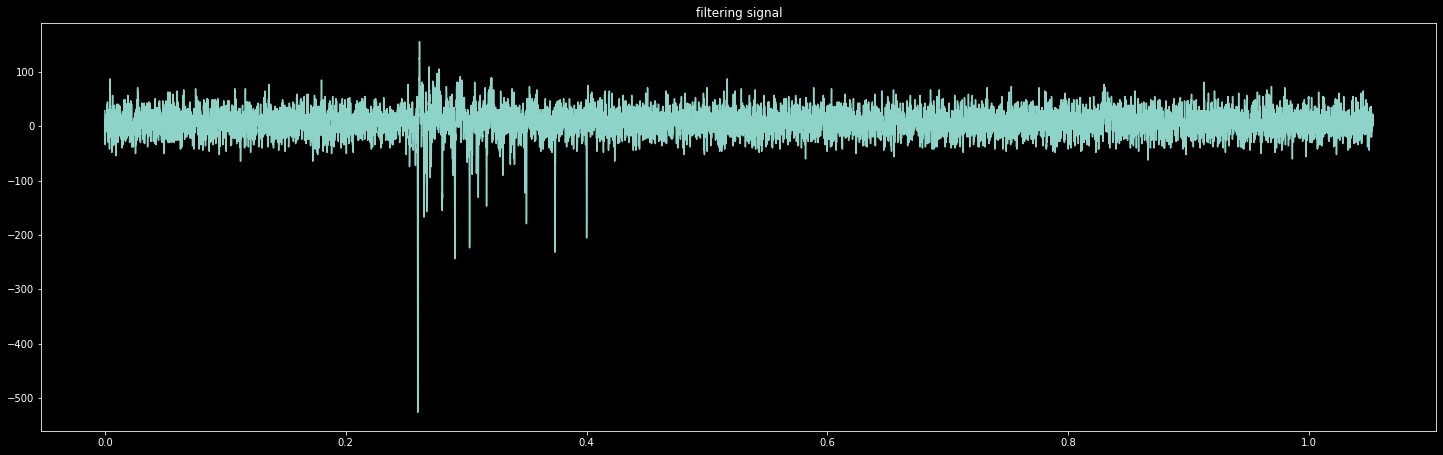

In [27]:
plt.figure(figsize=(25,7.5))
plt.plot(range(len(singleElectrodeUV))/sampmlingFrequency, singleElectrodeUV) 
plt.title('filtering signal')
plt.show()

In [28]:
singleElectrodeUV, sampmlingFrequency =  loadChannel((53,20), dir1)

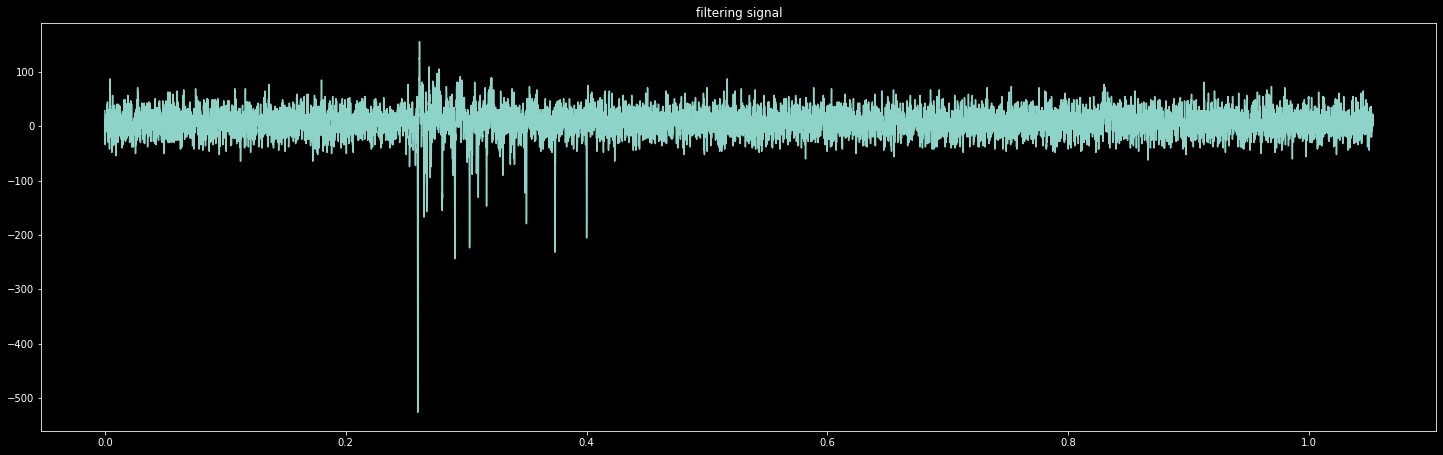

In [29]:
plt.figure(figsize=(25,7.5))
plt.plot(range(len(singleElectrodeUV))/sampmlingFrequency, singleElectrodeUV) 
plt.title('filtering signal')
plt.show()

In [30]:
rawData, numChs, frames, sampmlingFrequency =  loadData(dir2)

In [31]:
def count(sig):
    n = sum(num == 0 for num in sig)
    return n

In [32]:
# number of zeros
x = rawData.tolist().count(0)
x

3075134

In [33]:
# number of spikes
spikesNumber = len(rawData)-x
spikesNumber

83030978